#LUPA - Levantamento Unificado de Processos Judiciais Acidentários
###O objetivo deste trabalho é conceber e implementar uma rotina de extração e análise de dados de ações judiciais previdenciárias em matéria de acidentes do trabalho, para fins de obtenção de insights e tomada de decisão estratégica no gerenciamento do contencioso de massa previdenciário.

#### Autores:
#### *Igor Savitsky - Procurador Federal - AGU/PGF/PRF3/EBI3*
#### *Rosana Vasconcellos - Auditora Fiscal Federal Agropecuária - MAPA*

##1. Pré-tratamento e análise preliminar das variáveis

###1.0 Carregamento do dataframe e análises primárias

In [56]:
#importando as bibliotecas iniciais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import unicodedata
!pip install gdown
import gdown


In [57]:
# CARREGA O DATASET-MÃE A PARTIR DO GITHUB (TROCAR CF NECESSIDADE)

# Ler o arquivo diretamente do link usando pandas
df_lupa = pd.read_excel('https://raw.githubusercontent.com/isavitskii/LUPA/main/datasets/1_df_lupa_mae_item-1-0.xlsx')

# Mostrar as primeiras linhas do dataframe
df_lupa.head()

,result,foro,vara,distr,perito
0,FAVORÁVEL,São Bernardo do Campo,1,2020-09-22 00:00:00,Nikolai Jarcew Júnior
1,FAVORÁVEL,São Bernardo do Campo,1,24/05/2023,VERIFICAR
2,FAVORÁVEL,São Bernardo do Campo,8,2021-12-02 00:00:00,Fernanda Awada Campanella
3,FAVORÁVEL,São Bernardo do Campo,1,2021-05-30 00:00:00,Walkiria Hueb Bernardi
4,DESFAVORÁVEL,São Bernardo do Campo,3,2022-08-02 00:00:00,Mauro Abrahão Rozman


In [58]:
#puxa as informações gerais do dataset
print(df_lupa.info())
print(df_lupa.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6124 entries, 0 to 6123
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   result  6124 non-null   object
 1   foro    6124 non-null   object
 2   vara    6124 non-null   object
 3   distr   6124 non-null   object
 4   perito  6124 non-null   object
dtypes: object(5)
memory usage: 239.3+ KB
None
result    0
foro      0
vara      0
distr     0
perito    0
dtype: int64


In [59]:
# Concatenar 'vara' e 'foro' em 'orgao_julgador'
df_lupa['orgao_julgador'] = df_lupa['vara'].astype(str) + ' - ' + df_lupa['foro'].astype(str)

# Remover a coluna 'vara'
df_lupa = df_lupa.drop('vara', axis=1)

# Mostrar as primeiras linhas do dataframe atualizado
df_lupa.head()


,result,foro,distr,perito,orgao_julgador
0,FAVORÁVEL,São Bernardo do Campo,2020-09-22 00:00:00,Nikolai Jarcew Júnior,1 - São Bernardo do Campo
1,FAVORÁVEL,São Bernardo do Campo,24/05/2023,VERIFICAR,1 - São Bernardo do Campo
2,FAVORÁVEL,São Bernardo do Campo,2021-12-02 00:00:00,Fernanda Awada Campanella,8 - São Bernardo do Campo
3,FAVORÁVEL,São Bernardo do Campo,2021-05-30 00:00:00,Walkiria Hueb Bernardi,1 - São Bernardo do Campo
4,DESFAVORÁVEL,São Bernardo do Campo,2022-08-02 00:00:00,Mauro Abrahão Rozman,3 - São Bernardo do Campo


In [60]:
'''Segmentação do dataset conforme a referência da data de distribuição -
Ao combinar com as variáveis 'result' (target) e 'perito', observa-se um
padrão de diminuição do percentual de linhas sem perito identificado e de
resultados favoráveis conformem os anos progridem, devido provavelmente à
extração ter origem em sistema informatizado aplicado apenas a partir de
2017 para as referidas ações (antes eram acompanhadas em outro sistema)'''

# Conversão da variável 'distr' para formato de data (variável 'distrib') e descarte de 'distr'
df_lupa['distrib'] = pd.to_datetime(df_lupa['distr'], errors='coerce', dayfirst='True')
df_lupa = df_lupa.drop('distr', axis=1)

#Contagem dos valores nulos após conversão
print("Valores nulos de data após conversão: ", df_lupa['distrib'].isna().sum())
print("\n")

# Trazer a frequência de linhas conforme o ano presente na coluna 'distr' e a frequência de 'VERIFICAR' na coluna 'perito'
df_lupa['ano_distr'] = df_lupa['distrib'].dt.year#pd.to_datetime(df_lupa['distr'], format='%d/%m/%Y', errors='coerce').dt.year
frequencia_por_ano = df_lupa.groupby('ano_distr')['ano_distr'].count()
frequencia_verificar_por_ano = df_lupa[df_lupa['perito'] == 'VERIFICAR'].groupby('ano_distr')['ano_distr'].count()
frequencia_favoravel_por_ano = df_lupa[df_lupa['result'] == 'FAVORÁVEL'].groupby('ano_distr')['ano_distr'].count()
df_frequencia = pd.concat([frequencia_por_ano, frequencia_verificar_por_ano, frequencia_favoravel_por_ano], axis=1)
df_frequencia.columns = ['Total', 'Sem Perito', 'Favorável']
df_frequencia['% Sem Perito'] = (df_frequencia['Sem Perito'] / df_frequencia['Total']) * 100
df_frequencia['% Sem Perito'] = df_frequencia['% Sem Perito'].round(2)
df_frequencia['% Favorável'] = (df_frequencia['Favorável'] / df_frequencia['Total']) * 100
df_frequencia['% Favorável'] = df_frequencia['% Favorável'].round(2)

print("Tabela Ano / Sem Perito / Favorável: ","\n", df_frequencia)

print(df_lupa.info())


Valores nulos de data após conversão:  17


Tabela Ano / Sem Perito / Favorável:  
            Total  Sem Perito  Favorável  % Sem Perito  % Favorável
ano_distr                                                         
1989.0         1           1          1        100.00       100.00
1993.0         2           2          2        100.00       100.00
1994.0         2           2          2        100.00       100.00
1995.0         3           2          2         66.67        66.67
1996.0         2           2          2        100.00       100.00
1997.0         6           6          6        100.00       100.00
1998.0         8           8          7        100.00        87.50
1999.0         6           6          5        100.00        83.33
2000.0         9           9          8        100.00        88.89
2001.0         5           5          5        100.00       100.00
2002.0        22          22         19        100.00        86.36
2003.0        14          13         14      

In [61]:
# 1 - Valores e frequência da variável 'result'
print("Valores e frequência da variável 'result':")
print(df_lupa['result'].value_counts())
print("\n")
print(df_lupa['result'].value_counts(normalize=True))
print("\n")


# 1 - Valores e frequência da variável 'foro'
print("Valores e frequência da variável 'foro':")
print(df_lupa['foro'].value_counts())
print("\n")

# 2 - Valores e frequência da variável 'orgao_julgador'
print("Valores e frequência da variável 'orgao_julgador':")
print(df_lupa['orgao_julgador'].value_counts())
print("\n")

# 3 - TODOS os Valores e frequência da variável 'perito' /
#pd.set_option('display.max_rows', None) #tira o limite de linhas, para analisar melhor os valores
qtde_peritos = len(df_lupa['perito'].unique())
print(f'Quantidade de valores_unicos em "perito": {qtde_peritos}')
print("Valores e frequência da variável 'perito':")
print(df_lupa['perito'].value_counts(dropna=False))


Valores e frequência da variável 'result':
result
FAVORÁVEL       3522
DESFAVORÁVEL    2602
Name: count, dtype: int64


result
FAVORÁVEL       0.575114
DESFAVORÁVEL    0.424886
Name: proportion, dtype: float64


Valores e frequência da variável 'foro':
foro
São Bernardo do Campo               4268
Santo André                         1813
R                                     17
Diadema                                9
tral - Fazenda Pública/Acidentes       7
Mauá                                   4
São Caetano do Sul                     3
Rio Grande da Serra                    1
Ribeirão Pires                         1
Hortolândia                            1
Name: count, dtype: int64


Valores e frequência da variável 'orgao_julgador':
orgao_julgador
5 - São Bernardo do Campo               520
2 - São Bernardo do Campo               520
4 - São Bernardo do Campo               505
1 - São Bernardo do Campo               476
8 - São Bernardo do Campo               469
6 - São Bernardo d

###1.1 DataFrame de teste para avaliar a retirada dos processos anteriores a 2017
***Resultado: classes melhor balanceadas e diminuição drástica de linhas
sem perito identificado ('VERIFICAR' - de 1248 para 461).***

In [62]:
'''CRIANDO UM DATAFRAME DE TESTE PARA AVALIAR A RETIRADA DOS PROCESSOS
ANTERIORES A 2017 (IMPLANTAÇÃO DO SAPIENS)
Resultado: classes melhor balanceadas e diminuição drástica de linhas
sem perito identificado (VERIFICAR - de 1248 para 461).'''


# Crie um novo DataFrame chamado df_lupa_teste1, eliminando as linhas com 'distrib' anterior a 01/01/2017
df_lupa_teste1 = df_lupa.copy()
df_lupa_teste1 = df_lupa_teste1[df_lupa_teste1['ano_distr'] >= 2017]

# Verifique o DataFrame resultante
print(df_lupa_teste1.head())

#puxa as informações gerais do dataset
print("Exploração inicial do novo dataset: ", "\n", df_lupa_teste1.info())
print("\n")


#Contagem dos valores nulos após conversão
print("Valores nulos após conversão: ", "\n",  df_lupa_teste1.isna().sum())
print("\n")


# 1 - Valores e frequência da variável 'result'
print("Valores e frequência da variável 'result':")
print(df_lupa_teste1['result'].value_counts())
print("\n")
print(df_lupa_teste1['result'].value_counts(normalize=True))
print("\n")


# 1 - Valores e frequência da variável 'foro'
print("Valores e frequência da variável 'foro':")
print(df_lupa_teste1['foro'].value_counts())
print("\n")

# 2 - Valores e frequência da variável 'orgao_julgador'
print("Valores e frequência da variável 'orgao_julgador':")
print(df_lupa_teste1['orgao_julgador'].value_counts())
print("\n")

# 3 - TODOS os Valores e frequência da variável 'perito' /
#pd.set_option('display.max_rows', None) #tira o limite de linhas, para analisar melhor os valores
qtde_peritos = len(df_lupa_teste1['perito'].unique())
print(f'Quantidade de valores_unicos em "perito": {qtde_peritos}')
print("Valores e frequência da variável 'perito':")
print(df_lupa_teste1['perito'].value_counts(dropna=False))


         result                   foro                     perito  \
0     FAVORÁVEL  São Bernardo do Campo      Nikolai Jarcew Júnior   
1     FAVORÁVEL  São Bernardo do Campo                  VERIFICAR   
2     FAVORÁVEL  São Bernardo do Campo  Fernanda Awada Campanella   
3     FAVORÁVEL  São Bernardo do Campo     Walkiria Hueb Bernardi   
4  DESFAVORÁVEL  São Bernardo do Campo       Mauro Abrahão Rozman   

              orgao_julgador    distrib  ano_distr  
0  1 - São Bernardo do Campo 2020-09-22     2020.0  
1  1 - São Bernardo do Campo 2023-05-24     2023.0  
2  8 - São Bernardo do Campo 2021-12-02     2021.0  
3  1 - São Bernardo do Campo 2021-05-30     2021.0  
4  3 - São Bernardo do Campo 2022-08-02     2022.0  
<class 'pandas.core.frame.DataFrame'>
Index: 5087 entries, 0 to 6122
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   result          5087 non-null   object        
 1   foro 

###1.2. Tratamento preliminar da coluna de nomes dos peritos
***Resultado: eliminação de parte das duplicadas indevidas***

In [63]:
#Carrega bibliotecas para manipulação de strings e REGEX
import re
import unicodedata

#Função de padronização simples inicial
def padronizar_perito(nome):
    # Normaliza a string e remove os acentos
    nome = unicodedata.normalize('NFKD', nome).encode('ASCII', 'ignore').decode('ascii')
    # Convertendo para maiúsculas
    nome = nome.upper()
    # Removendo espaços em branco
    nome = nome.strip()
    # Removendo pontos, traços e acentos soltos (adapte o padrão regex conforme necessário)
    nome = re.sub(r'[^\w\s]', '', nome)
    # Removendo 'DRA' e 'DR' do início
    nome = re.sub(r'^DRA|^DR', '', nome)
    # Arrumando os 'JUNIOR'
    nome = re.sub(r'JUNIOR', 'JR', nome)
    # Removendo '\n' e '\t'
    nome = nome.replace('\n', '').replace('\t', '')
    # Remove espaços em branco no começo e final novamente
    nome = nome.strip()
    return nome

# Aplica a função a toda a coluna
df_lupa_teste1.loc[:, 'perito'] = df_lupa['perito'].apply(padronizar_perito)

#mostra a coluna em ordem alfabética
pd.set_option('display.max_rows', None) #tira o limite de linhas, para analisar melhor os valores
qtde_peritos = len(df_lupa_teste1['perito'].unique())
print(f'Quantidade de valores_unicos em "perito": {qtde_peritos}')
print("Valores e frequência da variável 'perito':")
print(df_lupa_teste1['perito'].value_counts(dropna=False))

Quantidade de valores_unicos em "perito": 108
Valores e frequência da variável 'perito':
perito
FERNANDA AWADA CAMPANELLA                                                        1446
VERIFICAR                                                                         461
ROBERTO CHIMINAZZO                                                                442
MAURO ABRAHAO ROZMAN                                                              425
PEDRO RODRIGUES SANCHES                                                           263
WALKIRIA HUEB BERNARDI                                                            246
RENATO MARI NETO                                                                  180
ARY ANTONIO TODARO JR                                                             165
NIKOLAI JARCEW JR                                                                 125
WILSON IKEDA                                                                      121
DANILLO SANTINELLO                          

In [64]:
#

unique_peritos = sorted(df_lupa_teste1['perito'].unique())
peritos_series = pd.Series(unique_peritos)

print(peritos_series)


0                            ADRIANA FRANCA ARAUJO CUNHA
1                                    ADRIANA GOMES DONNO
2                      ALCENOR DE CARVALHO MIRANDA FILHO
3                      ALDO FRANKLIN DE OLIVEIRA PEREIRA
4          ALDO FRANKLIN DE OLIVEIRA PEREIRA PERITO INSS
5                                     ALEXANDRE PODGAETI
6                            ALVARO LUIZ PINTO PANTALEAO
7                             AMANDA DE GOUVEA PETTERSEN
8                                 AMAURI CLOZER PINHEIRO
9                              ANA CRISTINA PIRES VIEIRA
10                           ANA LAURA DE CARVALHO SATTI
11                           ANA LAURA DE CARVALHO SATTO
12                          ANA LUCIA INNACO DE CARVALHO
13                          ANTONINI DE OLIVEIRA E SOUSA
14     ANTONINI DE OLIVEIRA E SOUSA OTORRINOLARINGOLOGIA
15                                ARISTIDES COSTA VIEIRA
16                                 ARNALDO RYOSICHI USUI
17                             

***Tendo em vista que ainda há muitas linhas com perito desconhecido ('VERIFICAR'), e que uma análise por amostragem evidenciou que parte dessas ausências pode ser explicada por se tratar de registros de incidentes processuais autônomos de cumprimento de sentença, ou então casos que foram extintos antes mesmo da realização de uma perícia, decidiu-se raspar dos andamentos processuais as variáveis 'classe_processual' (que separa os incidentes dos processos principais) e 'result_tjsp' (resultado das sentenças e/ou decisões terminativas de primeira instância). Já que necessária a raspagem descrita, decidiu-se também a captação da variável 'advogado', para robustecer o modelo.***

###1.3. Exportação do DataFrame testado para raspagem das variáveis 'advogado', 'classe_processual' e 'result_tjsp', e recarregamento do dataset com as novas variáveis e novo tratamento preliminar

In [65]:
# # Exportar o DataFrame para um arquivo Excel
# df_lupa_teste1.to_excel('df_lupa_teste1.xlsx', index=False)

# # Download do arquivo
# from google.colab import files
# files.download('df_lupa_teste1.xlsx')


In [66]:
# CARREGA O NOVO DATASET COM OS DADOS DE ADVOGADO, CLASSE PROCESSUAL E RESULTADO_TJSP RASPADO

# Ler o arquivo XLSX diretamente do link usando pandas
df_lupa_2 = pd.read_excel('https://raw.githubusercontent.com/isavitskii/LUPA/main/datasets/2_df_lupa_pos_raspagem_item-1-3.xlsx')
# Mostrar as primeiras linhas do dataframe
df_lupa_2.head()

,result,foro,perito,orgao_julgador,advogado,classe_processual,result_tjsp
0,FAVORÁVEL,São Bernardo do Campo,VERIFICAR,1 - São Bernardo do Campo,Roberto de Camargo Junior,Procedimento Comum Cível,FAVORÁVEL
1,FAVORÁVEL,São Bernardo do Campo,VERIFICAR,3 - São Bernardo do Campo,Caique Vinicius Castro Souza,Procedimento Comum Cível,EXTINTIVO
2,FAVORÁVEL,São Bernardo do Campo,VERIFICAR,8 - São Bernardo do Campo,David Orsi Domingues,Procedimento Comum Cível,EXTINTIVO
3,FAVORÁVEL,Santo André,VERIFICAR,1 - Santo André,Agamenon Martins de Oliveira,Procedimento Comum Cível,EXTINTIVO
4,FAVORÁVEL,São Bernardo do Campo,VERIFICAR,6 - São Bernardo do Campo,Agamenon Martins de Oliveira,Procedimento Comum Cível,EXTINTIVO


In [67]:
# ANÁLISE GERAL DO DATASET E DOS VALORES NULOS NO DATASET ('VERIFICAR')

#Visão geral das variáveis
print("Visão geral das variáveis:" , '\n'),
print(df_lupa_2.info())
print('\n', '\n')


#Função para contar os valores nulos ('VERIFICAR')
def contar_verificar(col):
    if col.dtype == 'object':  # Aplica apenas em colunas de texto (object)
        return col.str.contains('VERIFICAR', na=False).sum()
    return 0  # Retorna 0 para colunas que não são de texto

# Aplica a função e soma por coluna
soma_verificar = df_lupa_2.apply(contar_verificar)

#Exibe os valores nulos
print("Valores nulos por coluna:", '\n')
print(soma_verificar)

Visão geral das variáveis: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5087 entries, 0 to 5086
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   result             5087 non-null   object
 1   foro               5087 non-null   object
 2   perito             5087 non-null   object
 3   orgao_julgador     5087 non-null   object
 4   advogado           5087 non-null   object
 5   classe_processual  5087 non-null   object
 6   result_tjsp        5087 non-null   object
dtypes: object(7)
memory usage: 278.3+ KB
None

 

Valores nulos por coluna: 

result                 0
foro                   0
perito               461
orgao_julgador         0
advogado             120
classe_processual      0
result_tjsp           78
dtype: int64


Valores e frequência da variável 'class_processual':
classe_processual
Procedimento Comum Cível                                        4908
Incidente - Cumprimento de Sentença contra a Fazenda Pública     108
Incidente - Cumprimento de sentença                               40
Incidente - Cumprimento Provisório de Sentença                    19
Cumprimento de Sentença contra a Fazenda Pública                   5
Cumprimento de sentença                                            4
Produção Antecipada da Prova                                       2
Petição Cível                                                      1
Name: count, dtype: int64


classe_processual
Procedimento Comum Cível                                        0.964812
Incidente - Cumprimento de Sentença contra a Fazenda Pública    0.021231
Incidente - Cumprimento de sentença                             0.007863
Incidente - Cumprimento Provisório de Sentença                  0.003735
Cumprimento de Sentença contra a Fazend

<Axes: xlabel='classe_processual'>

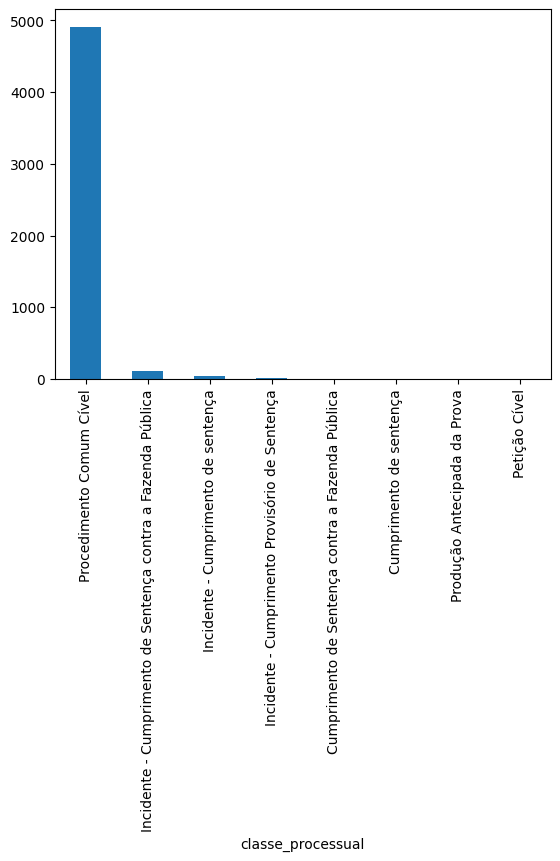

In [68]:
#ANÁLISE DA DISTRIBUIÇÃO DAS VARIÁVEIS 'classe_processual' E 'resultado_tjsp'

# 1 - Valores e frequência da variável 'classe_processual'
print("Valores e frequência da variável 'class_processual':")
print(df_lupa_2['classe_processual'].value_counts())
print("\n")
print(df_lupa_2['classe_processual'].value_counts(normalize=True))
print("\n")
df_lupa_2['classe_processual'].value_counts().plot(kind='bar')



Valores e frequência da variável 'result_tjsp':
result_tjsp
FAVORÁVEL       2250
DESFAVORÁVEL    2116
EXTINTIVO        376
ACORDO           267
VERIFICAR         78
Name: count, dtype: int64


result_tjsp
FAVORÁVEL       0.442304
DESFAVORÁVEL    0.415962
EXTINTIVO       0.073914
ACORDO          0.052487
VERIFICAR       0.015333
Name: proportion, dtype: float64




<Axes: xlabel='result_tjsp'>

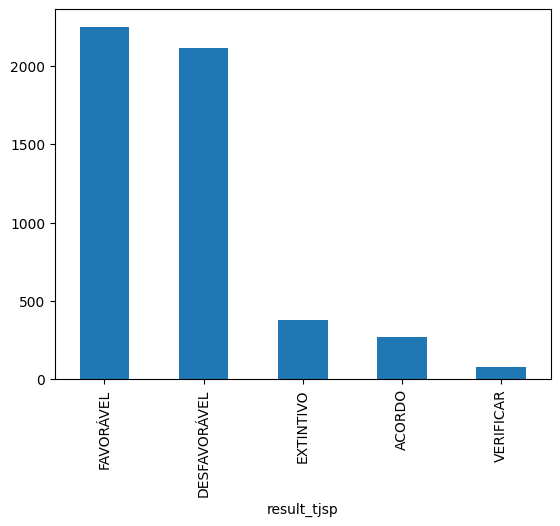

In [69]:

# 2 - Valores e frequência da variável 'result_tjsp'
print("Valores e frequência da variável 'result_tjsp':")
print(df_lupa_2['result_tjsp'].value_counts())
print("\n")
print(df_lupa_2['result_tjsp'].value_counts(normalize=True))
print("\n")
df_lupa_2['result_tjsp'].value_counts().plot(kind='bar')

###1.4. Eliminação das ocorrências de 'Incidente' em 'classe_processual', e da coincidência entre 'result_tjsp' 'EXTINTIVO' e 'perito' 'VERIFICAR'

In [70]:
# Filtro do dataset eliminando:
# (i) as ocorrência de 'classe_processual' identificadas como 'Incidente'
# (ii) as ocorrência combinadas de 'perito' == 'VERIFICAR' e 'result_tjsp' == 'EXTINTIVO'

filtro1 = df_lupa_2['classe_processual'].str.contains('Incidente')
filtro2 = (df_lupa_2['perito'] == 'VERIFICAR') & (df_lupa_2['result_tjsp'] == 'EXTINTIVO')

#tamanho dos filtros
print("Linhas contendo incidentes processuais: ",filtro1.sum())
print("Linhas contendo resultado extintivo e sem perito identificado: ",filtro2.sum())

# Excluir as linhas que atendem aos critérios acima
df_lupa_2_filtro = df_lupa_2[~filtro1]
df_lupa_2_filtro = df_lupa_2_filtro[~filtro2]

#Reanálise geral das variáveis
print("Visão geral das variáveis:" , '\n'),
print(df_lupa_2_filtro.info())
print('\n', '\n')

# Reanálise dos valores nulos do dataset após o tratamento
 #Função para contar os valores nulos ('VERIFICAR')
def contar_verificar(col):
    if col.dtype == 'object':  # Aplica apenas em colunas de texto (object)
        return col.str.contains('VERIFICAR', na=False).sum()
    return 0  # Retorna 0 para colunas que não são de texto

# Aplica a função e soma por coluna
soma_verificar = df_lupa_2_filtro.apply(contar_verificar)

#Exibe os valores nulos
print("Valores nulos por coluna:", '\n')
print(soma_verificar)

#Novo balanceamento do target ('result')
print("Valores e frequência da variável 'result':")
print(df_lupa_2_filtro['result'].value_counts())
print("\n")
print(df_lupa_2_filtro['result'].value_counts(normalize=True))

Linhas contendo incidentes processuais:  167
Linhas contendo resultado extintivo e sem perito identificado:  242
Visão geral das variáveis: 

<class 'pandas.core.frame.DataFrame'>
Index: 4732 entries, 0 to 5086
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   result             4732 non-null   object
 1   foro               4732 non-null   object
 2   perito             4732 non-null   object
 3   orgao_julgador     4732 non-null   object
 4   advogado           4732 non-null   object
 5   classe_processual  4732 non-null   object
 6   result_tjsp        4732 non-null   object
dtypes: object(7)
memory usage: 295.8+ KB
None

 

Valores nulos por coluna: 

result                 0
foro                   0
perito               111
orgao_julgador         0
advogado               4
classe_processual      0
result_tjsp           33
dtype: int64
Valores e frequência da variável 'result':
result
FAVORÁVEL       2

<ipython-input-70-a7ec2aeeeea0>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_lupa_2_filtro = df_lupa_2_filtro[~filtro2]


In [71]:
# Com classes 'target' bem balanceadas e diminuição dos valores nulos em 'perito', aplica-se o filtro ao dataframe atual
df_lupa_2 = df_lupa_2[~filtro1]
df_lupa_2 = df_lupa_2[~filtro2]

df_lupa_2.shape

<ipython-input-71-de5307f91350>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_lupa_2 = df_lupa_2[~filtro2]


(4732, 7)

###1.5. Análise e tratamento da variável 'advogado'

In [72]:
#Análise preliminar da coluna 'Advogados'
pd.set_option('display.max_rows', None) #tira o limite de linhas, para analisar melhor os valores
qtde_adv = len(df_lupa_2['advogado'].unique())
print(f'Quantidade de valores_unicos em "advogado": {qtde_adv}')
print("Valores e frequência da variável 'advogado':")
print(df_lupa_2['advogado'].value_counts(dropna=False))

#Análise manual dos nomes, para identificar eventuais inconsistências, como na 'perito'
unique_adv = sorted(df_lupa_2['advogado'].unique())
adv_series = pd.Series(unique_adv)
print(adv_series)


Quantidade de valores_unicos em "advogado": 943
Valores e frequência da variável 'advogado':
advogado
Roberto de Camargo Junior                             413
Luis Augusto Olivieri                                 281
Agamenon Martins de Oliveira                          215
Fabio Frederico de Freitas Tertuliano                 102
Karina Cristina Casa Grande Teixeira                   92
Ademar Nyikos                                          80
Fernanda Pedroso Cintra de Souza                       80
Edimar Hidalgo Ruiz                                    77
Clayton Eduardo Casal Santos                           77
Antonio Wender Pereira                                 71
Ruslan Stuchi                                          71
Vladimir Renato de Aquino Lopes                        68
Melissa Tonin                                          65
Gloria Mary D´agostino Sacchi                          57
Mair Ferreira de Araujo                                56
Francisco Neuton Gomes de Al

In [73]:
#Exibe registros 'VERIFICAR' da variável 'advogado' (valores nulos)
df_adv_null = df_lupa_2_filtro[df_lupa_2_filtro['advogado'].str.contains('VERIFICAR')]
df_adv_null


,result,foro,perito,orgao_julgador,advogado,classe_processual,result_tjsp
1124,DESFAVORÁVEL,São Bernardo do Campo,MAURO ABRAHAO ROZMAN,6 - São Bernardo do Campo,VERIFICAR,Procedimento Comum Cível,DESFAVORÁVEL
2040,DESFAVORÁVEL,São Bernardo do Campo,CLAUDIA GOMES,6 - São Bernardo do Campo,VERIFICAR,Cumprimento de sentença,ACORDO
2072,DESFAVORÁVEL,Santo André,RENATO MARI NETO,1 - Santo André,VERIFICAR,Procedimento Comum Cível,DESFAVORÁVEL
3116,FAVORÁVEL,São Bernardo do Campo,FERNANDA AWADA CAMPANELLA,8 - São Bernardo do Campo,VERIFICAR,Procedimento Comum Cível,FAVORÁVEL


In [74]:
#Preenchimento manual dos nomes faltantes, conforme pesquisa ao site da Justiça (TJSP)
advogados_corretos = {
    1124: 'Fernando Guimarães de Souza Junior',
    2040: 'Nathalia Hilda de Santana',
    2072: 'Silvia Regina dos Santos Clemente',
    3116: 'Agamenon Martins de Oliveira',
}

# Substituir os valores 'VERIFICAR' pelos nomes corretos
for idx, nome in advogados_corretos.items():
    df_lupa_2.at[idx, 'advogado'] = nome


# Exibir apenas as linhas com esses índices
print(df_lupa_2.loc[[1124, 2040, 2072, 3116]])

#Função para contar os valores nulos ('VERIFICAR')
def contar_verificar(col):
    if col.dtype == 'object':  # Aplica apenas em colunas de texto (object)
        return col.str.contains('VERIFICAR', na=False).sum()
    return 0  # Retorna 0 para colunas que não são de texto

# Aplica a função e soma por coluna
soma_verificar = df_lupa_2.apply(contar_verificar)

#Exibe os valores nulos
print("Valores nulos por coluna:", '\n')
print(soma_verificar)

            result                   foro                     perito  \
1124  DESFAVORÁVEL  São Bernardo do Campo       MAURO ABRAHAO ROZMAN   
2040  DESFAVORÁVEL  São Bernardo do Campo              CLAUDIA GOMES   
2072  DESFAVORÁVEL            Santo André           RENATO MARI NETO   
3116     FAVORÁVEL  São Bernardo do Campo  FERNANDA AWADA CAMPANELLA   

                 orgao_julgador                            advogado  \
1124  6 - São Bernardo do Campo  Fernando Guimarães de Souza Junior   
2040  6 - São Bernardo do Campo           Nathalia Hilda de Santana   
2072            1 - Santo André   Silvia Regina dos Santos Clemente   
3116  8 - São Bernardo do Campo        Agamenon Martins de Oliveira   

             classe_processual   result_tjsp  
1124  Procedimento Comum Cível  DESFAVORÁVEL  
2040   Cumprimento de sentença        ACORDO  
2072  Procedimento Comum Cível  DESFAVORÁVEL  
3116  Procedimento Comum Cível     FAVORÁVEL  
Valores nulos por coluna: 

result              

### 1.6. Tratamento manual de valores nulos na coluna 'result_tjsp'
*A análise evidenciou o 'escape' de algumas categorias, uma vez que os dados disponibilizados pelo TJSP ao público são semi-estruturados e seguem padrões díspares de redação, o que desafia as técnicas de raspagem de dados*

In [75]:
#APLICA O FILTRO AO DATAFRAME
filtro3 = df_lupa_2[df_lupa_2['result_tjsp'] == 'VERIFICAR']
filtro3 [['result_tjsp']]

# # Exportar o DataFrame para um arquivo Excel, para tratamento manual
# filtro3.to_excel('filtro3.xlsx')

# # Download do arquivo
# from google.colab import files
# files.download('filtro3.xlsx')

,result_tjsp
142,VERIFICAR
458,VERIFICAR
557,VERIFICAR
1413,VERIFICAR
1474,VERIFICAR
1794,VERIFICAR
1874,VERIFICAR
2105,VERIFICAR
2229,VERIFICAR
2812,VERIFICAR


In [76]:
#Preenchimento manual dos resultados faltantes, conforme pesquisa ao site da Justiça (TJSP)
resultados_corretos = {
    142: 'DESFAVORÁVEL',
    458: 'DESFAVORÁVEL',
    557: 'FAVORÁVEL',
    1413: 'DESFAVORÁVEL',
    1474: 'DESFAVORÁVEL',
    1794: 'DESFAVORÁVEL',
    1874: 'EXTINTIVO',
    2105: 'EXTINTIVO',
    2229: 'EXTINTIVO',
    2812: 'ACORDO',
    3135: 'ACORDO',
    3339: 'ACORDO',
    3344: 'ACORDO',
    3349: 'ACORDO',
    3615: 'DESFAVORÁVEL',
    3702: 'ACORDO',
    3767: 'ACORDO',
    3922: 'ACORDO',
    3979: 'ACORDO',
    4157: 'ACORDO',
    4332: 'ACORDO',
    4348: 'ACORDO',
    4386: 'ACORDO',
    4445: 'ACORDO',
    4461: 'DESFAVORÁVEL',
    4538: 'EXTINTIVO',
    4647: 'ACORDO',
    4736: 'ACORDO',
    4819: 'ACORDO',
    4978: 'ACORDO',
    4979: 'ACORDO',
    4988: 'ACORDO',
    5027: 'ACORDO'
}

#PARA TRATAMENTOS FUTUROS, OUTROS ÍNDICES CORRIGIDOS APÓS TRATAMENTO MANUAL
    # 2614: 'EXTINTIVO',
    # 3392: 'ACORDO',
    # 4005: 'EXTINTIVO'

# Substituir os valores 'VERIFICAR' pelos nomes corretos
for idx, nome in resultados_corretos.items():
    df_lupa_2.at[idx, 'result_tjsp'] = nome

#Dimensões atuais do dataset
print("Dimensões atuais do dataset:", '\n')
print(df_lupa_2.shape, '\n')

#Função para contar os valores nulos ('VERIFICAR')
def contar_verificar(col):
    if col.dtype == 'object':  # Aplica apenas em colunas de texto (object)
        return col.str.contains('VERIFICAR', na=False).sum()
    return 0  # Retorna 0 para colunas que não são de texto

# Aplica a função e soma por coluna
soma_verificar = df_lupa_2.apply(contar_verificar)

#Exibe os valores nulos
print("Valores nulos por coluna:", '\n')
print(soma_verificar)



Dimensões atuais do dataset: 

(4732, 7) 

Valores nulos por coluna: 

result                 0
foro                   0
perito               111
orgao_julgador         0
advogado               0
classe_processual      0
result_tjsp            0
dtype: int64


###1.7. Tratamento da variável 'perito' - Eliminação de nulos e de duplicadas espúrias

####***Eliminação dos valores nulos***

In [77]:
#APLICA O FILTRO AO DATAFRAME
filtro4 = df_lupa_2[df_lupa_2['perito'] == 'VERIFICAR']

# Exportar o DataFrame para um arquivo Excel, para tratamento manual
# filtro4.to_excel('filtro4.xlsx')

# # Download do arquivo
# from google.colab import files
# files.download('filtro4.xlsx')

filtro4.head()


,result,foro,perito,orgao_julgador,advogado,classe_processual,result_tjsp
0,FAVORÁVEL,São Bernardo do Campo,VERIFICAR,1 - São Bernardo do Campo,Roberto de Camargo Junior,Procedimento Comum Cível,FAVORÁVEL
19,FAVORÁVEL,Santo André,VERIFICAR,9 - Santo André,Michel Moreira Cobra,Procedimento Comum Cível,FAVORÁVEL
22,FAVORÁVEL,Santo André,VERIFICAR,7 - Santo André,Giuliano Grando,Procedimento Comum Cível,DESFAVORÁVEL
36,DESFAVORÁVEL,Santo André,VERIFICAR,3 - Santo André,Ademar Nyikos,Procedimento Comum Cível,DESFAVORÁVEL
37,FAVORÁVEL,Santo André,VERIFICAR,1 - Santo André,Fernanda Pedroso Cintra de Souza,Procedimento Comum Cível,FAVORÁVEL


***A análise por amostragem das linhas com valores nulos de perito evidenciou que se tratava de casos sem interesse para a análise, pois eram casos que não houve designação ou realização de perícia nas comarcas analisadas, o que permitiu a exclusão desses registros do dataset.***

Dimensões atuais do dataset: 

(4621, 7) 

Valores nulos por coluna: 

result               0
foro                 0
perito               0
orgao_julgador       0
advogado             0
classe_processual    0
result_tjsp          0
dtype: int64
Valores e frequência da variável 'result':
result
FAVORÁVEL       2358
DESFAVORÁVEL    2263
Name: count, dtype: int64


result
FAVORÁVEL       0.510279
DESFAVORÁVEL    0.489721
Name: proportion, dtype: float64
Axes(0.125,0.11;0.775x0.77)


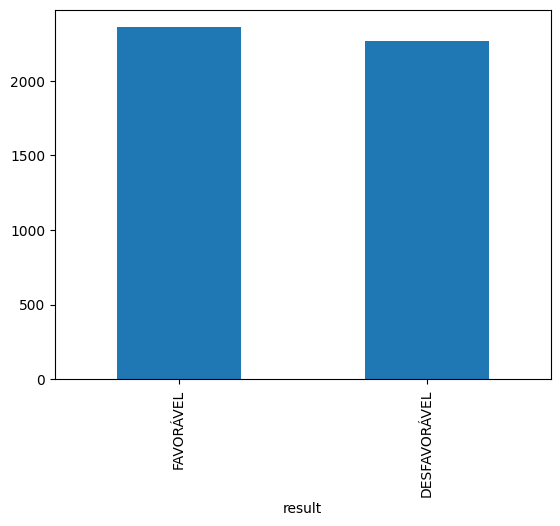

In [78]:
#ELIMINAÇÃO DOS VALORES NULOS DA COLUNA PERITO E NOVA ANÁLISE PRELIMINAR DO DATASET
df_lupa_3 = df_lupa_2[~df_lupa_2.index.isin(filtro4.index)]

#Dimensões atuais do dataset
print("Dimensões atuais do dataset:", '\n')
print(df_lupa_3.shape, '\n')

#Função para contar os valores nulos ('VERIFICAR')
def contar_verificar(col):
    if col.dtype == 'object':  # Aplica apenas em colunas de texto (object)
        return col.str.contains('VERIFICAR', na=False).sum()
    return 0  # Retorna 0 para colunas que não são de texto

# Aplica a função e soma por coluna
soma_verificar = df_lupa_3.apply(contar_verificar)

#Exibe os valores nulos
print("Valores nulos por coluna:", '\n')
print(soma_verificar)

#printa o balanceamentos das classes 'result'
print("Valores e frequência da variável 'result':")
print(df_lupa_3['result'].value_counts())
print("\n")
print(df_lupa_3['result'].value_counts(normalize=True))
print(df_lupa_3['result'].value_counts().plot(kind='bar'))

####***Eliminação das duplicatas espúrias***

In [79]:
#ELIMINAÇÃO DAS DUPLICADAS ESPÚRIAS
#Mostra Nomes
unique_peritos = sorted(df_lupa_3['perito'].unique())
peritos_series = pd.Series(unique_peritos)

print(peritos_series)

0                            ADRIANA FRANCA ARAUJO CUNHA
1                                    ADRIANA GOMES DONNO
2                      ALCENOR DE CARVALHO MIRANDA FILHO
3                      ALDO FRANKLIN DE OLIVEIRA PEREIRA
4          ALDO FRANKLIN DE OLIVEIRA PEREIRA PERITO INSS
5                                     ALEXANDRE PODGAETI
6                            ALVARO LUIZ PINTO PANTALEAO
7                             AMANDA DE GOUVEA PETTERSEN
8                                 AMAURI CLOZER PINHEIRO
9                              ANA CRISTINA PIRES VIEIRA
10                           ANA LAURA DE CARVALHO SATTI
11                           ANA LAURA DE CARVALHO SATTO
12                          ANA LUCIA INNACO DE CARVALHO
13                          ANTONINI DE OLIVEIRA E SOUSA
14     ANTONINI DE OLIVEIRA E SOUSA OTORRINOLARINGOLOGIA
15                                 ARY ANTONIO TODARO JR
16                            AYLTON MOREIRA DA SILVA JR
17                             

In [80]:
# Criar um dicionário para a coluna perito usando método keys e values

perito_dict = dict(zip(df_lupa_3['perito'].unique(), range(len(df_lupa_3['perito'].unique()))))

# Imprimir o dicionário criado
print(perito_dict)

# Print as dimensões do dicionário
print(f"Número de itens no dicionário: {len(perito_dict)}")

{'RENAN LOPES MONTEIRO': 0, 'AMAURI CLOZER PINHEIRO': 1, 'PEDRO RODRIGUES SANCHES': 2, 'NIKOLAI JARCEW JR': 3, 'WILSON IKEDA': 4, 'MAURO ABRAHAO ROZMAN': 5, 'ROBERTO CHIMINAZZO': 6, 'ROGERIO DE LEAO BENSADON': 7, 'JOAO ALFREDO CHUFFE': 8, 'WALKIRIA HUEB BERNARDI': 9, 'WILSON DIOGO FERNANDES FILHO': 10, 'IRENE SERRENTINO LOZOV PANTALEAO': 11, 'RENATO MARI NETO': 12, 'OSMAR JACINTO CAIS DA SILVA GOMES': 13, 'ARY ANTONIO TODARO JR': 14, 'FERNANDA AWADA CAMPANELLA': 15, 'WAGNER RICCA': 16, 'OSMAR JACINTO CAISA DA SILVA GOMES': 17, 'PEDRO PRODRIGUES SANCHES': 18, 'OSMAR JACINTHO CAIS DA SILVA GOMES': 19, 'OSMAR  JACINTO  CAIS GOMES DA SILVA': 20, 'LUCIO DOS SANTOS SCARAMUZZI': 21, 'OSMAR JACINTO C S GOMES': 22, 'IRENE SERRENTINO LOZOU PANTALEAO': 23, 'LUCIANO RENATO CAVICHIO': 24, 'RODRIGO RIBEIRO ROCHA': 25, 'NIKOLALI JARCEW JR': 26, 'AYLTON MOREIRA DA SILVA JR': 27, 'OSMAR JACINTO DA SILVA GOMES': 28, 'ANA LUCIA INNACO DE CARVALHO': 29, 'AZIS CHAGURY': 30, 'FLAVIO MENEZES SANCHES': 31, 'O

In [81]:
# Identificar similaridade entre todas as chaves usando a biblioteca FuzzyWuzzy que utiliza a a Distância de Levenshtein ou Distância de Edição para calcular diferenças entre sequências de strings de maneira simples.
# Da biblioteca FuzzyWuzzy utilizou a função Partial Ratio (fuzz.token_set_ratio) que serve para atender casos em que os strings possuam mais de uma palavra e ignoram palavras duplicadas.

!pip install fuzzywuzzy

from fuzzywuzzy import fuzz

# Criar uma lista com todas as chaves do dicionário
keys = list(perito_dict.keys())

# Criar uma matriz para armazenar as pontuações de similaridade
similarity_matrix = np.zeros((len(keys), len(keys)))

# Calcular a similaridade entre cada par de chaves usando fuzz.partial_ratio
for i in range(len(keys)):
  for j in range(i + 1, len(keys)):
    similarity_score = fuzz.token_set_ratio(keys[i], keys[j])
    similarity_matrix[i, j] = similarity_score
    similarity_matrix[j, i] = similarity_score

# Mostrar a matriz de similaridade
print(similarity_matrix)

print('Dimensões da Matriz: ', similarity_matrix.shape)

[[ 0. 38. 42. ... 16. 21. 35.]
 [38.  0. 27. ... 19. 20. 38.]
 [42. 27.  0. ... 23. 28. 26.]
 ...
 [16. 19. 23. ...  0. 39. 33.]
 [21. 20. 28. ... 39.  0. 38.]
 [35. 38. 26. ... 33. 38.  0.]]
Dimensões da Matriz:  (105, 105)


In [82]:
# Usandso a matriz de similaridade para encontrar pares de chaves que são muito semelhantes.
# Iremos encontrar todas as chaves que têm uma pontuação de similaridade maior que 80:
threshold = 80
for i in range(len(keys)):
  for j in range(i + 1, len(keys)):
    if similarity_matrix[i, j] > threshold:
      print(f"As chaves '{keys[i]}' e '{keys[j]}' têm uma pontuação de similaridade de {similarity_matrix[i, j]}.")


As chaves 'RENAN LOPES MONTEIRO' e 'MONTEIRO REGISTRADO CIVILMENTE COMO RENAN LOPES MONTEIRO' têm uma pontuação de similaridade de 100.0.
As chaves 'RENAN LOPES MONTEIRO' e 'RENAL LOPES MONTEIRO' têm uma pontuação de similaridade de 95.0.
As chaves 'PEDRO RODRIGUES SANCHES' e 'PEDRO PRODRIGUES SANCHES' têm uma pontuação de similaridade de 98.0.
As chaves 'PEDRO RODRIGUES SANCHES' e 'PEDRO RDRIGUES SANCHES' têm uma pontuação de similaridade de 98.0.
As chaves 'PEDRO RODRIGUES SANCHES' e 'PEDO RODRIGUES SANCHES' têm uma pontuação de similaridade de 98.0.
As chaves 'NIKOLAI JARCEW JR' e 'NIKOLALI JARCEW JR' têm uma pontuação de similaridade de 97.0.
As chaves 'MAURO ABRAHAO ROZMAN' e 'MAUROS ABRAHAO ROZMAN' têm uma pontuação de similaridade de 98.0.
As chaves 'WALKIRIA HUEB BERNARDI' e 'WALKIRIA HUERB BERNARDI' têm uma pontuação de similaridade de 98.0.
As chaves 'WALKIRIA HUEB BERNARDI' e 'WALKIRIA HUED BERNARDI' têm uma pontuação de similaridade de 95.0.
As chaves 'WALKIRIA HUEB BERNARD

In [83]:
# A partir do score de similaridade, substituir a keys[j] pela keys[i]

threshold = 80
for i in range(len(keys)):
  for j in range(i + 1, len(keys)):
    if similarity_matrix[i, j] > threshold:
      df_lupa_3['perito'] = df_lupa_3['perito'].replace(keys[j], keys[i])
      print(f"As chaves '{keys[j]}' foram substituídas por '{keys[i]}' com uma pontuação de similaridade de {similarity_matrix[i, j]}.")

As chaves 'MONTEIRO REGISTRADO CIVILMENTE COMO RENAN LOPES MONTEIRO' foram substituídas por 'RENAN LOPES MONTEIRO' com uma pontuação de similaridade de 100.0.
As chaves 'RENAL LOPES MONTEIRO' foram substituídas por 'RENAN LOPES MONTEIRO' com uma pontuação de similaridade de 95.0.
As chaves 'PEDRO PRODRIGUES SANCHES' foram substituídas por 'PEDRO RODRIGUES SANCHES' com uma pontuação de similaridade de 98.0.
As chaves 'PEDRO RDRIGUES SANCHES' foram substituídas por 'PEDRO RODRIGUES SANCHES' com uma pontuação de similaridade de 98.0.
As chaves 'PEDO RODRIGUES SANCHES' foram substituídas por 'PEDRO RODRIGUES SANCHES' com uma pontuação de similaridade de 98.0.
As chaves 'NIKOLALI JARCEW JR' foram substituídas por 'NIKOLAI JARCEW JR' com uma pontuação de similaridade de 97.0.
As chaves 'MAUROS ABRAHAO ROZMAN' foram substituídas por 'MAURO ABRAHAO ROZMAN' com uma pontuação de similaridade de 98.0.
As chaves 'WALKIRIA HUERB BERNARDI' foram substituídas por 'WALKIRIA HUEB BERNARDI' com uma pont

<ipython-input-83-e36f7bdfd495>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lupa_3['perito'] = df_lupa_3['perito'].replace(keys[j], keys[i])


In [84]:
# Verificar a classificação pelo nome dos peritos em ordem alfabética novamente após substituição de chaves
# Conclusão: usando similaridade maior que 80, reduziu de 105 peritos únicos para 74 peritos únicos

unique_peritos_corr1 = sorted(df_lupa_3['perito'].unique())
peritos_series1 = pd.Series(unique_peritos_corr1)

print(peritos_series1)

0                           ADRIANA FRANCA ARAUJO CUNHA
1                                   ADRIANA GOMES DONNO
2                     ALCENOR DE CARVALHO MIRANDA FILHO
3         ALDO FRANKLIN DE OLIVEIRA PEREIRA PERITO INSS
4                                    ALEXANDRE PODGAETI
5                           ALVARO LUIZ PINTO PANTALEAO
6                            AMANDA DE GOUVEA PETTERSEN
7                                AMAURI CLOZER PINHEIRO
8                             ANA CRISTINA PIRES VIEIRA
9                           ANA LAURA DE CARVALHO SATTO
10                         ANA LUCIA INNACO DE CARVALHO
11                         ANTONINI DE OLIVEIRA E SOUSA
12                                ARY ANTONIO TODARO JR
13                           AYLTON MOREIRA DA SILVA JR
14                                         AZIS CHAGURY
15                                 BRUNA CALVI GUIDETTI
16                      CAROLINA ANDREA RIVEROS BARBUTI
17                       CAROLINE YUMI TAKIKAWA 

In [85]:
# Nova consulta de contagem de processos previênciários por perito após tratamento do nome dos peritos utilizando similaridade maior que 80

print(df_lupa_3['perito'].value_counts(dropna=False))

perito
FERNANDA AWADA CAMPANELLA                                                        1467
ROBERTO CHIMINAZZO                                                                442
MAURO ABRAHAO ROZMAN                                                              426
WALKIRIA HUEB BERNARDI                                                            296
PEDRO RODRIGUES SANCHES                                                           270
RENATO MARI NETO                                                                  217
NIKOLAI JARCEW JR                                                                 179
ARY ANTONIO TODARO JR                                                             165
WILSON IKEDA                                                                      121
DANILLO SANTINELLO                                                                112
VLADIA JUOZEPAVICIUS GONCALVES MATIOLI                                            100
OSMAR JACINTO CAIS DA SILVA GOMES              

In [86]:

#CORREÇÃO MANUAL DOS RESÍDUOS ERRADOS (Aldo, Ana Laura e Valéria)

#ALDO
perito_nome = ["ALDO FRANKLIN DE OLIVEIRA PEREIRA PERITO INSS", "VALERIA REGISTRADO CIVILMENTE COMO VALERIA MARIA DE SOUZA FRAMIL", "ANA LAURA DE CARVALHO SATTO"]
linhas_perito = df_lupa_3[df_lupa_3['perito'].isin(perito_nome)]
print(linhas_perito)
indexes = linhas_perito.index.tolist()

for index in indexes:
  print(df_lupa_3.loc[[index],['perito']])


corretos_aldo = {
    1046:'WILSON IKEDA',
    1850:'RENAN LOPES MONTEIRO',
    4193:'FERNANDA AWADA CAMPANELLA'
}

for idx, nome in corretos_aldo.items(): # Substituir os pelos nomes corretos
    df_lupa_3.at[idx, 'perito'] = nome

# ANA LAURA E VALÉRIA
df_lupa_3['perito'] = df_lupa_3['perito'].replace(perito_nome[1], "VALERIA MARIA DE SOUZA FRAMIL")
df_lupa_3['perito'] = df_lupa_3['perito'].replace(perito_nome[2], "ANA LAURA DE CARVALHO SATTI")

# CONFERE AS MUDANÇAS
for index in indexes:
  print(df_lupa_3.loc[[index],['perito']])

            result                   foro  \
1046  DESFAVORÁVEL  São Bernardo do Campo   
1812     FAVORÁVEL  São Bernardo do Campo   
1850  DESFAVORÁVEL  São Bernardo do Campo   
2050  DESFAVORÁVEL  São Bernardo do Campo   
2062  DESFAVORÁVEL  São Bernardo do Campo   
3503  DESFAVORÁVEL  São Bernardo do Campo   
3531     FAVORÁVEL  São Bernardo do Campo   
3537     FAVORÁVEL  São Bernardo do Campo   
3925  DESFAVORÁVEL  São Bernardo do Campo   
3996  DESFAVORÁVEL  São Bernardo do Campo   
4032     FAVORÁVEL  São Bernardo do Campo   
4193  DESFAVORÁVEL  São Bernardo do Campo   
4856     FAVORÁVEL  São Bernardo do Campo   
4915     FAVORÁVEL  São Bernardo do Campo   
4923     FAVORÁVEL  São Bernardo do Campo   
4943     FAVORÁVEL  São Bernardo do Campo   

                                                 perito  \
1046      ALDO FRANKLIN DE OLIVEIRA PEREIRA PERITO INSS   
1812  VALERIA REGISTRADO CIVILMENTE COMO VALERIA MAR...   
1850      ALDO FRANKLIN DE OLIVEIRA PEREIRA PERITO INSS  

<ipython-input-86-aa6312011d6e>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lupa_3['perito'] = df_lupa_3['perito'].replace(perito_nome[1], "VALERIA MARIA DE SOUZA FRAMIL")
<ipython-input-86-aa6312011d6e>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lupa_3['perito'] = df_lupa_3['perito'].replace(perito_nome[2], "ANA LAURA DE CARVALHO SATTI")


###1.8. Tratamento da variável target ('result'), considerando valores da variável 'result_tjsp'

#### ***Análise e limpeza das sentenças EXTINTIVAS ainda remanescentes***

In [87]:
#lista no dataset df_lupa_3 as linhas em que 'result_tjsp' == 'EXTINTIVO', PARA TRATAMENTO MANUAL POR AMOSTRAGEM

linhas_extintivo = df_lupa_3[df_lupa_3['result_tjsp'] == 'EXTINTIVO']
print("Sentenças extintivas remanescentes: ", linhas_extintivo.shape)
linhas_extintivo


Sentenças extintivas remanescentes:  (137, 7)


,result,foro,perito,orgao_julgador,advogado,classe_processual,result_tjsp
106,FAVORÁVEL,São Bernardo do Campo,ROBERTO CHIMINAZZO,3 - São Bernardo do Campo,Thiago Pimentel Fogaça José,Procedimento Comum Cível,EXTINTIVO
143,FAVORÁVEL,São Bernardo do Campo,ROBERTO CHIMINAZZO,3 - São Bernardo do Campo,Jose Vitor Fernandes,Procedimento Comum Cível,EXTINTIVO
294,FAVORÁVEL,São Bernardo do Campo,AMAURI CLOZER PINHEIRO,5 - São Bernardo do Campo,Renata Cristine de Almeida Frangiotti,Procedimento Comum Cível,EXTINTIVO
368,FAVORÁVEL,São Bernardo do Campo,MAURO ABRAHAO ROZMAN,4 - São Bernardo do Campo,Claudio Alves da Cruz,Procedimento Comum Cível,EXTINTIVO
695,DESFAVORÁVEL,São Bernardo do Campo,MAURO ABRAHAO ROZMAN,2 - São Bernardo do Campo,Antonio Wender Pereira,Procedimento Comum Cível,EXTINTIVO
769,FAVORÁVEL,Santo André,PEDRO RODRIGUES SANCHES,7 - Santo André,Naira de Morais Tavares Nagamine,Procedimento Comum Cível,EXTINTIVO
801,FAVORÁVEL,São Bernardo do Campo,ROBERTO CHIMINAZZO,5 - São Bernardo do Campo,Ruslan Stuchi,Procedimento Comum Cível,EXTINTIVO
806,FAVORÁVEL,Santo André,PEDRO RODRIGUES SANCHES,2 - Santo André,Ana Lúcia Frederico Damaceno,Procedimento Comum Cível,EXTINTIVO
807,FAVORÁVEL,Santo André,PEDRO RODRIGUES SANCHES,5 - Santo André,Ruy Molina Lacerda Franco Junior,Procedimento Comum Cível,EXTINTIVO
833,FAVORÁVEL,Santo André,LUCIANO RENATO CAVICHIO,9 - Santo André,Dulcirlei de Oliveira Tanaka,Procedimento Comum Cível,EXTINTIVO


In [88]:
#LISTA AS OCORRÊNCIAS DE RESULTADO 'DESFAVORÁVEL', ENCONTRADO UMA LINHA CLASSIFICADA ERRADO (LINHA 3192 - result_tjsp = ACORDO)
linhas_extintivo[linhas_extintivo['result'] == 'DESFAVORÁVEL']

,result,foro,perito,orgao_julgador,advogado,classe_processual,result_tjsp
695,DESFAVORÁVEL,São Bernardo do Campo,MAURO ABRAHAO ROZMAN,2 - São Bernardo do Campo,Antonio Wender Pereira,Procedimento Comum Cível,EXTINTIVO
893,DESFAVORÁVEL,São Bernardo do Campo,WILSON IKEDA,2 - São Bernardo do Campo,Agamenon Martins de Oliveira,Procedimento Comum Cível,EXTINTIVO
1289,DESFAVORÁVEL,Santo André,PEDRO RODRIGUES SANCHES,9 - Santo André,José Irineu Anastácio,Procedimento Comum Cível,EXTINTIVO
1874,DESFAVORÁVEL,Santo André,OSMAR JACINTO CAIS DA SILVA GOMES,3 - Santo André,Carolina Agrela Teles Veras,Procedimento Comum Cível,EXTINTIVO
2762,DESFAVORÁVEL,Santo André,ROBERTO CHIMINAZZO,3 - Santo André,Antonio Helio Zanatta,Procedimento Comum Cível,EXTINTIVO
3012,DESFAVORÁVEL,São Bernardo do Campo,FERNANDA AWADA CAMPANELLA,5 - São Bernardo do Campo,Luis Augusto Olivieri,Procedimento Comum Cível,EXTINTIVO
3392,DESFAVORÁVEL,São Bernardo do Campo,FERNANDA AWADA CAMPANELLA,2 - São Bernardo do Campo,Clayton Eduardo Casal Santos,Procedimento Comum Cível,EXTINTIVO
4394,DESFAVORÁVEL,São Bernardo do Campo,CIRO DE SANTANA FIGUEIREDO,6 - São Bernardo do Campo,Eron da Silva Pereira Junior,Procedimento Comum Cível,EXTINTIVO
4831,DESFAVORÁVEL,São Bernardo do Campo,ROBERTO CHIMINAZZO,3 - São Bernardo do Campo,Marcelo de Souza Almeida,Procedimento Comum Cível,EXTINTIVO
4942,DESFAVORÁVEL,São Bernardo do Campo,ROBERTO CHIMINAZZO,3 - São Bernardo do Campo,Euclydes Guelssi Filho,Procedimento Comum Cível,EXTINTIVO


In [89]:
#Printa as ocorrências de sentenças extintivas por advogado (estudo posterior...)
linhas_extintivo['advogado'].value_counts()

,count
advogado,
Agamenon Martins de Oliveira,45
Fernanda Pedroso Cintra de Souza,5
Roberto de Camargo Junior,4
Clayton Eduardo Casal Santos,3
Fabio Frederico de Freitas Tertuliano,3
Ruy Molina Lacerda Franco Junior,2
Cezar Augusto dos Santos,2
Luis Augusto Olivieri,2
Andrea Maria da Silva Garcia,2


In [90]:
#CORRIGE A OCORRÊNCIA ACIMA E ELIMINA AS DEMAIS DO DATASET, PORQUANTO CASOS QUE NÃO LEVARAM A UMA DECISÃO DE MÉRITO SOBRE O DIREITO OU NÃO AO BENEFÍCIO
df_lupa_3.loc[3392, 'result_tjsp'] = 'ACORDO'

linhas_extintivo = df_lupa_3[df_lupa_3['result_tjsp'] == 'EXTINTIVO']
print("Sentenças extintivas remanescentes: ", linhas_extintivo.shape)

df_lupa_3 = df_lupa_3[~df_lupa_3.index.isin(linhas_extintivo.index)]
print("Novo tamanho do dataset: ", df_lupa_3.shape)

Sentenças extintivas remanescentes:  (136, 7)
Novo tamanho do dataset:  (4485, 7)


#### ***Análise contextual das variáveis 'result' e 'result_tjsp'***

In [91]:
#PRINTA UMA MATRIZ QUE CRUZA AS DUAS VARIÁVEIS
matriz = pd.crosstab(df_lupa_3['result'], df_lupa_3['result_tjsp'])
matriz

result_tjsp,ACORDO,DESFAVORÁVEL,FAVORÁVEL
result,,,
DESFAVORÁVEL,242,1870,141
FAVORÁVEL,4,172,2056


In [92]:
#ANALISA AS OCORRÊNCIAS DE 'ACORDO' X 'FAVORÁVEL' (índices 2614 e 4005 são sentenças extintivas)
df_lupa_3[(df_lupa_3['result'] == 'FAVORÁVEL') & (df_lupa_3['result_tjsp'] == 'ACORDO')]


,result,foro,perito,orgao_julgador,advogado,classe_processual,result_tjsp
707,FAVORÁVEL,São Bernardo do Campo,MAURO ABRAHAO ROZMAN,5 - São Bernardo do Campo,Renata Cristine de Almeida Frangiotti,Procedimento Comum Cível,ACORDO
2566,FAVORÁVEL,São Bernardo do Campo,FERNANDA AWADA CAMPANELLA,8 - São Bernardo do Campo,Luis Augusto Olivieri,Procedimento Comum Cível,ACORDO
2614,FAVORÁVEL,São Bernardo do Campo,NIKOLAI JARCEW JR,3 - São Bernardo do Campo,Regina Ribeiro de Sousa Cruzes,Procedimento Comum Cível,ACORDO
4005,FAVORÁVEL,São Bernardo do Campo,VLADIA JUOZEPAVICIUS GONCALVES MATIOLI,5 - São Bernardo do Campo,Gloria Mary D´agostino Sacchi,Procedimento Comum Cível,ACORDO


In [93]:
#Elimina linhas 2614 e 4005, pois são sentenças extintivas
df_lupa_3 = df_lupa_3.drop([2614, 4005])


In [94]:
#EXPLICITA CASOS DE DIVERGÊNCIA DE CLASSIFICAÇÃO ENTRE 'FAVORÁVEL' E DESFAVORÁVEL, PARA ANÁLISE DE AMOSTRAGEM
filtro5 = df_lupa_3[(df_lupa_3['result'] == 'FAVORÁVEL') & (df_lupa_3['result_tjsp'] == 'DESFAVORÁVEL')]
print(filtro5.shape)
filtro5


(172, 7)


,result,foro,perito,orgao_julgador,advogado,classe_processual,result_tjsp
64,FAVORÁVEL,São Bernardo do Campo,AMAURI CLOZER PINHEIRO,2 - São Bernardo do Campo,Gilberto Orsolan Jaques,Procedimento Comum Cível,DESFAVORÁVEL
68,FAVORÁVEL,São Bernardo do Campo,AMAURI CLOZER PINHEIRO,2 - São Bernardo do Campo,Claudia Ines Kagan,Procedimento Comum Cível,DESFAVORÁVEL
71,FAVORÁVEL,São Bernardo do Campo,AMAURI CLOZER PINHEIRO,5 - São Bernardo do Campo,Luis Augusto Olivieri,Procedimento Comum Cível,DESFAVORÁVEL
79,FAVORÁVEL,São Bernardo do Campo,JOAO ALFREDO CHUFFE,3 - São Bernardo do Campo,Marcelo Pedro Monteiro,Procedimento Comum Cível,DESFAVORÁVEL
81,FAVORÁVEL,São Bernardo do Campo,NIKOLAI JARCEW JR,5 - São Bernardo do Campo,Edimar Hidalgo Ruiz,Procedimento Comum Cível,DESFAVORÁVEL
82,FAVORÁVEL,São Bernardo do Campo,JOAO ALFREDO CHUFFE,3 - São Bernardo do Campo,Melissa Tonin,Procedimento Comum Cível,DESFAVORÁVEL
87,FAVORÁVEL,São Bernardo do Campo,AMAURI CLOZER PINHEIRO,2 - São Bernardo do Campo,Fabiana Silva Campos Ferreira,Procedimento Comum Cível,DESFAVORÁVEL
92,FAVORÁVEL,São Bernardo do Campo,WILSON IKEDA,5 - São Bernardo do Campo,Maria Aparecida Verzegnassi Ginez,Procedimento Comum Cível,DESFAVORÁVEL
103,FAVORÁVEL,São Bernardo do Campo,MAURO ABRAHAO ROZMAN,4 - São Bernardo do Campo,Ney Santos Barros,Procedimento Comum Cível,DESFAVORÁVEL
104,FAVORÁVEL,São Bernardo do Campo,JOAO ALFREDO CHUFFE,6 - São Bernardo do Campo,Gilberto Siqueira da Silva,Procedimento Comum Cível,DESFAVORÁVEL


In [95]:
#EXPLICITA CASOS DE DIVERGÊNCIA DE CLASSIFICAÇÃO ENTRE 'FAVORÁVEL' E 'DESFAVORÁVEL', PARA ANÁLISE DE AMOSTRAGEM
filtro6 = df_lupa_3[(df_lupa_3['result'] == 'DESFAVORÁVEL') & (df_lupa_3['result_tjsp'] == 'FAVORÁVEL')]
print(filtro6.shape)
filtro6

(141, 7)


,result,foro,perito,orgao_julgador,advogado,classe_processual,result_tjsp
70,DESFAVORÁVEL,São Bernardo do Campo,AMAURI CLOZER PINHEIRO,2 - São Bernardo do Campo,Muriel Cristina de Lima Oliveira Rovarotto,Procedimento Comum Cível,FAVORÁVEL
112,DESFAVORÁVEL,São Bernardo do Campo,ROBERTO CHIMINAZZO,4 - São Bernardo do Campo,Francisco Neuton Gomes de Almeida,Procedimento Comum Cível,FAVORÁVEL
119,DESFAVORÁVEL,São Bernardo do Campo,ROBERTO CHIMINAZZO,8 - São Bernardo do Campo,Maria do Carmo Silva Bezerra,Procedimento Comum Cível,FAVORÁVEL
125,DESFAVORÁVEL,São Bernardo do Campo,MAURO ABRAHAO ROZMAN,4 - São Bernardo do Campo,Antonio Wender Pereira,Procedimento Comum Cível,FAVORÁVEL
127,DESFAVORÁVEL,Santo André,IRENE SERRENTINO LOZOV PANTALEAO,9 - Santo André,Paulo Henrique de Oliveira,Procedimento Comum Cível,FAVORÁVEL
132,DESFAVORÁVEL,São Bernardo do Campo,WALKIRIA HUEB BERNARDI,9 - São Bernardo do Campo,Fernando Henrique Mângia de Souza Carvalho,Procedimento Comum Cível,FAVORÁVEL
134,DESFAVORÁVEL,São Bernardo do Campo,ROBERTO CHIMINAZZO,5 - São Bernardo do Campo,Priscilla Damaris Correa,Procedimento Comum Cível,FAVORÁVEL
150,DESFAVORÁVEL,São Bernardo do Campo,MAURO ABRAHAO ROZMAN,6 - São Bernardo do Campo,Sandro Almeida Santos,Procedimento Comum Cível,FAVORÁVEL
152,DESFAVORÁVEL,Santo André,IRENE SERRENTINO LOZOV PANTALEAO,9 - Santo André,Fabio Frederico de Freitas Tertuliano,Procedimento Comum Cível,FAVORÁVEL
177,DESFAVORÁVEL,São Bernardo do Campo,NIKOLAI JARCEW JR,1 - São Bernardo do Campo,Aroldo Broll,Procedimento Comum Cível,FAVORÁVEL


***Análise por amostragem demonstra que as divergências decorrem de (i) classificação humana inconsistente na coluna 'result', (ii) captura errada de resultado da sentença na coluna 'result_tjsp' e (iii) casos de reversão de julgado pela segunda instância, de forma que, a fim de preservar a consistência da amostra, decidiu-se por descartar esses casos, para futuro tratamento.***

In [96]:
#DESCARTE DAS OCORRÊNCIAS DIVERGENTES ENTRE 'FAVORÁVEL' E 'DESFAVORÁVEL', NAS COLUNAS 'result' e 'result_tjsp'
# Use the index of filtro5 and filtro6 to get the rows to be removed
rows_to_remove = filtro5.index.union(filtro6.index)
# Keep the rows that are not in rows_to_remove
df_lupa_3 = df_lupa_3[~df_lupa_3.index.isin(rows_to_remove)]

df_lupa_3.shape

(4170, 7)

In [97]:
#PRINTA UMA MATRIZ QUE CRUZA AS VARIÁVEIS PARA CONFERÊNCIA
matriz = pd.crosstab(df_lupa_3['result'], df_lupa_3['result_tjsp'])
matriz

result_tjsp,ACORDO,DESFAVORÁVEL,FAVORÁVEL
result,,,
DESFAVORÁVEL,242,1870,0
FAVORÁVEL,2,0,2056


#### ***Refatoração da variável 'result' em 'CONCESSÃO' e 'INDEFERIMENTO', seguindo a nomenclatura administrativa, conforme a variável 'result_tjsp' ('ACORDO' e 'DESFAVORÁVEL' => 'CONCESSÃO; 'FAVORÁVEL' => 'INDEFERIMENTO')***

In [98]:
# prompt: Código: cria uma coluna 'result_final', cujos valores serão povoados da seguinte forma: SE 'result_tjsp' == 'ACORDO' ou 'DESFAVORÁVEL' ENTÃO 'result_final' == 'CONCESSÃO' / SE 'result_tjsp' == 'FAVORÁVEL ENTÃO 'result_final' == 'INDEFERIMENTO'

# Create a new column 'result_final' based on the conditions
df_lupa_3['result_final'] = np.where(
    df_lupa_3['result_tjsp'].isin(['ACORDO', 'DESFAVORÁVEL']),
    'CONCESSÃO',
    np.where(
        df_lupa_3['result_tjsp'] == 'FAVORÁVEL',
        'INDEFERIMENTO',
        'VERIFICAR'  # Handle any other cases (optional)
    )
)

# Print the updated DataFrame
print(df_lupa_3[['result_tjsp', 'result_final']])


       result_tjsp   result_final
63    DESFAVORÁVEL      CONCESSÃO
65       FAVORÁVEL  INDEFERIMENTO
66       FAVORÁVEL  INDEFERIMENTO
67       FAVORÁVEL  INDEFERIMENTO
69    DESFAVORÁVEL      CONCESSÃO
72       FAVORÁVEL  INDEFERIMENTO
73    DESFAVORÁVEL      CONCESSÃO
74       FAVORÁVEL  INDEFERIMENTO
75       FAVORÁVEL  INDEFERIMENTO
76       FAVORÁVEL  INDEFERIMENTO
77       FAVORÁVEL  INDEFERIMENTO
78    DESFAVORÁVEL      CONCESSÃO
80    DESFAVORÁVEL      CONCESSÃO
86       FAVORÁVEL  INDEFERIMENTO
88       FAVORÁVEL  INDEFERIMENTO
89    DESFAVORÁVEL      CONCESSÃO
90    DESFAVORÁVEL      CONCESSÃO
91       FAVORÁVEL  INDEFERIMENTO
93    DESFAVORÁVEL      CONCESSÃO
94       FAVORÁVEL  INDEFERIMENTO
95       FAVORÁVEL  INDEFERIMENTO
96       FAVORÁVEL  INDEFERIMENTO
98       FAVORÁVEL  INDEFERIMENTO
99    DESFAVORÁVEL      CONCESSÃO
105      FAVORÁVEL  INDEFERIMENTO
109   DESFAVORÁVEL      CONCESSÃO
110   DESFAVORÁVEL      CONCESSÃO
113   DESFAVORÁVEL      CONCESSÃO
114      FAVOR

### 1.9. Elimina valores residuais da variável 'foro'

In [99]:
#LISTA VALORES DA VARIÁVEL 'foro'
df_lupa_3['foro'].value_counts()

,count
foro,
São Bernardo do Campo,2961
Santo André,1187
Diadema,7
tral - Fazenda Pública/Acidentes,5
Mauá,4
São Caetano do Sul,3
Hortolândia,1
Rio Grande da Serra,1
Ribeirão Pires,1


In [100]:
#ELIMINA LINHAS DO DATASET CUJA VARIÁVEL 'foro' NÃO SEJA 'São Bernardo do Campo' nem 'Santo André'
df_lupa_3 = df_lupa_3[df_lupa_3['foro'].isin(['São Bernardo do Campo', 'Santo André'])]

In [101]:
df_lupa_3['foro'].value_counts()

,count
foro,
São Bernardo do Campo,2961
Santo André,1187


### 1.10. Geração do dataset final, apenas com as variáveis de interesse para o estudo

In [102]:
#EXIBE AS COLUNAS ATUAIS
print(df_lupa_3.columns)
df_lupa_3.head(50)

Index(['result', 'foro', 'perito', 'orgao_julgador', 'advogado',
       'classe_processual', 'result_tjsp', 'result_final'],
      dtype='object')


,result,foro,perito,orgao_julgador,advogado,classe_processual,result_tjsp,result_final
63,DESFAVORÁVEL,São Bernardo do Campo,RENAN LOPES MONTEIRO,8 - São Bernardo do Campo,Lilian Barreto Finco Araneda,Procedimento Comum Cível,DESFAVORÁVEL,CONCESSÃO
65,FAVORÁVEL,Santo André,PEDRO RODRIGUES SANCHES,2 - Santo André,Juliana Miguel Zerbini,Procedimento Comum Cível,FAVORÁVEL,INDEFERIMENTO
66,FAVORÁVEL,São Bernardo do Campo,NIKOLAI JARCEW JR,9 - São Bernardo do Campo,Orlando Casadei Junior,Procedimento Comum Cível,FAVORÁVEL,INDEFERIMENTO
67,FAVORÁVEL,São Bernardo do Campo,WILSON IKEDA,5 - São Bernardo do Campo,Fabiana Silva Campos Ferreira,Procedimento Comum Cível,FAVORÁVEL,INDEFERIMENTO
69,DESFAVORÁVEL,São Bernardo do Campo,WILSON IKEDA,2 - São Bernardo do Campo,Jose Silverio Neto,Procedimento Comum Cível,DESFAVORÁVEL,CONCESSÃO
72,FAVORÁVEL,Santo André,PEDRO RODRIGUES SANCHES,7 - Santo André,José Fernando Zaccaro Junior,Procedimento Comum Cível,FAVORÁVEL,INDEFERIMENTO
73,DESFAVORÁVEL,São Bernardo do Campo,MAURO ABRAHAO ROZMAN,5 - São Bernardo do Campo,Helio Almeida Dammenhain,Procedimento Comum Cível,DESFAVORÁVEL,CONCESSÃO
74,FAVORÁVEL,São Bernardo do Campo,MAURO ABRAHAO ROZMAN,3 - São Bernardo do Campo,"Scariot, Santos & Scariot Sociedade de Advogados",Procedimento Comum Cível,FAVORÁVEL,INDEFERIMENTO
75,FAVORÁVEL,São Bernardo do Campo,ROBERTO CHIMINAZZO,5 - São Bernardo do Campo,Fernanda Pedroso Cintra de Souza,Procedimento Comum Cível,FAVORÁVEL,INDEFERIMENTO
76,FAVORÁVEL,São Bernardo do Campo,ROGERIO DE LEAO BENSADON,5 - São Bernardo do Campo,Fernanda Pedroso Cintra de Souza,Procedimento Comum Cível,FAVORÁVEL,INDEFERIMENTO


In [103]:
#CRIA O DATASET FINAL, SÓ COM AS VARIÁVEIS DE ESTUDO E RESETANDO O ÍNDICE
df_lupa_final = df_lupa_3[['foro', 'perito', 'orgao_julgador', 'advogado', 'result_final']]
df_lupa_final = df_lupa_final.reset_index(drop=True)
print(df_lupa_final.shape)
df_lupa_final.head(20)

(4148, 5)


,foro,perito,orgao_julgador,advogado,result_final
0,São Bernardo do Campo,RENAN LOPES MONTEIRO,8 - São Bernardo do Campo,Lilian Barreto Finco Araneda,CONCESSÃO
1,Santo André,PEDRO RODRIGUES SANCHES,2 - Santo André,Juliana Miguel Zerbini,INDEFERIMENTO
2,São Bernardo do Campo,NIKOLAI JARCEW JR,9 - São Bernardo do Campo,Orlando Casadei Junior,INDEFERIMENTO
3,São Bernardo do Campo,WILSON IKEDA,5 - São Bernardo do Campo,Fabiana Silva Campos Ferreira,INDEFERIMENTO
4,São Bernardo do Campo,WILSON IKEDA,2 - São Bernardo do Campo,Jose Silverio Neto,CONCESSÃO
5,Santo André,PEDRO RODRIGUES SANCHES,7 - Santo André,José Fernando Zaccaro Junior,INDEFERIMENTO
6,São Bernardo do Campo,MAURO ABRAHAO ROZMAN,5 - São Bernardo do Campo,Helio Almeida Dammenhain,CONCESSÃO
7,São Bernardo do Campo,MAURO ABRAHAO ROZMAN,3 - São Bernardo do Campo,"Scariot, Santos & Scariot Sociedade de Advogados",INDEFERIMENTO
8,São Bernardo do Campo,ROBERTO CHIMINAZZO,5 - São Bernardo do Campo,Fernanda Pedroso Cintra de Souza,INDEFERIMENTO
9,São Bernardo do Campo,ROGERIO DE LEAO BENSADON,5 - São Bernardo do Campo,Fernanda Pedroso Cintra de Souza,INDEFERIMENTO


In [104]:
#exporta df "limpo" para xls para análise e estudos
df_lupa_final.to_excel('3_df_lupa_Rodada1_item_2-1.xlsx', index=False)

##2. Análise do Dataset "limpo" - Rodada 1

### 2.1. Carrega o dataset

In [105]:
#Dataset limpo, vindo do item 1 acima, ou pode carregar o df a partir do GitHub
df_lupa_final  = pd.read_excel('https://raw.githubusercontent.com/isavitskii/LUPA/main/datasets/3_df_lupa_Rodada1_item_2-1.xlsx')

df_lupa_final.head()

,foro,perito,orgao_julgador,advogado,result_final
0,São Bernardo do Campo,RENAN LOPES MONTEIRO,8 - São Bernardo do Campo,Lilian Barreto Finco Araneda,CONCESSÃO
1,Santo André,PEDRO RODRIGUES SANCHES,2 - Santo André,Juliana Miguel Zerbini,INDEFERIMENTO
2,São Bernardo do Campo,NIKOLAI JARCEW JR,9 - São Bernardo do Campo,Orlando Casadei Junior,INDEFERIMENTO
3,São Bernardo do Campo,WILSON IKEDA,5 - São Bernardo do Campo,Fabiana Silva Campos Ferreira,INDEFERIMENTO
4,São Bernardo do Campo,WILSON IKEDA,2 - São Bernardo do Campo,Jose Silverio Neto,CONCESSÃO


###2.2 Análise exploratória do dataset limpo (após ETL)

In [59]:
!pip install sweetviz # Install the sweetviz library
import sweetviz # Now you can import sweetviz


                                             |          | [  0%]   00:00 -> (? left)


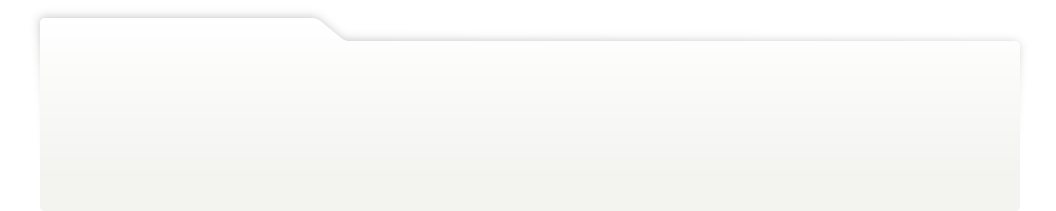
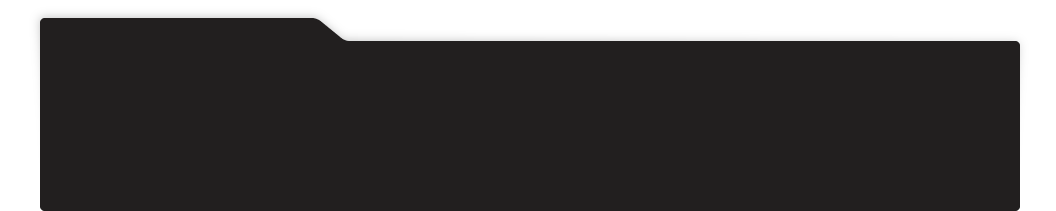
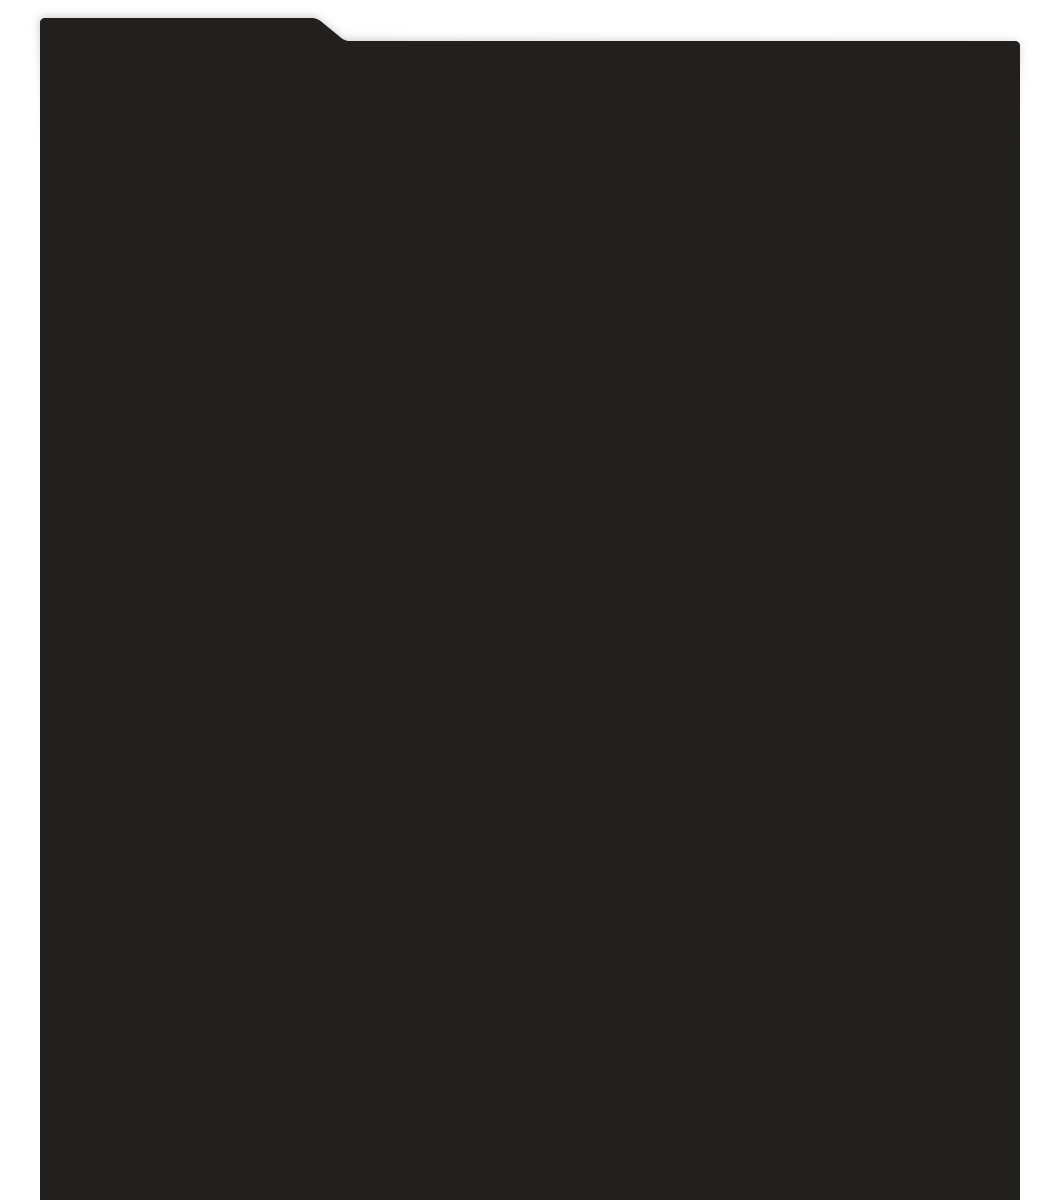
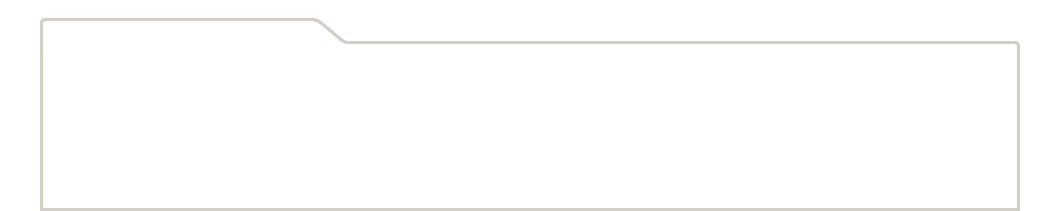
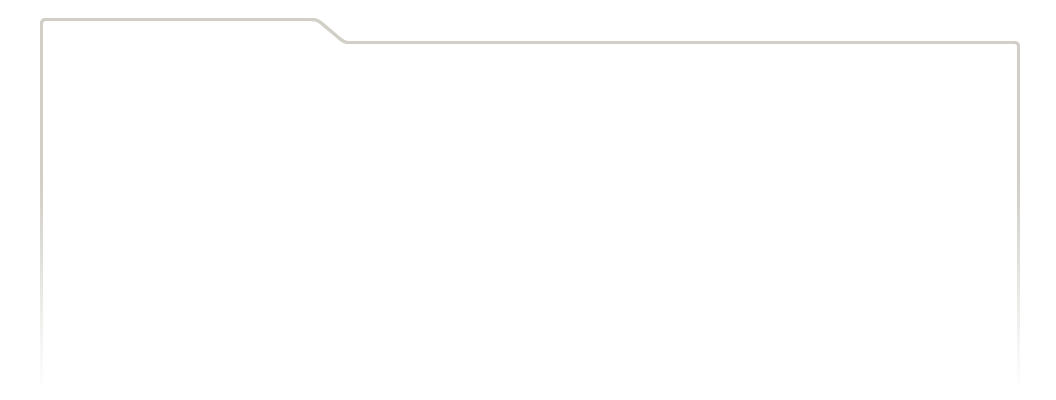
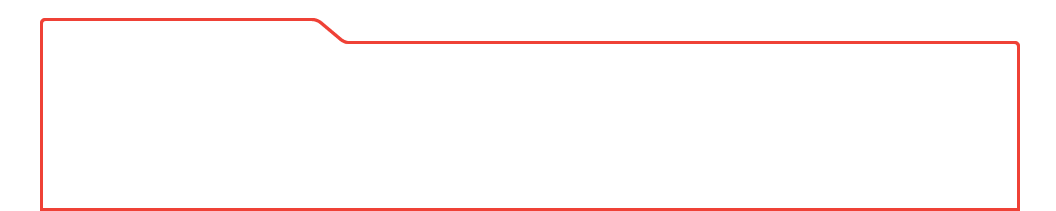
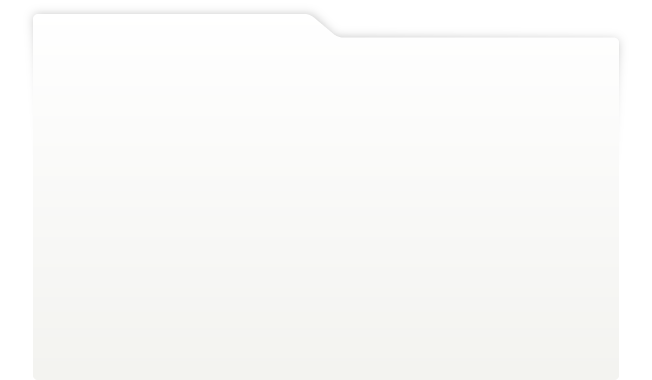
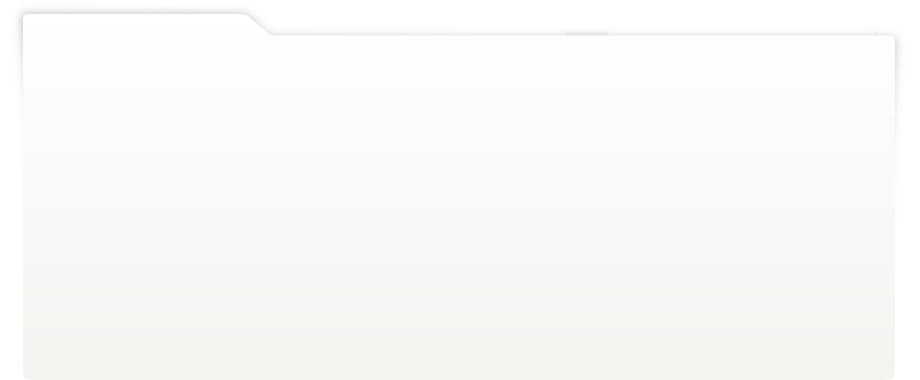
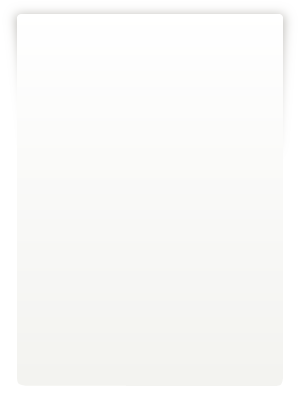
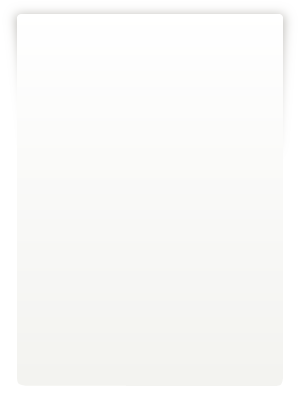
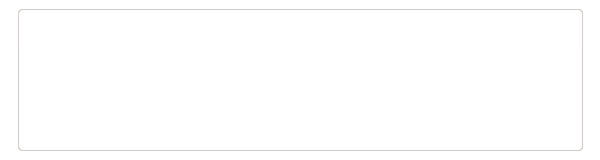
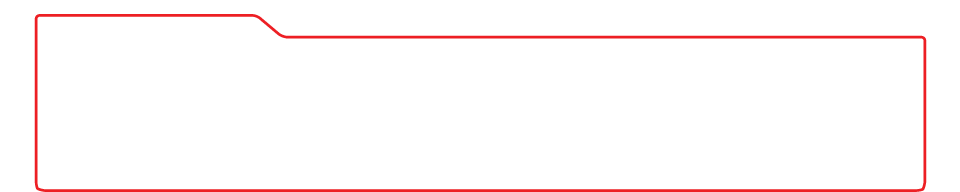
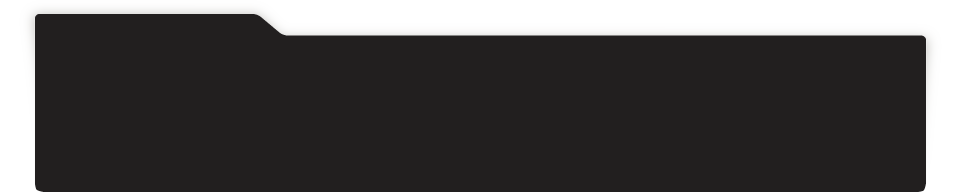
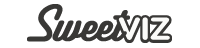
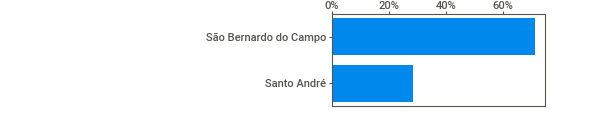
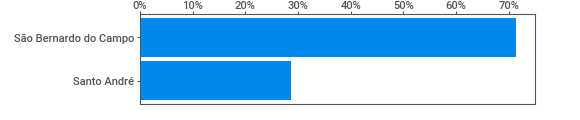
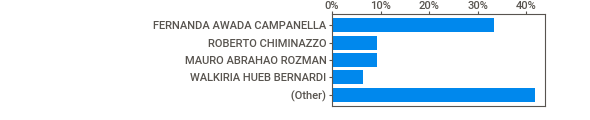
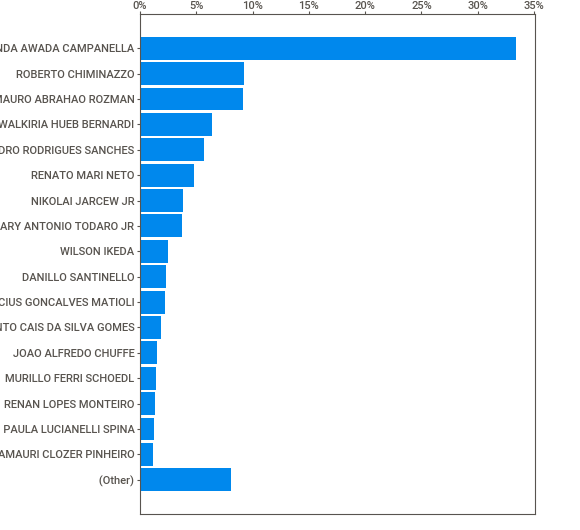
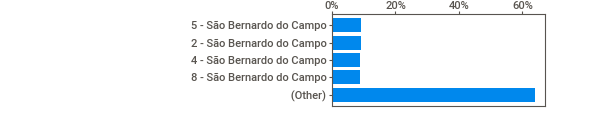
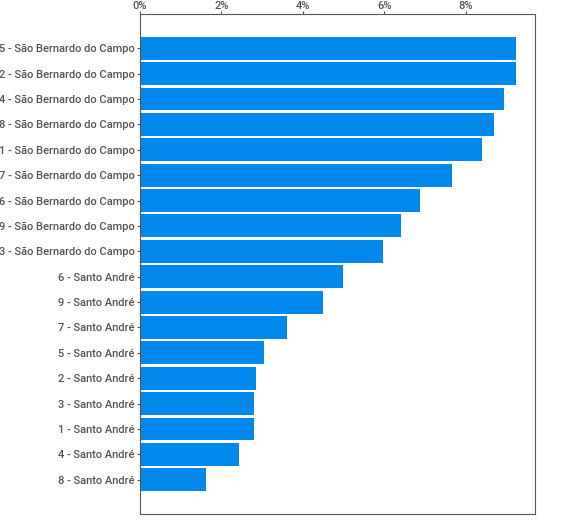
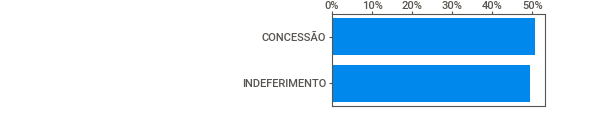
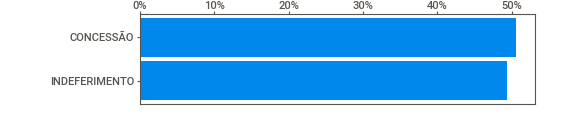
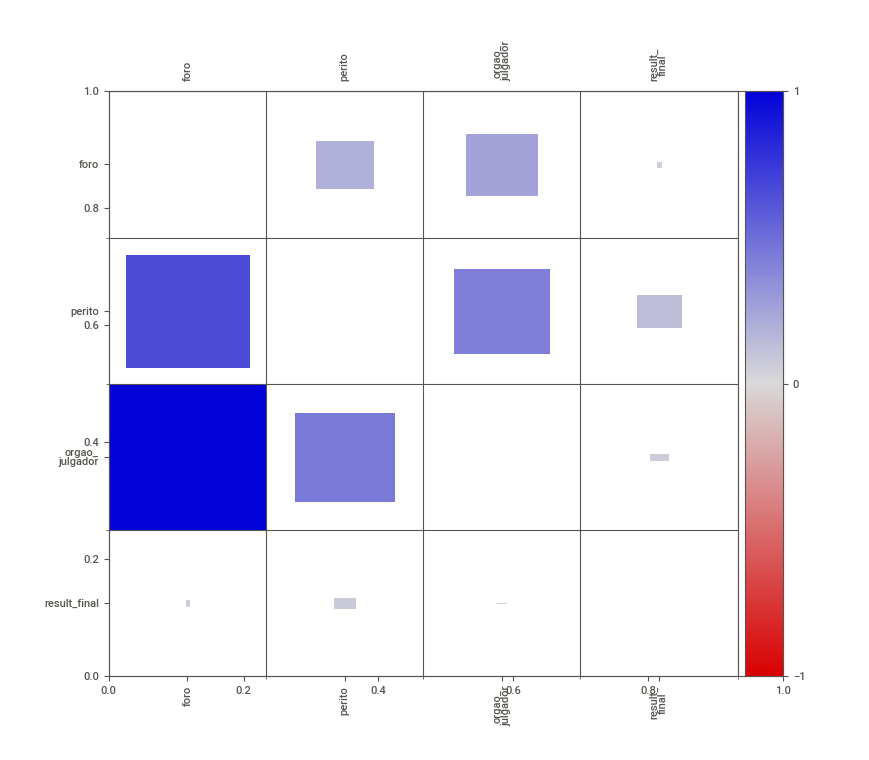
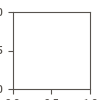

In [60]:
sweetviz.analyze(df_lupa_final).show_notebook()


In [61]:
# Mostra o nome das colunas do dataset
df_lupa_final.columns

Index(['foro', 'perito', 'orgao_julgador', 'advogado', 'result_final'], dtype='object')

In [62]:
# Verificar se há valores nulos
df_lupa_final.isnull().sum()

,0
foro,0
perito,0
orgao_julgador,0
advogado,0
result_final,0


In [63]:
# Se houver algum valor nulo substituir por None
df_lupa_final = df_lupa_final.fillna('None')

result_final
CONCESSÃO        0.506027
INDEFERIMENTO    0.493973
Name: proportion, dtype: float64


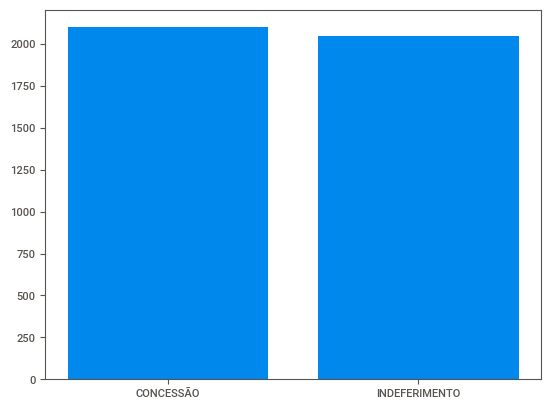

In [64]:
# Mostra o total de amostras por classe da variável dependente (target)
df_lupa_final['result_final'].value_counts()
print(df_lupa_final['result_final'].value_counts(normalize=True))

plt.bar(df_lupa_final['result_final'].value_counts().index, df_lupa_final['result_final'].value_counts())
plt.show()

### 2.3. Pré-processamento dos dados

#### 2.3.1. Separação em Treino e Teste

In [65]:
# Separa os dados de treino e teste com proporção de 80/20
from sklearn.model_selection import train_test_split

# Assumindo que 'df_lupa_final' é o dataframe
# Separar as variáveis independentes (X) e a variável dependente (y)
X = df_lupa_final.drop('result_final', axis=1)
y = df_lupa_final['result_final']

# Dividir os dados em conjuntos de treinamento e teste (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"X: {X_train.shape}")
print(f"y: {X_test.shape}")

X: (3318, 4)
y: (830, 4)


In [66]:
feature_names = X_train.columns.tolist()
print(feature_names)

['foro', 'perito', 'orgao_julgador', 'advogado']


In [67]:
# Confere a proporção das classes nos dados de treino e de teste
print("Proporção de classes em y_train:", y_train.shape,'\n')
print(y_train.value_counts(normalize=True))

print("\nProporção de classes em y_test:", y_test.shape,'\n')
print(y_test.value_counts(normalize=True))

Proporção de classes em y_train: (3318,) 

result_final
CONCESSÃO        0.506028
INDEFERIMENTO    0.493972
Name: proportion, dtype: float64

Proporção de classes em y_test: (830,) 

result_final
CONCESSÃO        0.506024
INDEFERIMENTO    0.493976
Name: proportion, dtype: float64


In [68]:
# Verificar as dimensões do dataset de treino e  teste
print('Dimensões de X_train = ', X_train.shape)
print('Dimensões de X_test = ', X_test.shape)
print('Dimensões de y_train = ', y_train.shape)
print('Dimensões de y_test = ', y_test.shape)

Dimensões de X_train =  (3318, 4)
Dimensões de X_test =  (830, 4)
Dimensões de y_train =  (3318,)
Dimensões de y_test =  (830,)


In [69]:
print('Amostras de treino = ', y_train.shape[0])
y_train.value_counts(normalize = True)

Amostras de treino =  3318


,proportion
result_final,
CONCESSÃO,0.506028
INDEFERIMENTO,0.493972


In [70]:
print('Amostras de teste = ', y_test.shape[0])
y_test.value_counts(normalize = True)

Amostras de teste =  830


,proportion
result_final,
CONCESSÃO,0.506024
INDEFERIMENTO,0.493976


#### 2.3.2 Codificação das variáveis independentes

In [71]:
# Codificar a variável independente 'advogado' com o FeatureHasher e as variáveis independentes 'foro', 'perito', 'orgao_julgador' com o onehotencoder

from sklearn.feature_extraction import FeatureHasher

# Cria o FeatureHasher para a variável 'advogado'
hasher = FeatureHasher(n_features=10, input_type='string') # Ajuste n_features conforme necessário

# Aplica o FeatureHasher à coluna 'advogado' nos dados de treino e teste
# Remodela a coluna 'advogado' para uma lista de listas para torná-la compatível com FeatureHasher
X_train_advogado_hashed = hasher.transform(X_train['advogado'].values.reshape(-1, 1))
X_test_advogado_hashed = hasher.transform(X_test['advogado'].values.reshape(-1, 1))


# Converte as matrizes esparsas resultantes para arrays densos
X_train_advogado_hashed = X_train_advogado_hashed.toarray()
X_test_advogado_hashed = X_test_advogado_hashed.toarray()

# Agora você precisa combinar as features hasheadas com as outras features codificadas
# com OneHotEncoder
# Criar o onehotencoder para ajustar apenas os dados de treino.
from sklearn.preprocessing import OneHotEncoder

# Cria o OneHotEncoder com handle_unknown='ignore'
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Ajusta o encoder APENAS aos dados de treino
encoder.fit(X_train)

# Transforma os dados de treino e teste usando o encoder ajustado
X_train_encoded = encoder.transform(X_train)
X_test_encoded = encoder.transform(X_test)

X_train_encoded.shape, X_test_encoded.shape


# Combine as features hasheadas com as outras features codificadas
# (assumindo que X_train_encoded e X_test_encoded são os resultados do OneHotEncoder)
import numpy as np

X_train_final = np.concatenate((X_train_encoded, X_train_advogado_hashed), axis=1)
X_test_final = np.concatenate((X_test_encoded, X_test_advogado_hashed), axis=1)

print(X_train_final.shape)
X_test_final.shape

(3318, 859)


(830, 859)

#### 2.3.3 Codificação da variável dependente

In [72]:
# Codificação da variável target 'result_final' usando Label Encoding
from sklearn.preprocessing import LabelEncoder

# Inicializa o LabelEncoder
le = LabelEncoder()

# Ajusta o le APENAS aos dados de treino
le.fit(y_train)

# Transforma os dados de treino e teste usando o le ajustado
y_train_encoded = le.transform(y_train)
y_test_encoded = le.transform(y_test)


### 2.4. - Modelagem - Classificação

#### 2.4.1. Regressão Logística


In [73]:
# Instanciar modelo de regressão logística e Treinar o modelo, lembrando de aplicar o encoder nos dados de treinamento

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Instanciar o modelo de regressão logística
model = LogisticRegression(random_state=42)

# Treinar o modelo com os dados de treinamento codificados
model.fit(X_train_final, y_train_encoded)

# Fazer previsões com os dados de teste
y_pred = model.predict(X_test_final)


In [74]:
# Avaliar o modelo
print(classification_report(y_test_encoded, y_pred))
accuracy = model.score(X_test_final, y_test_encoded)
print("Acurácia do modelo:", accuracy)


              precision    recall  f1-score   support

           0       0.67      0.64      0.65       420
           1       0.65      0.67      0.66       410

    accuracy                           0.66       830
   macro avg       0.66      0.66      0.66       830
weighted avg       0.66      0.66      0.66       830

Acurácia do modelo: 0.6566265060240963


In [75]:
# Verificar o f1_score do modelo
from sklearn.metrics import f1_score

# Calcular o f1_score
f1 = f1_score(y_test_encoded, y_pred, average='weighted')
print("F1-score do modelo:", f1)


F1-score do modelo: 0.6565671877596487


##### 2.4.1.1 Ajuste de Hiperparâmetro

In [76]:
# Ajuste de hiperparâmetros para o modelo de regressão logística com GridSearchCV
# No intuito de melhorar o seu desempenho.

from sklearn.model_selection import GridSearchCV

# # Define o grid de hiperparâmetros a serem testados
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularização inversa
    'solver': ['liblinear', 'saga'], # Algoritmos de otimização mais rápidos e que convergem melhor com menos iterações
    'max_iter': [1000] # Aumenta o número máximo de iterações para garantir a convergência.
}

# Cria o modelo de Regressão Logística
model = LogisticRegression(random_state=42)

# Cria o objeto GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)


# Ajusta o GridSearchCV aos dados de treinamento
grid_search.fit(X_train_final, y_train_encoded)

# Imprime os melhores hiperparâmetros e a melhor pontuação
print("Melhores hiperparâmetros:", grid_search.best_params_)
print("Melhor pontuação F1:", grid_search.best_score_)

# Usa o melhor modelo para fazer as previsões
y_pred = grid_search.best_estimator_.predict(X_test_final)

# Avalia o modelo
print(classification_report(y_test_encoded, y_pred))
accuracy = grid_search.best_estimator_.score(X_test_final, y_test_encoded)
print("Acurácia do modelo:", accuracy)

# Calcula o f1_score
f1 = f1_score(y_test_encoded, y_pred, average='weighted')
print("F1-score do modelo:", f1)

Melhores hiperparâmetros: {'C': 1, 'max_iter': 1000, 'solver': 'liblinear'}
Melhor pontuação F1: 0.6635950459430865
              precision    recall  f1-score   support

           0       0.67      0.64      0.66       420
           1       0.65      0.67      0.66       410

    accuracy                           0.66       830
   macro avg       0.66      0.66      0.66       830
weighted avg       0.66      0.66      0.66       830

Acurácia do modelo: 0.6578313253012048
F1-score do modelo: 0.6577836407179328


##### 2.4.1.2 Validação Cruzada

In [77]:
# Validação cruzada do modelo de regressão logística
from sklearn.model_selection import cross_val_score

# Define o número de folds para a validação cruzada
k = 5  # Número de folds (divisões do conjunto de dados)

# Realiza a validação cruzada com o melhor modelo encontrado pelo GridSearchCV
# O parâmetro scoring é definido como 'f1_weighted' para avaliar o desempenho baseado no f1-score ponderado
cv_scores = cross_val_score(grid_search.best_estimator_, X_train_final, y_train_encoded, cv=k, scoring='f1_weighted')

# Imprime os scores de cada fold
print("Scores de cada fold:", cv_scores)

# Imprime a média e o desvio padrão dos scores
print(f"Acurácia média da validação cruzada (F1-score ponderado): {cv_scores.mean():.4f}")
print(f"Desvio padrão da validação cruzada (F1-score ponderado): {cv_scores.std():.4f}")

Scores de cada fold: [0.66564748 0.67921032 0.65972871 0.64375056 0.66963816]
Acurácia média da validação cruzada (F1-score ponderado): 0.6636
Desvio padrão da validação cruzada (F1-score ponderado): 0.0118


##### 2.4.1.3 Matriz de Confusão

Matriz de Confusão:
[[270 150]
 [134 276]]


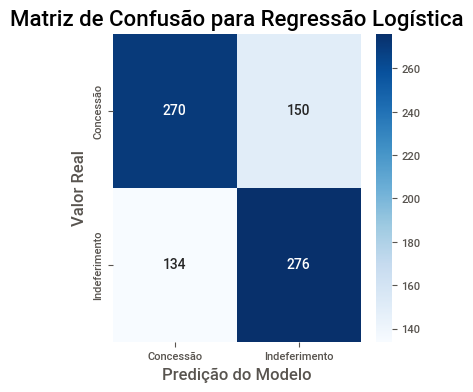

In [78]:
# Mostrar a Matriz de Confusão do modelo de Regressão Logística
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Matriz de Confusão
cm = confusion_matrix(y_test_encoded, y_pred)

# Exibir a Matriz de Confusão
print("Matriz de Confusão:")
print(cm)

# Plotar a Matriz de Confusão
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Concessão', 'Indeferimento'],
            yticklabels=['Concessão', 'Indeferimento'])
plt.title('Matriz de Confusão para Regressão Logística', fontsize=16)
plt.xlabel('Predição do Modelo', fontsize=12)
plt.ylabel('Valor Real', fontsize=12)
plt.show()


#### 2.4.2. KNN

In [79]:
# Instanciar modelo KNN e Treinar o modelo, lembrando de aplicar o encoder nos dados de treinamento

from sklearn.neighbors import KNeighborsClassifier

# Instanciar o modelo KNN
knn_model = KNeighborsClassifier(n_neighbors=5) # Define o número de vizinhos (ajuste conforme necessário)

# Treinar o modelo com os dados de treinamento codificados
knn_model.fit(X_train_final, y_train_encoded)

KNeighborsClassifier()

In [80]:
# Fazer previsões com os dados de teste
knn_y_pred = knn_model.predict(X_test_final)

In [81]:
## Avaliar o modelo
print(classification_report(y_test_encoded, knn_y_pred))
accuracy = knn_model.score(X_test_final, y_test_encoded)
print("Acurácia do modelo:", accuracy)

              precision    recall  f1-score   support

           0       0.62      0.62      0.62       420
           1       0.61      0.61      0.61       410

    accuracy                           0.62       830
   macro avg       0.62      0.62      0.62       830
weighted avg       0.62      0.62      0.62       830

Acurácia do modelo: 0.6156626506024097


In [82]:
# Verificar o f1_score do modelo
from sklearn.metrics import f1_score

# Calcular o f1_score
f1_knn = f1_score(y_test_encoded, knn_y_pred, average='weighted')
print("F1-score do modelo kNN:", f1_knn)

F1-score do modelo kNN: 0.6156408871612018


##### 2.4.2.1 Ajuste de Hiperparâmetro

In [83]:
# Define o grid de hiperparâmetros para o KNN

import warnings
warnings.filterwarnings('ignore')

param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],  # Número de vizinhos
    'weights': ['uniform', 'distance'],  # Tipo de ponderação
    'metric': ['euclidean', 'manhattan'] # Métrica de distância
}

# Cria o modelo KNN
knn_model = KNeighborsClassifier()

# Cria o GridSearchCV para o KNN
grid_search_knn = GridSearchCV(knn_model, param_grid_knn, cv=5, scoring='f1_weighted')

# Treina o GridSearchCV com os dados de treinamento
grid_search_knn.fit(X_train_final, y_train_encoded)

# Imprime os melhores hiperparâmetros e a melhor pontuação para o KNN
print("Melhores hiperparâmetros para KNN:", grid_search_knn.best_params_)
print("Melhor pontuação F1 para KNN:", grid_search_knn.best_score_)

# Usa o melhor modelo para fazer previsões
knn_y_pred = grid_search_knn.best_estimator_.predict(X_test_final)

# Avalia o modelo KNN após o ajuste de hiperparâmetros
print(classification_report(y_test_encoded, knn_y_pred))
knn_accuracy = grid_search_knn.best_estimator_.score(X_test_final, y_test_encoded)
print("Acurácia do modelo kNN após ajuste de hiperparâmetros:", knn_accuracy)

# Calcula o f1_score para o KNN
f1_knn = f1_score(y_test_encoded, knn_y_pred, average='weighted')
print("F1-score do modelo kNN após ajuste de hiperparâmetros:", f1_knn)

Melhores hiperparâmetros para KNN: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}
Melhor pontuação F1 para KNN: 0.62567104374834
              precision    recall  f1-score   support

           0       0.62      0.65      0.63       420
           1       0.62      0.59      0.61       410

    accuracy                           0.62       830
   macro avg       0.62      0.62      0.62       830
weighted avg       0.62      0.62      0.62       830

Acurácia do modelo kNN após ajuste de hiperparâmetros: 0.6204819277108434
F1-score do modelo kNN após ajuste de hiperparâmetros: 0.620178008340802


##### 2.4.2.2 Validação Cruzada

In [84]:
# Validação cruzada do modelo KNN

# Define o número de folds para a validação cruzada
k = 5  # Número de folds (divisões do conjunto de dados)

# Realiza a validação cruzada com o melhor modelo KNN encontrado pelo GridSearchCV
# O parâmetro scoring é definido como 'f1_weighted' para avaliar o desempenho baseado no f1-score ponderado
cv_scores_knn = cross_val_score(grid_search_knn.best_estimator_, X_train_final, y_train_encoded, cv=k, scoring='f1_weighted')

# Imprime os scores de cada fold para o KNN
print("Scores de cada fold para KNN:", cv_scores_knn)

# Imprime a média e o desvio padrão dos scores para o KNN
print(f"Acurácia média da validação cruzada para KNN (F1-score ponderado): {cv_scores_knn.mean():.4f}")
print(f"Desvio padrão da validação cruzada para KNN (F1-score ponderado): {cv_scores_knn.std():.4f}")


Scores de cada fold para KNN: [0.60241299 0.62912421 0.66103463 0.63631866 0.59946472]
Acurácia média da validação cruzada para KNN (F1-score ponderado): 0.6257
Desvio padrão da validação cruzada para KNN (F1-score ponderado): 0.0228


##### 2.4.2.3 Matriz de Confusão

Matriz de Confusão para KNN:
[[272 148]
 [167 243]]


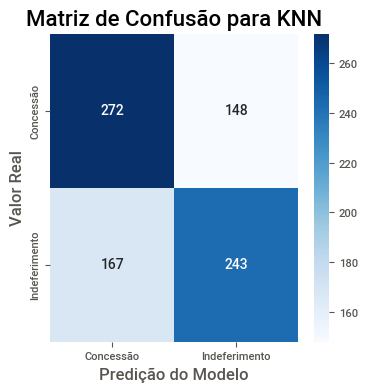

In [85]:
# Mostrar a Matriz de Confusão do modelo KNN
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Matriz de Confusão para o KNN
cm_knn = confusion_matrix(y_test_encoded, knn_y_pred)

# Exibir a Matriz de Confusão para o KNN
print("Matriz de Confusão para KNN:")
print(cm_knn)

# Plotar a Matriz de Confusão para o KNN
plt.figure(figsize=(4, 4))
sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Concessão', 'Indeferimento'],
            yticklabels=['Concessão', 'Indeferimento'])
plt.title('Matriz de Confusão para KNN', fontsize=16)
plt.xlabel('Predição do Modelo', fontsize=12)
plt.ylabel('Valor Real', fontsize=12)
plt.show()

#### 2.4.3. Árvore de Decisão

In [87]:
# Instanciar modelo de àrvore de Decisão e Treinar o modelo, lembrando de aplicar o encoder nos dados de treinamento

# Instanciar o modelo de árvore de decisão
tree_model = DecisionTreeClassifier(random_state=42)

# Treinar o modelo com os dados de treinamento codificados
tree_model.fit(X_train_final, y_train_encoded)

# Fazer previsões com os dados de teste
tree_y_pred = tree_model.predict(X_test_final)

# Avaliar o modelo
print(classification_report(y_test_encoded, tree_y_pred))
tree_accuracy = tree_model.score(X_test_final, y_test_encoded)
print("Acurácia do modelo de árvore de decisão:", tree_accuracy)

# Verificar o f1_score do modelo
f1_tree = f1_score(y_test_encoded, tree_y_pred, average='weighted')
print("F1-score do modelo de árvore de decisão:", f1_tree)

              precision    recall  f1-score   support

           0       0.65      0.67      0.66       420
           1       0.65      0.63      0.64       410

    accuracy                           0.65       830
   macro avg       0.65      0.65      0.65       830
weighted avg       0.65      0.65      0.65       830

Acurácia do modelo de árvore de decisão: 0.6542168674698795
F1-score do modelo de árvore de decisão: 0.6540666735241344


In [88]:
# Verificar o f1_score do modelo
from sklearn.metrics import f1_score

# Calcular o f1_score
f1_tree = f1_score(y_test_encoded, tree_y_pred, average='weighted')
print("F1-score do modelo de árvore de decisão:", f1_tree)

F1-score do modelo de árvore de decisão: 0.6540666735241344


##### 2.4.3.1 Ajuste de Hiperparâmetro

In [89]:
# Define o grid de hiperparâmetros para a Árvore de Decisão
param_grid_tree = {
    'criterion': ['gini', 'entropy'],  # Função de critério para medir a qualidade da divisão
    'max_depth': [None, 10, 20, 30],  # Profundidade máxima da árvore
    'min_samples_split': [2, 5, 10],  # Número mínimo de amostras para dividir um nó
    'min_samples_leaf': [1, 2, 4]  # Número mínimo de amostras em uma folha
}

# Cria o modelo de Árvore de Decisão
tree_model = DecisionTreeClassifier(random_state=42)

# Cria o GridSearchCV para a Árvore de Decisão
grid_search_tree = GridSearchCV(tree_model, param_grid_tree, cv=5, scoring='f1_weighted')

# Treina o GridSearchCV com os dados de treinamento
grid_search_tree.fit(X_train_final, y_train_encoded)

# Imprime os melhores hiperparâmetros e a melhor pontuação para a Árvore de Decisão
print("Melhores hiperparâmetros para Árvore de Decisão:", grid_search_tree.best_params_)
print("Melhor pontuação F1 para Árvore de Decisão:", grid_search_tree.best_score_)

# Usa o melhor modelo para fazer previsões
tree_y_pred = grid_search_tree.best_estimator_.predict(X_test_final)

# Avalia o modelo de Árvore de Decisão após o ajuste de hiperparâmetros
print(classification_report(y_test_encoded, tree_y_pred))
tree_accuracy = grid_search_tree.best_estimator_.score(X_test_final, y_test_encoded)
print("Acurácia do modelo de árvore de decisão após ajuste de hiperparâmetros:", tree_accuracy)

# Calcula o f1_score para a Árvore de Decisão
f1_tree = f1_score(y_test_encoded, tree_y_pred, average='weighted')
print("F1-score do modelo de árvore de decisão após ajuste de hiperparâmetros:", f1_tree)

Melhores hiperparâmetros para Árvore de Decisão: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Melhor pontuação F1 para Árvore de Decisão: 0.6624841406137043
              precision    recall  f1-score   support

           0       0.70      0.51      0.59       420
           1       0.61      0.78      0.68       410

    accuracy                           0.64       830
   macro avg       0.65      0.64      0.64       830
weighted avg       0.65      0.64      0.63       830

Acurácia do modelo de árvore de decisão após ajuste de hiperparâmetros: 0.6409638554216868
F1-score do modelo de árvore de decisão após ajuste de hiperparâmetros: 0.6344492575771281


##### 2.4.3.2 Validação Cruzada

In [90]:
# Validação cruzada do modelo de árvore de decisão

# Define o número de folds para a validação cruzada
k = 5  # Número de folds (divisões do conjunto de dados)

# Realiza a validação cruzada com o melhor modelo de árvore de decisão encontrado pelo GridSearchCV
# O parâmetro scoring é definido como 'f1_weighted' para avaliar o desempenho baseado no f1-score ponderado
cv_scores_tree = cross_val_score(grid_search_tree.best_estimator_, X_train_final, y_train_encoded, cv=k, scoring='f1_weighted')

# Imprime os scores de cada fold para a árvore de decisão
print("Scores de cada fold para Árvore de Decisão:", cv_scores_tree)

# Imprime a média e o desvio padrão dos scores para a árvore de decisão
print(f"Acurácia média da validação cruzada para Árvore de Decisão (F1-score ponderado): {cv_scores_tree.mean():.4f}")
print(f"Desvio padrão da validação cruzada para Árvore de Decisão (F1-score ponderado): {cv_scores_tree.std():.4f}")

Scores de cada fold para Árvore de Decisão: [0.646646   0.65484112 0.67768433 0.66642083 0.66682842]
Acurácia média da validação cruzada para Árvore de Decisão (F1-score ponderado): 0.6625
Desvio padrão da validação cruzada para Árvore de Decisão (F1-score ponderado): 0.0107


##### 2.4.3.3 Matriz de Confusão

Matriz de Confusão para Árvore de Decisão:
[[213 207]
 [ 91 319]]


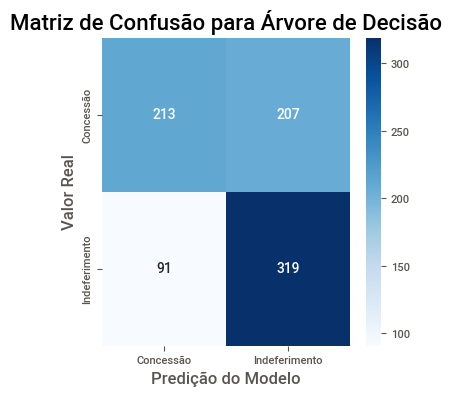

In [91]:
# Mostrar a Matriz de Confusão do modelo de Árvore de Decisão

cm_tree = confusion_matrix(y_test_encoded, tree_y_pred)

# Exibir a Matriz de Confusão para a Árvore de Decisão
print("Matriz de Confusão para Árvore de Decisão:")
print(cm_tree)

# Plotar a Matriz de Confusão para a Árvore de Decisão
plt.figure(figsize=(4, 4))
sns.heatmap(cm_tree, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Concessão', 'Indeferimento'],
            yticklabels=['Concessão', 'Indeferimento'])
plt.title('Matriz de Confusão para Árvore de Decisão', fontsize=16)
plt.xlabel('Predição do Modelo', fontsize=12)
plt.ylabel('Valor Real', fontsize=12)
plt.show()

#### 2.4.4. Random Forest

In [92]:
# Instanciar modelo de Random Forest e Treinar o modelo

from sklearn.ensemble import RandomForestClassifier

# Instanciar o modelo Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Treinar o modelo com os dados de treinamento codificados
rf_model.fit(X_train_final, y_train_encoded)

# Fazer previsões com os dados de teste
rf_y_pred = rf_model.predict(X_test_final)

# Avaliar o modelo
print(classification_report(y_test_encoded, rf_y_pred))
rf_accuracy = rf_model.score(X_test_final, y_test_encoded)
print("Acurácia do modelo Random Forest:", rf_accuracy)

# Verificar o f1_score do modelo
f1_rf = f1_score(y_test_encoded, rf_y_pred, average='weighted')
print("F1-score do modelo Random Forest:", f1_rf)

              precision    recall  f1-score   support

           0       0.67      0.62      0.65       420
           1       0.64      0.69      0.66       410

    accuracy                           0.65       830
   macro avg       0.66      0.65      0.65       830
weighted avg       0.66      0.65      0.65       830

Acurácia do modelo Random Forest: 0.6542168674698795
F1-score do modelo Random Forest: 0.6538898983703731


##### 2.4.4.1 Ajuste de Hiperparâmetro

In [93]:
# Define o grid de hiperparâmetros para o Random Forest
param_grid_rf = {
    'n_estimators': [50, 100],  # Número de árvores na floresta (reduzido)
    'max_depth': [None, 10],  # Profundidade máxima de cada árvore (reduzido)
    'min_samples_split': [2, 5],  # Número mínimo de amostras para dividir um nó (reduzido)
    'min_samples_leaf': [1, 2],  # Número mínimo de amostras em uma folha (reduzido)
    # 'max_features': ['sqrt', 'log2'] # Número de recursos a serem considerados em cada divisão (opcionalmente remova ou reduza)
}

# Cria o modelo de Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Cria o GridSearchCV para o Random Forest
grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=3, scoring='f1_weighted', n_jobs=-1) # reduz cv para 3 e usa todos os núcleos

# Treina o GridSearchCV com os dados de treinamento
grid_search_rf.fit(X_train_final, y_train_encoded)

# Imprime os melhores hiperparâmetros e a melhor pontuação para o Random Forest
print("Melhores hiperparâmetros para Random Forest:", grid_search_rf.best_params_)
print("Melhor pontuação F1 para Random Forest:", grid_search_rf.best_score_)

# Usa o melhor modelo para fazer previsões
rf_y_pred = grid_search_rf.predict(X_test_final)

# Avalia o modelo de Random Forest após o ajuste de hiperparâmetros
print(classification_report(y_test_encoded, rf_y_pred))
rf_accuracy = grid_search_rf.score(X_test_final, y_test_encoded)
print("Acurácia do modelo Random Forest após ajuste de hiperparâmetros:", rf_accuracy)

# Calcula o f1_score para o Random Forest
f1_rf = f1_score(y_test_encoded, rf_y_pred, average='weighted')
print("F1-score do modelo Random Forest após ajuste de hiperparâmetros:", f1_rf)

Melhores hiperparâmetros para Random Forest: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
Melhor pontuação F1 para Random Forest: 0.6629603880114633
              precision    recall  f1-score   support

           0       0.68      0.65      0.66       420
           1       0.66      0.69      0.67       410

    accuracy                           0.67       830
   macro avg       0.67      0.67      0.67       830
weighted avg       0.67      0.67      0.67       830

Acurácia do modelo Random Forest após ajuste de hiperparâmetros: 0.666182210211132
F1-score do modelo Random Forest após ajuste de hiperparâmetros: 0.666182210211132


##### 2.4.4.2 Validação Cruzada

In [94]:
# Validação cruzada do modelo de Random Forest

# Define o número de folds para a validação cruzada
k = 5  # Número de folds (divisões do conjunto de dados)

# Realiza a validação cruzada com o melhor modelo de Random Forest encontrado pelo GridSearchCV
# O parâmetro scoring é definido como 'f1_weighted' para avaliar o desempenho baseado no f1-score ponderado
cv_scores_rf = cross_val_score(grid_search_rf.best_estimator_, X_train_final, y_train_encoded, cv=k, scoring='f1_weighted')

# Imprime os scores de cada fold para o Random Forest
print("Scores de cada fold para Random Forest:", cv_scores_rf)

# Imprime a média e o desvio padrão dos scores para o Random Forest
print(f"Acurácia média da validação cruzada para Random Forest (F1-score ponderado): {cv_scores_rf.mean():.4f}")
print(f"Desvio padrão da validação cruzada para Random Forest (F1-score ponderado): {cv_scores_rf.std():.4f}")

Scores de cada fold para Random Forest: [0.66566265 0.6747106  0.65194339 0.65708509 0.66814174]
Acurácia média da validação cruzada para Random Forest (F1-score ponderado): 0.6635
Desvio padrão da validação cruzada para Random Forest (F1-score ponderado): 0.0081


##### 2.4.4.3 Matriz de Confusão

Matriz de Confusão para Random Forest:
[[272 148]
 [129 281]]


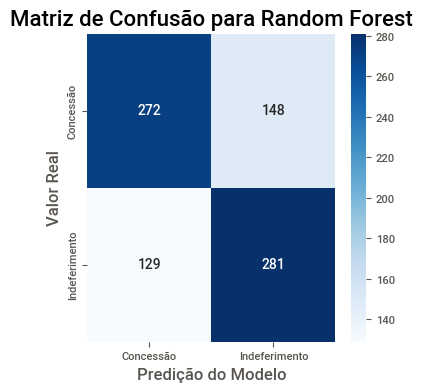

In [95]:
# Mostrar a Matriz de Confusão do modelo de Random Forest

cm_rf = confusion_matrix(y_test_encoded, rf_y_pred)

# Exibir a Matriz de Confusão para o Random Forest
print("Matriz de Confusão para Random Forest:")
print(cm_rf)

# Plotar a Matriz de Confusão para o Random Forest
plt.figure(figsize=(4, 4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Concessão', 'Indeferimento'],
            yticklabels=['Concessão', 'Indeferimento'])
plt.title('Matriz de Confusão para Random Forest', fontsize=16)
plt.xlabel('Predição do Modelo', fontsize=12)
plt.ylabel('Valor Real', fontsize=12)
plt.show()

#### 2.4.5. XGBoost

In [96]:
# Instanciar modelo de XGBoost e Treinar o modelo
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Instanciar o modelo XGBoost
xgb_model = xgb.XGBClassifier(random_state=42)

# Treinar o modelo com os dados de treinamento codificados
xgb_model.fit(X_train_final, y_train_encoded)

# Fazer previsões com os dados de teste
xgb_y_pred = xgb_model.predict(X_test_final)

# Avaliar o modelo
print(classification_report(y_test_encoded, xgb_y_pred))
xgb_accuracy = accuracy_score(y_test_encoded, xgb_y_pred) # Usar accuracy_score
print(f"Acurácia do modelo XGBoost: {xgb_accuracy}")

# Calcular o f1-score
f1_xgb = f1_score(y_test_encoded, xgb_y_pred, average='weighted')
print(f"F1-score do modelo XGBoost: {f1_xgb}")

              precision    recall  f1-score   support

           0       0.68      0.60      0.64       420
           1       0.63      0.71      0.67       410

    accuracy                           0.65       830
   macro avg       0.66      0.65      0.65       830
weighted avg       0.66      0.65      0.65       830

Acurácia do modelo XGBoost: 0.6542168674698795
F1-score do modelo XGBoost: 0.6533422641902166


##### 2.4.5.1 Ajuste de Hiperparâmetro

In [97]:
# Define o grid de hiperparâmetros para o XGBoost (reduzido para otimizar tempo)
param_grid_xgb = {
    'n_estimators': [50, 100],  # Número de árvores (reduzido)
    'max_depth': [3, 5],  # Profundidade máxima das árvores (reduzido)
    'learning_rate': [0.1, 0.01], # Taxa de aprendizado (reduzido)
}

# Cria o modelo XGBoost
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss') # use_label_encoder=False para evitar aviso

# Cria o GridSearchCV para o XGBoost
grid_search_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=3, scoring='f1_weighted', n_jobs=-1) # cv reduzido para 3

# Treina o GridSearchCV com os dados de treinamento
grid_search_xgb.fit(X_train_final, y_train_encoded) # Usa y_train_encoded já codificado

# Imprime os melhores hiperparâmetros e a melhor pontuação para o XGBoost
print("Melhores hiperparâmetros para XGBoost:", grid_search_xgb.best_params_)
print("Melhor pontuação F1 para XGBoost:", grid_search_xgb.best_score_)

# Usa o melhor modelo para fazer previsões
xgb_y_pred = grid_search_xgb.predict(X_test_final)

# Avalia o modelo XGBoost após o ajuste de hiperparâmetros
print(classification_report(y_test_encoded, xgb_y_pred))
xgb_accuracy = grid_search_xgb.score(X_test_final, y_test_encoded)
print("Acurácia do modelo XGBoost após ajuste de hiperparâmetros:", xgb_accuracy)

# Calcula o f1_score para o XGBoost
f1_xgb = f1_score(y_test_encoded, xgb_y_pred, average='weighted')
print("F1-score do modelo XGBoost após ajuste de hiperparâmetros:", f1_xgb)

Melhores hiperparâmetros para XGBoost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Melhor pontuação F1 para XGBoost: 0.6647862430176051
              precision    recall  f1-score   support

           0       0.68      0.56      0.62       420
           1       0.62      0.73      0.67       410

    accuracy                           0.65       830
   macro avg       0.65      0.65      0.64       830
weighted avg       0.65      0.65      0.64       830

Acurácia do modelo XGBoost após ajuste de hiperparâmetros: 0.6434749648819494
F1-score do modelo XGBoost após ajuste de hiperparâmetros: 0.6434749648819494


##### 2.4.5.2 Validação Cruzada

In [98]:
# Validação cruzada do modelo XGBoost

# Define o número de folds para a validação cruzada
k = 5  # Número de folds (divisões do conjunto de dados)

# Realiza a validação cruzada com o melhor modelo XGBoost encontrado pelo GridSearchCV
# O parâmetro scoring é definido como 'f1_weighted' para avaliar o desempenho baseado no f1-score ponderado
cv_scores_xgb = cross_val_score(grid_search_xgb.best_estimator_, X_train_final, y_train_encoded, cv=k, scoring='f1_weighted')

# Imprime os scores de cada fold para o XGBoost
print("Scores de cada fold para XGBoost:", cv_scores_xgb)

# Imprime a média e o desvio padrão dos scores para o XGBoost
print(f"Acurácia média da validação cruzada para XGBoost (F1-score ponderado): {cv_scores_xgb.mean():.4f}")
print(f"Desvio padrão da validação cruzada para XGBoost (F1-score ponderado): {cv_scores_xgb.std():.4f}")

Scores de cada fold para XGBoost: [0.67714871 0.68366877 0.67761726 0.66710973 0.66536567]
Acurácia média da validação cruzada para XGBoost (F1-score ponderado): 0.6742
Desvio padrão da validação cruzada para XGBoost (F1-score ponderado): 0.0069


##### 2.4.5.3 Matriz de Confusão

Matriz de Confusão para XGBoost:
[[237 183]
 [111 299]]


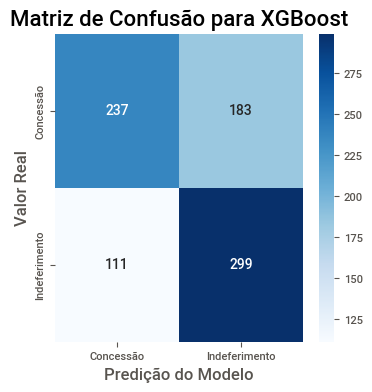

In [99]:
# Mostrar a Matriz de Confusão do modelo XGBoost

cm_xgb = confusion_matrix(y_test_encoded, xgb_y_pred)

# Exibir a Matriz de Confusão para o XGBoost
print("Matriz de Confusão para XGBoost:")
print(cm_xgb)

# Plotar a Matriz de Confusão para o XGBoost
plt.figure(figsize=(4, 4))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Concessão', 'Indeferimento'],
            yticklabels=['Concessão', 'Indeferimento'])
plt.title('Matriz de Confusão para XGBoost', fontsize=16)
plt.xlabel('Predição do Modelo', fontsize=12)
plt.ylabel('Valor Real', fontsize=12)
plt.show()

### 2.5 - Interpretação do Modelo

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


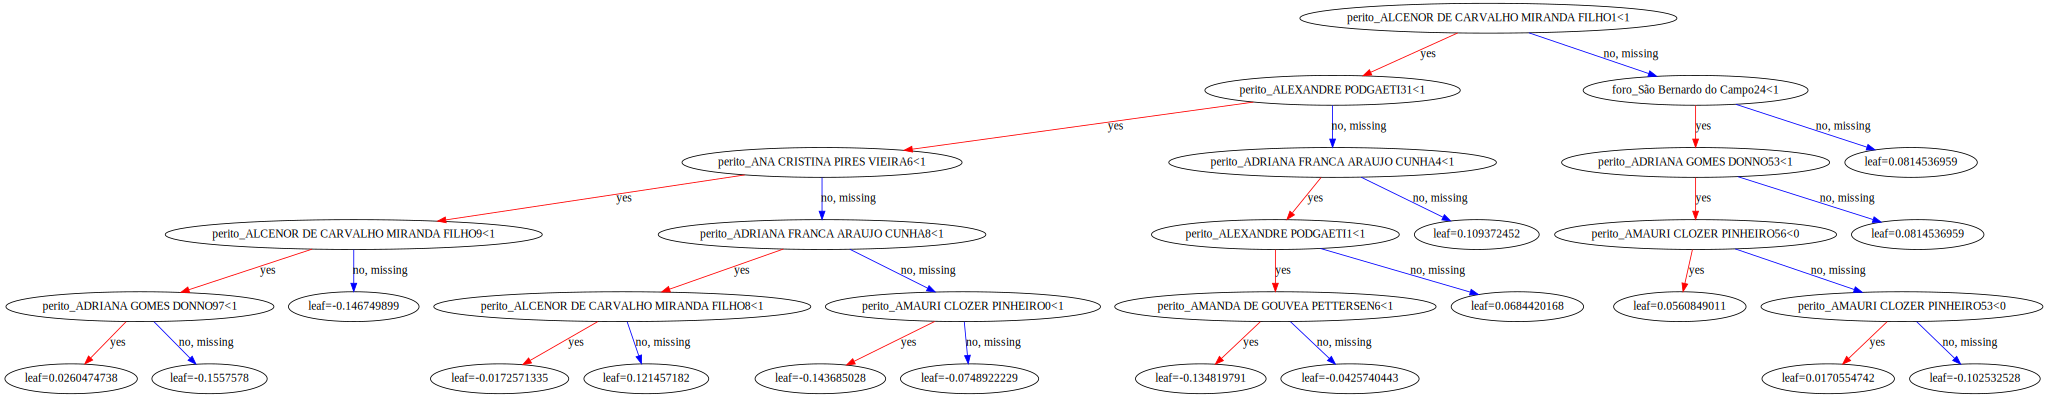

In [100]:
# Interpretação do modelo XGBoost usando graphviz
!apt-get install graphviz -y
!pip install graphviz

import graphviz
from xgboost import plot_tree, XGBClassifier
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder

# Obter uma árvore do modelo XGBoost (a primeira árvore, no índice 0)
best_xgb_tree = grid_search_xgb.best_estimator_.get_booster().get_dump(dump_format='dot')[0]
#print(best_xgb_tree)

# Criar um objeto graphviz a partir da string da árvore
# xgb_dot_data = graphviz.Source(grid_search_xgb.best_estimator_.get_booster().get_dump(dump_format='dot')[0])
xgb_dot_data = graphviz.Source(best_xgb_tree)

# Obtenha os nomes das features após o OneHotEncoding
feature_names = encoder.get_feature_names_out(X.columns)

# Criar um dicionário para mapear índices de features para nomes
feature_name_map = {i: name for i, name in enumerate(feature_names)}

# Substituir os índices de features no código DOT pelo nome das features correspondentes.
# Primeiro, copie o conteúdo de xgb_dot_data.source para uma nova variável.
modified_dot_source = xgb_dot_data.source

# Execute um loop pelos índices numéricos no código DOT
for i in range(len(feature_names)):
  # Substitua todos os índices numéricos pelo nome da característica
  modified_dot_source = modified_dot_source.replace(f'f{i}', feature_name_map[i])

# Atualize o conteúdo do objeto graphviz com o código DOT modificado.
xgb_dot_data = graphviz.Source(modified_dot_source)

# Visualizar a árvore
xgb_dot_data.render("xgboost_tree", format="png", cleanup=True)  # Salva a árvore em um arquivo PNG
xgb_dot_data.view()  # Abre a imagem no navegador
xgb_dot_data


##3. Análise do Dataset "final" - Rodada 2

### 3.1. Carrega o dataset

In [109]:
# Ler o arquivo diretamente do link usando pandas
df_lupa_final = pd.read_excel('https://raw.githubusercontent.com/isavitskii/LUPA/main/datasets/4_df_lupa_Rodada2_item-3-1.xlsx')

# Mostrar as primeiras linhas do dataframe
df_lupa_final['cbo'] = df_lupa_final['cbo'].astype(str)

df_lupa_final.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3222 entries, 0 to 3221
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   cbo             3222 non-null   object
 1   cid             3222 non-null   object
 2   foro            3222 non-null   object
 3   orgao_julgador  3222 non-null   object
 4   perito          3222 non-null   object
 5   advogado        3222 non-null   object
 6   result_final    3222 non-null   object
dtypes: object(7)
memory usage: 176.3+ KB


In [111]:
# Mostra o nome das colunas do dataset
df_lupa_final.columns

Index(['cbo', 'cid', 'foro', 'orgao_julgador', 'perito', 'advogado',
       'result_final'],
      dtype='object')

###3.2 Análise exploratória do dataset limpo (após ETL)

In [112]:
!pip install sweetviz # Install the sweetviz library
import sweetviz # Now you can import sweetviz


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 64.8 MB/s eta 0:00:00


                                             |          | [  0%]   00:00 -> (? left)


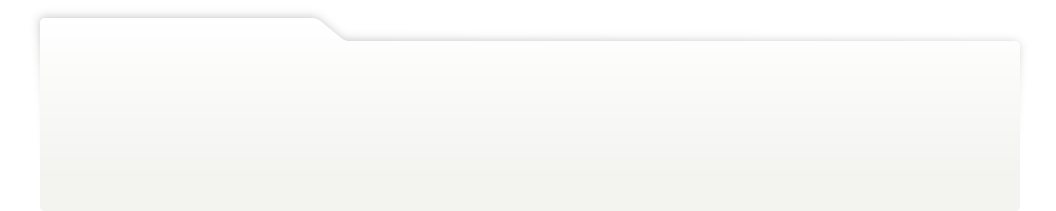
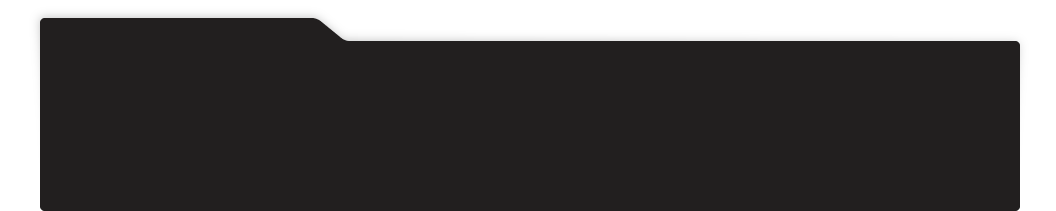
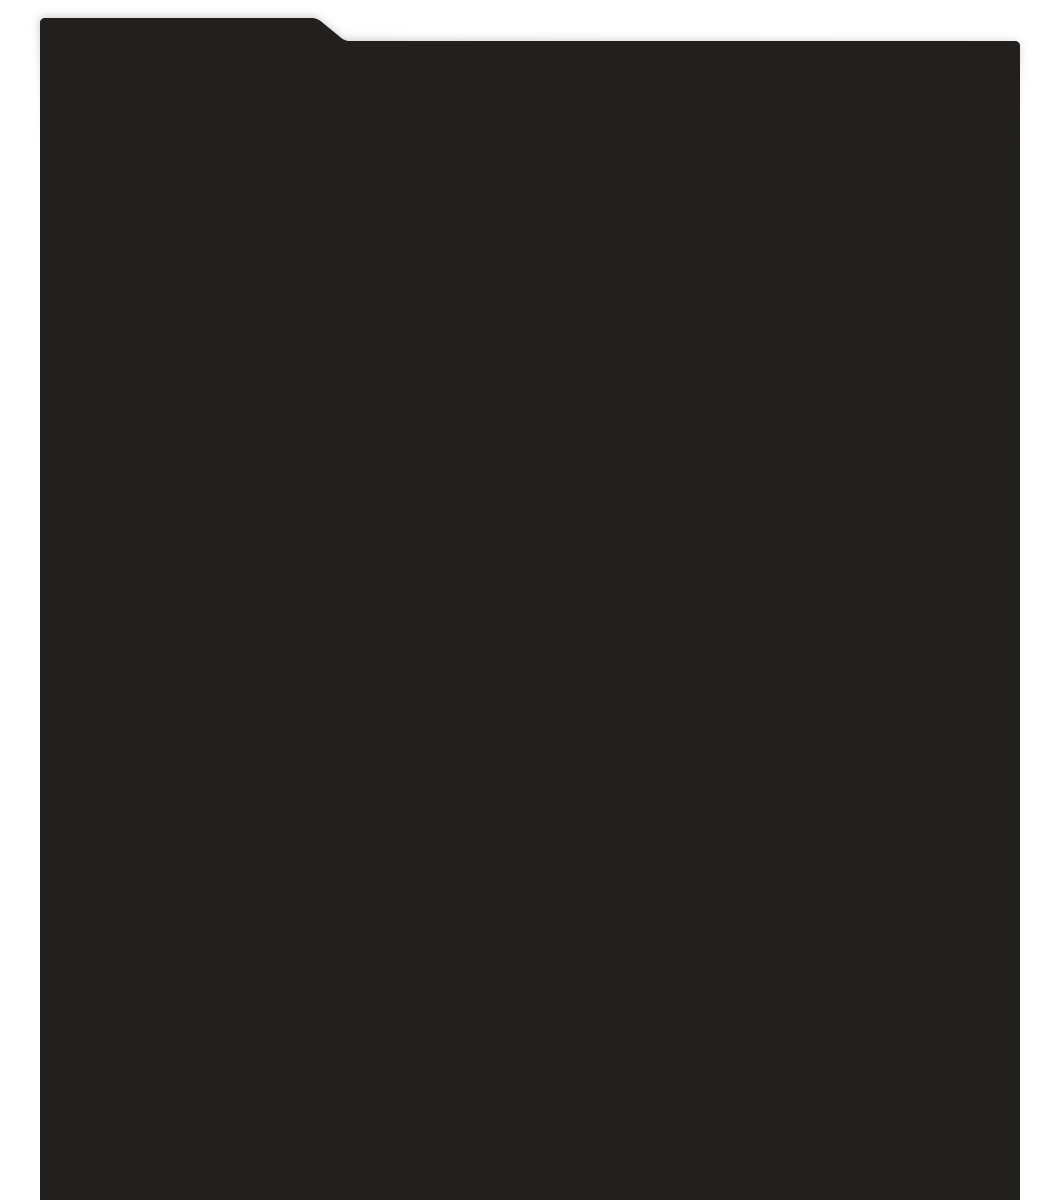
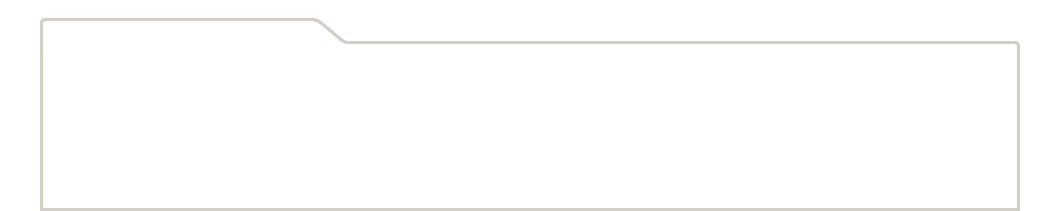
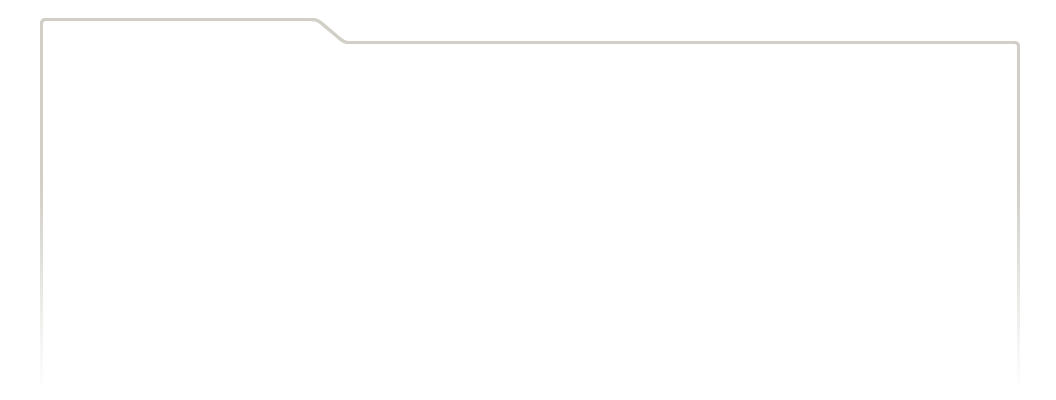
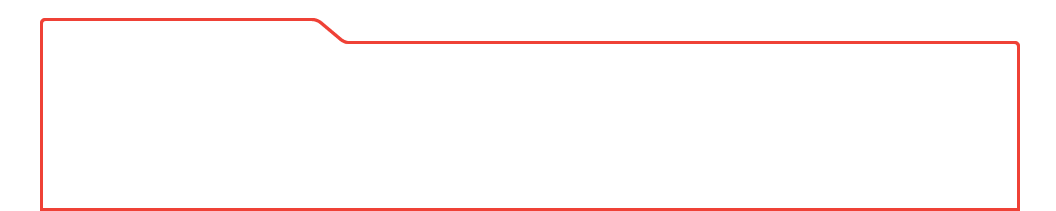
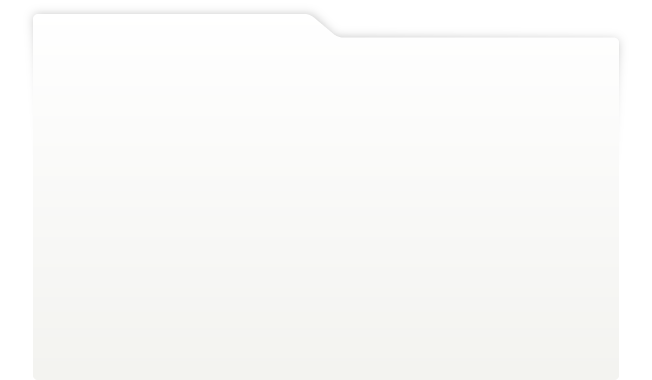
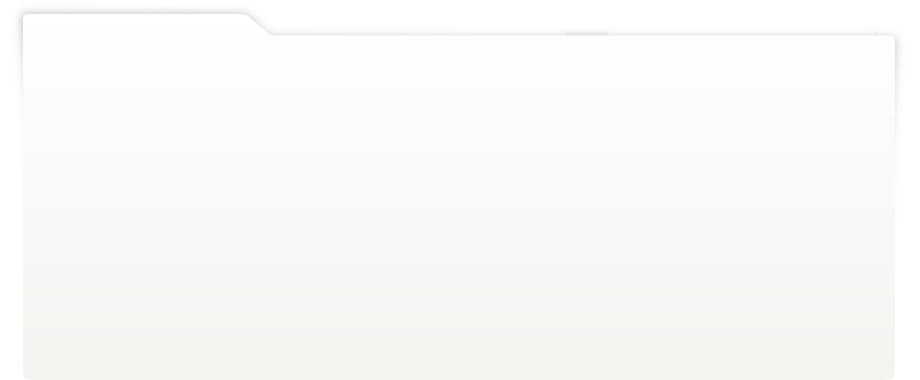
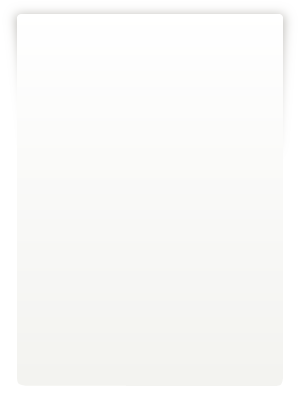
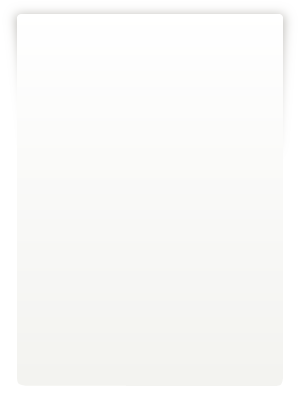
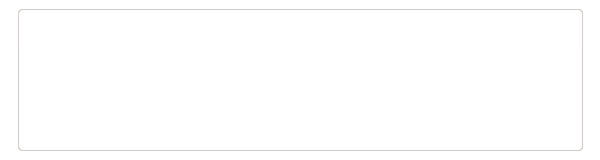
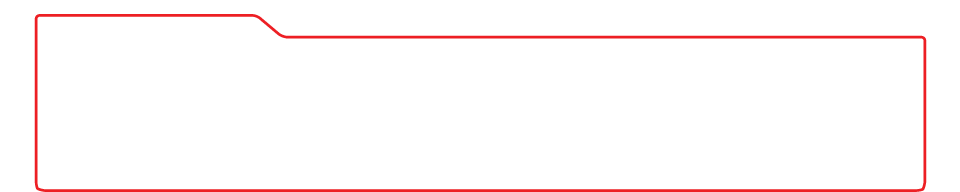
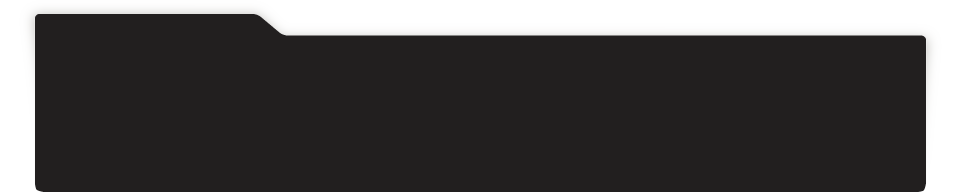
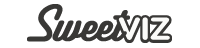
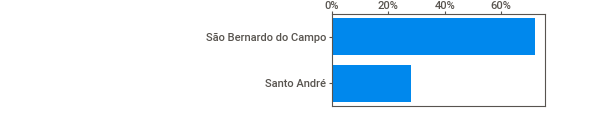
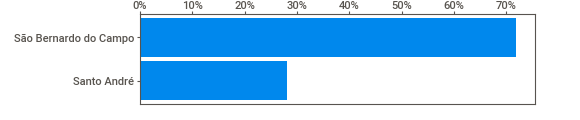
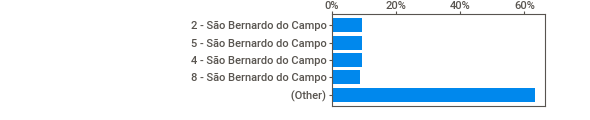
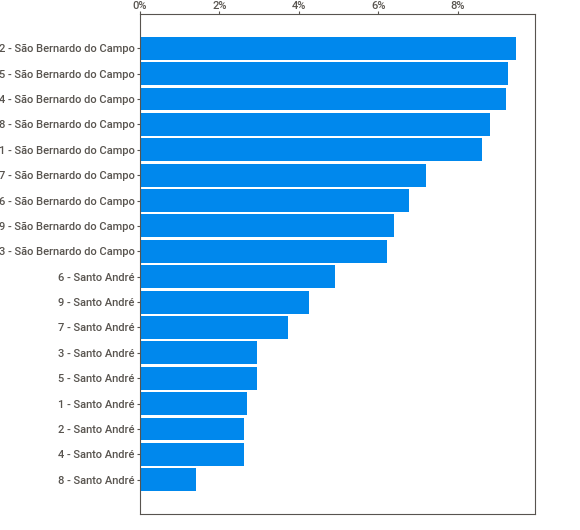
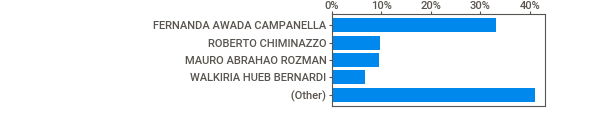
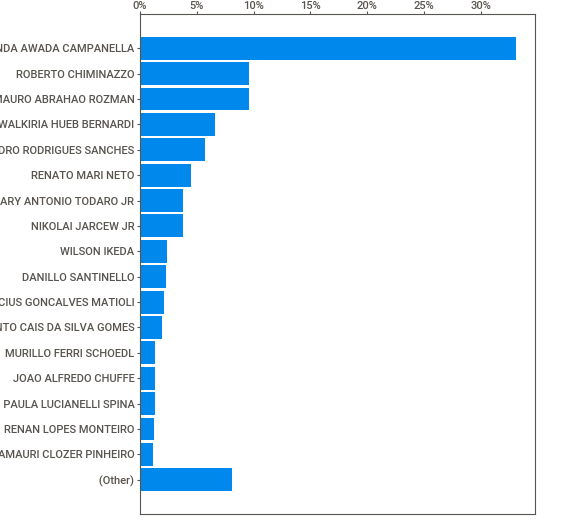
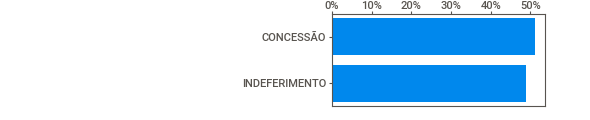
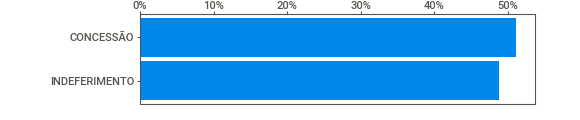
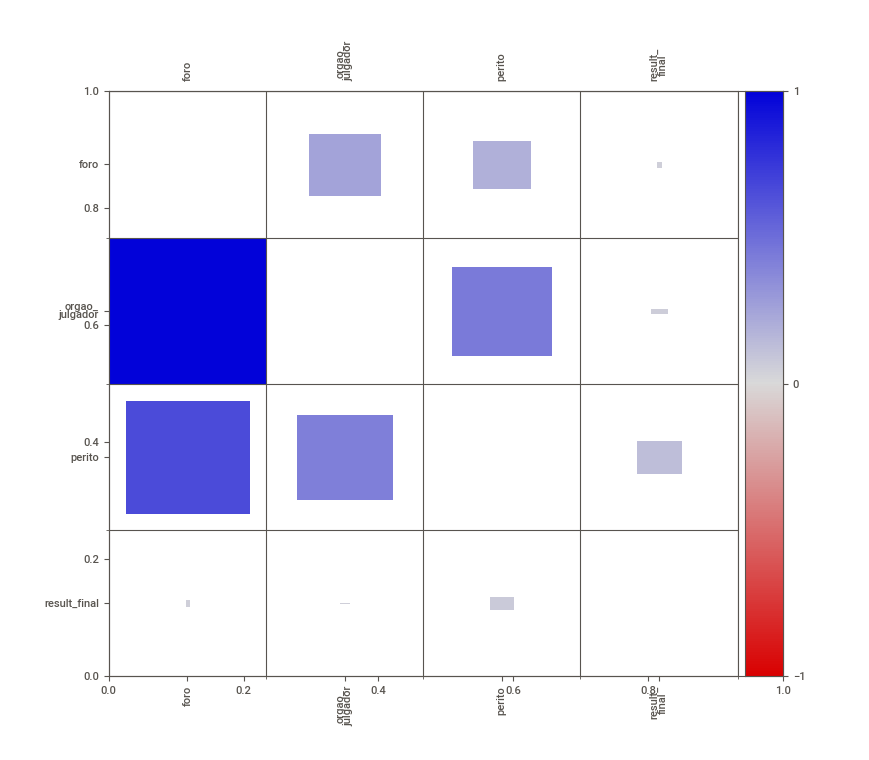
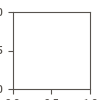

In [113]:
sweetviz.analyze(df_lupa_final).show_notebook()


In [114]:
# Mostra o nome das colunas do dataset
df_lupa_final.columns

Index(['cbo', 'cid', 'foro', 'orgao_julgador', 'perito', 'advogado',
       'result_final'],
      dtype='object')

In [115]:
# Verificar se há valores nulos
df_lupa_final.isnull().sum()

,0
cbo,0
cid,0
foro,0
orgao_julgador,0
perito,0
advogado,0
result_final,0


In [116]:
# Se houver algum valor nulo substituir por None
df_lupa_final = df_lupa_final.fillna('None')

result_final
CONCESSÃO        0.511484
INDEFERIMENTO    0.488516
Name: proportion, dtype: float64


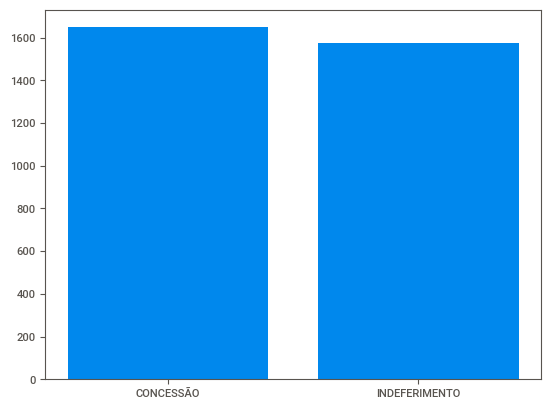

In [117]:
# Mostra o total de amostras por classe da variável dependente (target)
df_lupa_final['result_final'].value_counts()
print(df_lupa_final['result_final'].value_counts(normalize=True))

plt.bar(df_lupa_final['result_final'].value_counts().index, df_lupa_final['result_final'].value_counts())
plt.show()

### 3.3. Pré-processamento dos dados

#### 3.3.1. Separação em Treino e Teste

In [118]:
# Separa os dados de treino e teste com proporção de 80/20
from sklearn.model_selection import train_test_split

# Assumindo que 'df_lupa_final' é o dataframe
# Separar as variáveis independentes (X) e a variável dependente (y)
X = df_lupa_final.drop(['foro','result_final'], axis=1)
y = df_lupa_final['result_final']

# Dividir os dados em conjuntos de treinamento e teste (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"X: {X_train.shape}")
print(f"y: {X_test.shape}")

type(X_train)

X: (2577, 5)
y: (645, 5)


pandas.core.frame.DataFrame

In [119]:
feature_names = X_train.columns.tolist()
print(feature_names)

['cbo', 'cid', 'orgao_julgador', 'perito', 'advogado']


In [120]:
# Confere a proporção das classes nos dados de treino e de teste
print("Proporção de classes em y_train:", y_train.shape,'\n')
print(y_train.value_counts(normalize=True))

print("\nProporção de classes em y_test:", y_test.shape,'\n')
print(y_test.value_counts(normalize=True))

Proporção de classes em y_train: (2577,) 

result_final
CONCESSÃO        0.511447
INDEFERIMENTO    0.488553
Name: proportion, dtype: float64

Proporção de classes em y_test: (645,) 

result_final
CONCESSÃO        0.511628
INDEFERIMENTO    0.488372
Name: proportion, dtype: float64


In [121]:
# Verificar as dimensões do dataset de treino e  teste
print('Dimensões de X_train = ', X_train.shape)
print('Dimensões de X_test = ', X_test.shape)
print('Dimensões de y_train = ', y_train.shape)
print('Dimensões de y_test = ', y_test.shape)

Dimensões de X_train =  (2577, 5)
Dimensões de X_test =  (645, 5)
Dimensões de y_train =  (2577,)
Dimensões de y_test =  (645,)


In [122]:
print('Amostras de treino = ', y_train.shape[0])
y_train.value_counts(normalize = True)

Amostras de treino =  2577


,proportion
result_final,
CONCESSÃO,0.511447
INDEFERIMENTO,0.488553


In [123]:
print('Amostras de teste = ', y_test.shape[0])
y_test.value_counts(normalize = True)

Amostras de teste =  645


,proportion
result_final,
CONCESSÃO,0.511628
INDEFERIMENTO,0.488372


#### 3.3.2 Codificação das variáveis independentes

In [124]:
# #TENTATIVA DE REDUZIR DIMENSIONALIDADE DA VARIÁVEL 'ADVOGADO' - MELHORA POUCO O DESEMPENHO MAS PERDE EXPLICABILIDADE
# # Codificar a variável independente 'advogado' com o FeatureHasher e as variáveis independentes 'foro', 'perito', 'orgao_julgador' com o onehotencoder

# from sklearn.feature_extraction import FeatureHasher

# # Cria o FeatureHasher para a variável 'advogado'
# hasher = FeatureHasher(n_features=200, input_type='string') # Ajuste n_features conforme necessário

# # Aplica o FeatureHasher à coluna 'advogado' nos dados de treino e teste
# # Remodela a coluna 'advogado' para uma lista de listas para torná-la compatível com FeatureHasher
# X_train_advogado_hashed = hasher.transform(X_train['advogado'].values.reshape(-1, 1))
# X_test_advogado_hashed = hasher.transform(X_test['advogado'].values.reshape(-1, 1))


# # Converte as matrizes esparsas resultantes para arrays densos
# X_train_advogado_hashed = X_train_advogado_hashed.toarray()
# X_test_advogado_hashed = X_test_advogado_hashed.toarray()

# # Agora você precisa combinar as features hasheadas com as outras features codificadas
# # com OneHotEncoder
# # Criar o onehotencoder para ajustar apenas os dados de treino.
# from sklearn.preprocessing import OneHotEncoder

# # Cria o OneHotEncoder com handle_unknown='ignore'
# encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# # Ajusta o encoder APENAS aos dados de treino
# encoder.fit(X_train.drop('advogado', axis=1))

# # Transforma os dados de treino e teste usando o encoder ajustado
# X_train_encoded = encoder.transform(X_train.drop('advogado', axis=1))
# X_test_encoded = encoder.transform(X_test.drop('advogado', axis=1))

# print(X_train_encoded.shape, X_test_encoded.shape)


# # Combine as features hasheadas com as outras features codificadas
# # (assumindo que X_train_encoded e X_test_encoded são os resultados do OneHotEncoder)
# import numpy as np

# X_train_final = np.concatenate((X_train_encoded, X_train_advogado_hashed), axis=1)
# X_test_final = np.concatenate((X_test_encoded, X_test_advogado_hashed), axis=1)

# #Guarda os nomes da features para explicabilidade do modelo
# # Gerar os nomes das features para o FeatureHasher
# n_features_hash = 200  # O mesmo valor de n_features usado no FeatureHasher
# advogado_feature_names = [f"advogado_hash_{i}" for i in range(n_features_hash)]

# # Gerar os nomes das features para o OneHotEncoder
# onehot_feature_names = encoder.get_feature_names_out(input_features=X_train.drop('advogado', axis=1).columns)

# # Combinar os nomes das features
# feature_names = np.concatenate((onehot_feature_names, advogado_feature_names))

# print(X_train_final.shape, X_test_final.shape)
# print(feature_names)


In [125]:
#TESTE SÓ DO ONEHOT ENCODER PARA TUDO
from sklearn.preprocessing import OneHotEncoder

# Cria o OneHotEncoder com handle_unknown='ignore'
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Ajusta o encoder APENAS aos dados de treino
encoder.fit(X_train)

# Transforma os dados de treino e teste usando o encoder ajustado
X_train_final = encoder.transform(X_train)
X_test_final = encoder.transform(X_test)

print(X_train_final.shape, X_test_final.shape)

feature_names = encoder.get_feature_names_out()

print(feature_names)


(2577, 1215) (645, 1215)
['cbo_111120' 'cbo_111250' 'cbo_122205' ...
 'advogado_Zerineide Adelaide Macedo Oliveira Galvez'
 'advogado_Zilda Maria Nobre Cavalcante'
 'advogado_Álvaro Barbosa da Silva Júnior']


#### 3.3.3 Codificação da variável dependente

In [126]:
# Codificação da variável target 'result_final' usando Label Encoding
from sklearn.preprocessing import LabelEncoder

# Inicializa o LabelEncoder
le = LabelEncoder()

# Ajusta o le APENAS aos dados de treino
le.fit(y_train)

# Transforma os dados de treino e teste usando o le ajustado
y_train_encoded = le.transform(y_train)
y_test_encoded = le.transform(y_test)

#Guarda os nomes das classes para explicabiliade do modelo
class_names = le.classes_
print("Classes Originais:", class_names)


Classes Originais: ['CONCESSÃO' 'INDEFERIMENTO']


### 3.4. - Modelagem - Classificação

#### 3.4.1. Regressão Logística


In [127]:
# Instanciar modelo de regressão logística e Treinar o modelo, lembrando de aplicar o encoder nos dados de treinamento

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Instanciar o modelo de regressão logística
model = LogisticRegression(random_state=42)

# Treinar o modelo com os dados de treinamento codificados
model.fit(X_train_final, y_train_encoded)

# Fazer previsões com os dados de teste
y_pred = model.predict(X_test_final)


In [128]:
# Avaliar o modelo
print(classification_report(y_test_encoded, y_pred))
accuracy = model.score(X_test_final, y_test_encoded)
print("Acurácia do modelo:", accuracy)

              precision    recall  f1-score   support

           0       0.70      0.71      0.71       330
           1       0.69      0.68      0.69       315

    accuracy                           0.70       645
   macro avg       0.70      0.70      0.70       645
weighted avg       0.70      0.70      0.70       645

Acurácia do modelo: 0.6961240310077519


In [129]:
# Verificar o f1_score do modelo
from sklearn.metrics import f1_score

# Calcular o f1_score
f1 = f1_score(y_test_encoded, y_pred, average='weighted')
print("F1-score do modelo:", f1)

F1-score do modelo: 0.6960318995202717


##### 3.4.1.1 Ajuste de Hiperparâmetro

In [130]:
# Ajuste de hiperparâmetros para o modelo de regressão logística com GridSearchCV
# No intuito de melhorar o seu desempenho.

from sklearn.model_selection import GridSearchCV

# # Define o grid de hiperparâmetros a serem testados
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularização inversa
    'solver': ['liblinear', 'saga'], # Algoritmos de otimização mais rápidos e que convergem melhor com menos iterações
    'max_iter': [1000] # Aumenta o número máximo de iterações para garantir a convergência.
}

# Cria o modelo de Regressão Logística
model = LogisticRegression(random_state=42)

# Cria o objeto GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)


# Ajusta o GridSearchCV aos dados de treinamento
grid_search.fit(X_train_final, y_train_encoded)

# Imprime os melhores hiperparâmetros e a melhor pontuação
print("Melhores hiperparâmetros:", grid_search.best_params_)
print("Melhor pontuação F1:", grid_search.best_score_)

# Usa o melhor modelo para fazer as previsões
y_pred = grid_search.best_estimator_.predict(X_test_final)

# Avalia o modelo
print(classification_report(y_test_encoded, y_pred))
accuracy = grid_search.best_estimator_.score(X_test_final, y_test_encoded)
print("Acurácia do modelo:", accuracy)

# Calcula o f1_score
f1 = f1_score(y_test_encoded, y_pred, average='weighted')
print("F1-score do modelo:", f1)

Melhores hiperparâmetros: {'C': 0.1, 'max_iter': 1000, 'solver': 'saga'}
Melhor pontuação F1: 0.6666723437878042
              precision    recall  f1-score   support

           0       0.73      0.72      0.72       330
           1       0.71      0.72      0.71       315

    accuracy                           0.72       645
   macro avg       0.72      0.72      0.72       645
weighted avg       0.72      0.72      0.72       645

Acurácia do modelo: 0.7178294573643411
F1-score do modelo: 0.7178593092144698


##### 3.4.1.2 Validação Cruzada

In [131]:
# Validação cruzada do modelo de regressão logística
from sklearn.model_selection import cross_val_score

# Define o número de folds para a validação cruzada
k = 5  # Número de folds (divisões do conjunto de dados)

# Realiza a validação cruzada com o melhor modelo encontrado pelo GridSearchCV
# O parâmetro scoring é definido como 'f1_weighted' para avaliar o desempenho baseado no f1-score ponderado
cv_scores = cross_val_score(grid_search.best_estimator_, X_train_final, y_train_encoded, cv=k, scoring='f1_weighted')

# Imprime os scores de cada fold
print("Scores de cada fold:", cv_scores)

# Imprime a média e o desvio padrão dos scores
print(f"Acurácia média da validação cruzada (F1-score ponderado): {cv_scores.mean():.4f}")
print(f"Desvio padrão da validação cruzada (F1-score ponderado): {cv_scores.std():.4f}")

Scores de cada fold: [0.66242516 0.7187247  0.64658329 0.64734522 0.65828335]
Acurácia média da validação cruzada (F1-score ponderado): 0.6667
Desvio padrão da validação cruzada (F1-score ponderado): 0.0267


##### 3.4.1.3 Matriz de Confusão

Matriz de Confusão:
[[237  93]
 [ 89 226]]


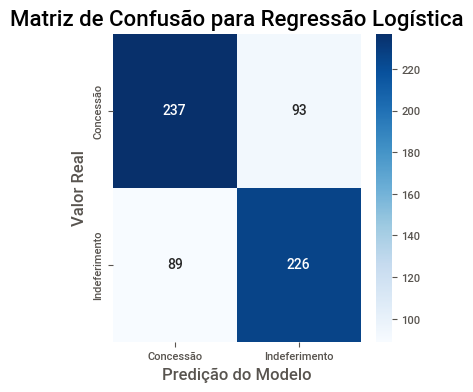

In [132]:
# Mostrar a Matriz de Confusão do modelo de Regressão Logística
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Matriz de Confusão
cm = confusion_matrix(y_test_encoded, y_pred)

# Exibir a Matriz de Confusão
print("Matriz de Confusão:")
print(cm)

# Plotar a Matriz de Confusão
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Concessão', 'Indeferimento'],
            yticklabels=['Concessão', 'Indeferimento'])
plt.title('Matriz de Confusão para Regressão Logística', fontsize=16)
plt.xlabel('Predição do Modelo', fontsize=12)
plt.ylabel('Valor Real', fontsize=12)
plt.show()


#### 3.4.2. KNN

In [133]:
# Instanciar modelo KNN e Treinar o modelo, lembrando de aplicar o encoder nos dados de treinamento

from sklearn.neighbors import KNeighborsClassifier

# Instanciar o modelo KNN
knn_model = KNeighborsClassifier(n_neighbors=5) # Define o número de vizinhos (ajuste conforme necessário)

# Treinar o modelo com os dados de treinamento codificados
knn_model.fit(X_train_final, y_train_encoded)

KNeighborsClassifier()

In [134]:
# Fazer previsões com os dados de teste
knn_y_pred = knn_model.predict(X_test_final)

In [135]:
## Avaliar o modelo
print(classification_report(y_test_encoded, knn_y_pred))
knn_accuracy = knn_model.score(X_test_final, y_test_encoded)
print("Acurácia do modelo kNN:", knn_accuracy)

              precision    recall  f1-score   support

           0       0.64      0.75      0.69       330
           1       0.68      0.57      0.62       315

    accuracy                           0.66       645
   macro avg       0.66      0.66      0.66       645
weighted avg       0.66      0.66      0.66       645

Acurácia do modelo kNN: 0.6604651162790698


In [136]:
# Verificar o f1_score do modelo
from sklearn.metrics import f1_score

# Calcular o f1_score
f1_knn = f1_score(y_test_encoded, knn_y_pred, average='weighted')
print("F1-score do modelo kNN:", f1_knn)

F1-score do modelo kNN: 0.6572855253947266


##### 3.4.2.1 Ajuste de Hiperparâmetro

In [137]:
# Define o grid de hiperparâmetros para o KNN

import warnings
warnings.filterwarnings('ignore')

param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],  # Número de vizinhos
    'weights': ['uniform', 'distance'],  # Tipo de ponderação
    'metric': ['euclidean', 'manhattan'] # Métrica de distância
}

# Cria o modelo KNN
knn_model = KNeighborsClassifier()

# Cria o GridSearchCV para o KNN
grid_search_knn = GridSearchCV(knn_model, param_grid_knn, cv=5, scoring='f1_weighted')

# Treina o GridSearchCV com os dados de treinamento
grid_search_knn.fit(X_train_final, y_train_encoded)

# Imprime os melhores hiperparâmetros e a melhor pontuação para o KNN
print("Melhores hiperparâmetros para KNN:", grid_search_knn.best_params_)
print("Melhor pontuação F1 para KNN:", grid_search_knn.best_score_)

# Usa o melhor modelo para fazer previsões
knn_y_pred = grid_search_knn.best_estimator_.predict(X_test_final)

# Avalia o modelo KNN após o ajuste de hiperparâmetros
print(classification_report(y_test_encoded, knn_y_pred))
knn_accuracy = grid_search_knn.best_estimator_.score(X_test_final, y_test_encoded)
print("Acurácia do modelo kNN após ajuste de hiperparâmetros:", knn_accuracy)

# Calcula o f1_score para o KNN
f1_knn = f1_score(y_test_encoded, knn_y_pred, average='weighted')
print("F1-score do modelo kNN após ajuste de hiperparâmetros:", f1_knn)

Melhores hiperparâmetros para KNN: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
Melhor pontuação F1 para KNN: 0.6136195929944757
              precision    recall  f1-score   support

           0       0.65      0.78      0.71       330
           1       0.71      0.56      0.62       315

    accuracy                           0.67       645
   macro avg       0.68      0.67      0.67       645
weighted avg       0.68      0.67      0.67       645

Acurácia do modelo kNN após ajuste de hiperparâmetros: 0.6728682170542636
F1-score do modelo kNN após ajuste de hiperparâmetros: 0.6682320323704526


##### 3.4.2.2 Validação Cruzada

In [138]:
# Validação cruzada do modelo KNN

# Define o número de folds para a validação cruzada
k = 5  # Número de folds (divisões do conjunto de dados)

# Realiza a validação cruzada com o melhor modelo KNN encontrado pelo GridSearchCV
# O parâmetro scoring é definido como 'f1_weighted' para avaliar o desempenho baseado no f1-score ponderado
cv_scores_knn = cross_val_score(grid_search_knn.best_estimator_, X_train_final, y_train_encoded, cv=k, scoring='f1_weighted')

# Imprime os scores de cada fold para o KNN
print("Scores de cada fold para KNN:", cv_scores_knn)

# Imprime a média e o desvio padrão dos scores para o KNN
print(f"Acurácia média da validação cruzada para KNN (F1-score ponderado): {cv_scores_knn.mean():.4f}")
print(f"Desvio padrão da validação cruzada para KNN (F1-score ponderado): {cv_scores_knn.std():.4f}")


Scores de cada fold para KNN: [0.6195895  0.61055665 0.63058302 0.62560875 0.58176004]
Acurácia média da validação cruzada para KNN (F1-score ponderado): 0.6136
Desvio padrão da validação cruzada para KNN (F1-score ponderado): 0.0173


##### 3.4.2.3 Matriz de Confusão

Matriz de Confusão para KNN:
[[259  71]
 [140 175]]


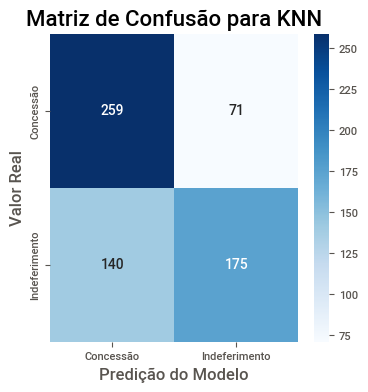

In [139]:
# Mostrar a Matriz de Confusão do modelo KNN
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Matriz de Confusão para o KNN
cm_knn = confusion_matrix(y_test_encoded, knn_y_pred)

# Exibir a Matriz de Confusão para o KNN
print("Matriz de Confusão para KNN:")
print(cm_knn)

# Plotar a Matriz de Confusão para o KNN
plt.figure(figsize=(4, 4))
sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Concessão', 'Indeferimento'],
            yticklabels=['Concessão', 'Indeferimento'])
plt.title('Matriz de Confusão para KNN', fontsize=16)
plt.xlabel('Predição do Modelo', fontsize=12)
plt.ylabel('Valor Real', fontsize=12)
plt.show()

#### 3.4.3. Árvore de Decisão

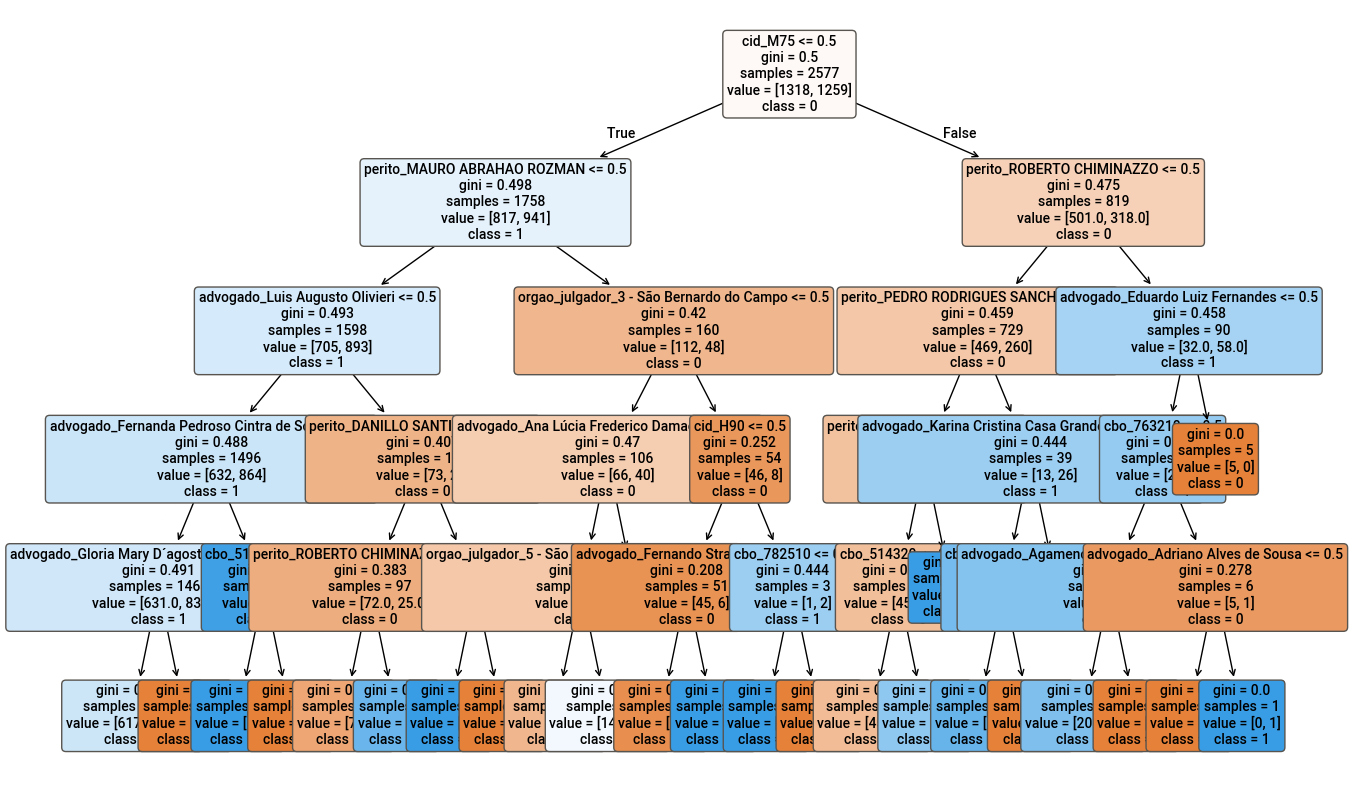

In [140]:
#Criar árvore de decisão e plotar a árvore (plot_tree)
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

# Criar um modelo de Árvore de Decisão
dtc = DecisionTreeClassifier(max_depth=5).fit(X_train_final, y_train_encoded)

# Plotar a Árvore de Decisão
plt.figure(figsize=(15, 10))
# Usar feature_names obtido do encoder
plot_tree(dtc, feature_names=feature_names, class_names=['0', '1'], filled=True, rounded=True, fontsize=10)
plt.show()

In [141]:
# Instanciar modelo de àrvore de Decisão e Treinar o modelo, lembrando de aplicar o encoder nos dados de treinamento

# Instanciar o modelo de árvore de decisão
tree_model = DecisionTreeClassifier(random_state=42)

# Treinar o modelo com os dados de treinamento codificados
tree_model.fit(X_train_final, y_train_encoded)

# Fazer previsões com os dados de teste
tree_y_pred = tree_model.predict(X_test_final)

# Avaliar o modelo
print(classification_report(y_test_encoded, tree_y_pred))
tree_accuracy = tree_model.score(X_test_final, y_test_encoded)
print("Acurácia do modelo de árvore de decisão:", tree_accuracy)

# Verificar o f1_score do modelo
f1_tree = f1_score(y_test_encoded, tree_y_pred, average='weighted')
print("F1-score do modelo de árvore de decisão:", f1_tree)

              precision    recall  f1-score   support

           0       0.65      0.63      0.64       330
           1       0.63      0.64      0.64       315

    accuracy                           0.64       645
   macro avg       0.64      0.64      0.64       645
weighted avg       0.64      0.64      0.64       645

Acurácia do modelo de árvore de decisão: 0.6387596899224807
F1-score do modelo de árvore de decisão: 0.6388065829334597


In [142]:
# Verificar o f1_score do modelo
from sklearn.metrics import f1_score

# Calcular o f1_score
f1_tree = f1_score(y_test_encoded, tree_y_pred, average='weighted')
print("F1-score do modelo de árvore de decisão:", f1_tree)

F1-score do modelo de árvore de decisão: 0.6388065829334597


##### 3.4.3.1 Ajuste de Hiperparâmetro

In [143]:
# Define o grid de hiperparâmetros para a Árvore de Decisão
param_grid_tree = {
    'criterion': ['gini', 'entropy'],  # Função de critério para medir a qualidade da divisão
    'max_depth': [3, 4],  # Profundidade máxima da árvore
    'min_samples_split': [5, 10],  # Número mínimo de amostras para dividir um nó
    'min_samples_leaf': [2, 4]  # Número mínimo de amostras em uma folha
}

# Cria o modelo de Árvore de Decisão
tree_model = DecisionTreeClassifier(random_state=42)

# Cria o GridSearchCV para a Árvore de Decisão
grid_search_tree = GridSearchCV(tree_model, param_grid_tree, cv=5, scoring='f1_weighted')

# Treina o GridSearchCV com os dados de treinamento
grid_search_tree.fit(X_train_final, y_train_encoded)

# Imprime os melhores hiperparâmetros e a melhor pontuação para a Árvore de Decisão
print("Melhores hiperparâmetros para Árvore de Decisão:", grid_search_tree.best_params_)
print("Melhor pontuação F1 para Árvore de Decisão:", grid_search_tree.best_score_)

# Usa o melhor modelo para fazer previsões
tree_y_pred = grid_search_tree.best_estimator_.predict(X_test_final)

# Avalia o modelo de Árvore de Decisão após o ajuste de hiperparâmetros
print(classification_report(y_test_encoded, tree_y_pred))
tree_accuracy = grid_search_tree.best_estimator_.score(X_test_final, y_test_encoded)
print("Acurácia do modelo de árvore de decisão após ajuste de hiperparâmetros:", tree_accuracy)

# Calcula o f1_score para a Árvore de Decisão
f1_tree = f1_score(y_test_encoded, tree_y_pred, average='weighted')
print("F1-score do modelo de árvore de decisão após ajuste de hiperparâmetros:", f1_tree)

Melhores hiperparâmetros para Árvore de Decisão: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 5}
Melhor pontuação F1 para Árvore de Decisão: 0.6086979558543903
              precision    recall  f1-score   support

           0       0.71      0.47      0.57       330
           1       0.59      0.80      0.68       315

    accuracy                           0.63       645
   macro avg       0.65      0.63      0.62       645
weighted avg       0.65      0.63      0.62       645

Acurácia do modelo de árvore de decisão após ajuste de hiperparâmetros: 0.6310077519379845
F1-score do modelo de árvore de decisão após ajuste de hiperparâmetros: 0.6215336266499056


##### 3.4.3.2 Validação Cruzada

In [144]:
# Validação cruzada do modelo de árvore de decisão

# Define o número de folds para a validação cruzada
k = 5  # Número de folds (divisões do conjunto de dados)

# Realiza a validação cruzada com o melhor modelo de árvore de decisão encontrado pelo GridSearchCV
# O parâmetro scoring é definido como 'f1_weighted' para avaliar o desempenho baseado no f1-score ponderado
cv_scores_tree = cross_val_score(grid_search_tree.best_estimator_, X_train_final, y_train_encoded, cv=k, scoring='f1_weighted')

# Imprime os scores de cada fold para a árvore de decisão
print("Scores de cada fold para Árvore de Decisão:", cv_scores_tree)

# Imprime a média e o desvio padrão dos scores para a árvore de decisão
print(f"Acurácia média da validação cruzada para Árvore de Decisão (F1-score ponderado): {cv_scores_tree.mean():.4f}")
print(f"Desvio padrão da validação cruzada para Árvore de Decisão (F1-score ponderado): {cv_scores_tree.std():.4f}")

Scores de cada fold para Árvore de Decisão: [0.58929106 0.63681138 0.59702795 0.59828303 0.62207637]
Acurácia média da validação cruzada para Árvore de Decisão (F1-score ponderado): 0.6087
Desvio padrão da validação cruzada para Árvore de Decisão (F1-score ponderado): 0.0178


##### 3.4.3.3 Matriz de Confusão

Matriz de Confusão para Árvore de Decisão:
[[156 174]
 [ 64 251]]


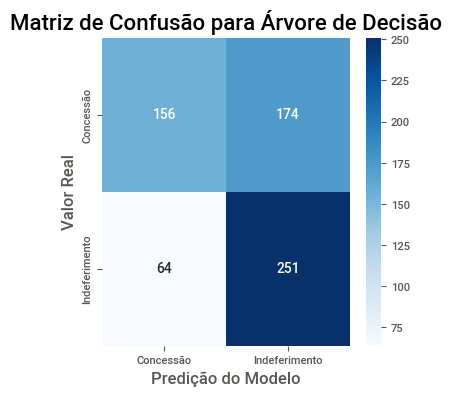

In [145]:
# Mostrar a Matriz de Confusão do modelo de Árvore de Decisão

cm_tree = confusion_matrix(y_test_encoded, tree_y_pred)

# Exibir a Matriz de Confusão para a Árvore de Decisão
print("Matriz de Confusão para Árvore de Decisão:")
print(cm_tree)

# Plotar a Matriz de Confusão para a Árvore de Decisão
plt.figure(figsize=(4, 4))
sns.heatmap(cm_tree, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Concessão', 'Indeferimento'],
            yticklabels=['Concessão', 'Indeferimento'])
plt.title('Matriz de Confusão para Árvore de Decisão', fontsize=16)
plt.xlabel('Predição do Modelo', fontsize=12)
plt.ylabel('Valor Real', fontsize=12)
plt.show()

#### 3.4.4. Random Forest

In [146]:
# Instanciar modelo de Random Forest e Treinar o modelo

from sklearn.ensemble import RandomForestClassifier

# Instanciar o modelo Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Treinar o modelo com os dados de treinamento codificados
rf_model.fit(X_train_final, y_train_encoded)

# Fazer previsões com os dados de teste
rf_y_pred = rf_model.predict(X_test_final)

# Avaliar o modelo
print(classification_report(y_test_encoded, rf_y_pred))
rf_accuracy = rf_model.score(X_test_final, y_test_encoded)
print("Acurácia do modelo Random Forest:", rf_accuracy)

# Verificar o f1_score do modelo
f1_rf = f1_score(y_test_encoded, rf_y_pred, average='weighted')
print("F1-score do modelo Random Forest:", f1_rf)

              precision    recall  f1-score   support

           0       0.71      0.70      0.70       330
           1       0.69      0.70      0.70       315

    accuracy                           0.70       645
   macro avg       0.70      0.70      0.70       645
weighted avg       0.70      0.70      0.70       645

Acurácia do modelo Random Forest: 0.7007751937984497
F1-score do modelo Random Forest: 0.7008154778374516


#####3.4.4.1 Ajuste de Hiperparâmetro

In [147]:
# Define o grid de hiperparâmetros para o Random Forest
param_grid_rf = {
    'n_estimators': [50, 100],  # Número de árvores na floresta (reduzido)
    'max_depth': [3,4],  # Profundidade máxima de cada árvore (reduzido)
    'min_samples_split': [5, 10],  # Número mínimo de amostras para dividir um nó (reduzido)
    'min_samples_leaf': [2, 4],  # Número mínimo de amostras em uma folha (reduzido)
    # 'max_features': ['sqrt', 'log2'] # Número de recursos a serem considerados em cada divisão (opcionalmente remova ou reduza)
}

# Cria o modelo de Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Cria o GridSearchCV para o Random Forest
grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=3, scoring='f1_weighted', n_jobs=-1) # reduz cv para 3 e usa todos os núcleos

# Treina o GridSearchCV com os dados de treinamento
grid_search_rf.fit(X_train_final, y_train_encoded)

# Imprime os melhores hiperparâmetros e a melhor pontuação para o Random Forest
print("Melhores hiperparâmetros para Random Forest:", grid_search_rf.best_params_)
print("Melhor pontuação F1 para Random Forest:", grid_search_rf.best_score_)

# Usa o melhor modelo para fazer previsões
rf_y_pred = grid_search_rf.predict(X_test_final)

# Avalia o modelo de Random Forest após o ajuste de hiperparâmetros
print(classification_report(y_test_encoded, rf_y_pred))
rf_accuracy = grid_search_rf.score(X_test_final, y_test_encoded)
print("Acurácia do modelo Random Forest após ajuste de hiperparâmetros:", rf_accuracy)

# Calcula o f1_score para o Random Forest
f1_rf = f1_score(y_test_encoded, rf_y_pred, average='weighted')
print("F1-score do modelo Random Forest após ajuste de hiperparâmetros:", f1_rf)

Melhores hiperparâmetros para Random Forest: {'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 50}
Melhor pontuação F1 para Random Forest: 0.6187329943115726
              precision    recall  f1-score   support

           0       0.64      0.75      0.69       330
           1       0.68      0.56      0.61       315

    accuracy                           0.65       645
   macro avg       0.66      0.65      0.65       645
weighted avg       0.66      0.65      0.65       645

Acurácia do modelo Random Forest após ajuste de hiperparâmetros: 0.6493534066170854
F1-score do modelo Random Forest após ajuste de hiperparâmetros: 0.6493534066170854


##### 3.4.4.2 Validação Cruzada

In [148]:
# Validação cruzada do modelo de Random Forest

# Define o número de folds para a validação cruzada
k = 5  # Número de folds (divisões do conjunto de dados)

# Realiza a validação cruzada com o melhor modelo de Random Forest encontrado pelo GridSearchCV
# O parâmetro scoring é definido como 'f1_weighted' para avaliar o desempenho baseado no f1-score ponderado
cv_scores_rf = cross_val_score(grid_search_rf.best_estimator_, X_train_final, y_train_encoded, cv=k, scoring='f1_weighted')

# Imprime os scores de cada fold para o Random Forest
print("Scores de cada fold para Random Forest:", cv_scores_rf)

# Imprime a média e o desvio padrão dos scores para o Random Forest
print(f"Acurácia média da validação cruzada para Random Forest (F1-score ponderado): {cv_scores_rf.mean():.4f}")
print(f"Desvio padrão da validação cruzada para Random Forest (F1-score ponderado): {cv_scores_rf.std():.4f}")

Scores de cada fold para Random Forest: [0.61969135 0.64295667 0.63690964 0.61791786 0.62002796]
Acurácia média da validação cruzada para Random Forest (F1-score ponderado): 0.6275
Desvio padrão da validação cruzada para Random Forest (F1-score ponderado): 0.0104


##### 3.4.4.3 Matriz de Confusão

Matriz de Confusão para Random Forest:
[[246  84]
 [140 175]]


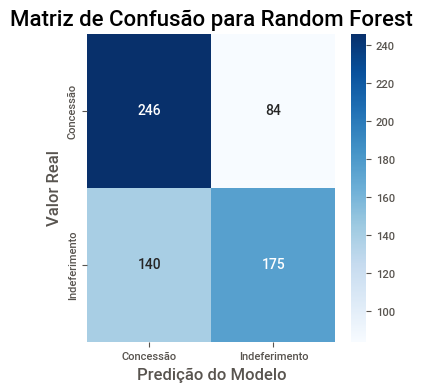

In [149]:
# Mostrar a Matriz de Confusão do modelo de Random Forest

cm_rf = confusion_matrix(y_test_encoded, rf_y_pred)

# Exibir a Matriz de Confusão para o Random Forest
print("Matriz de Confusão para Random Forest:")
print(cm_rf)

# Plotar a Matriz de Confusão para o Random Forest
plt.figure(figsize=(4, 4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Concessão', 'Indeferimento'],
            yticklabels=['Concessão', 'Indeferimento'])
plt.title('Matriz de Confusão para Random Forest', fontsize=16)
plt.xlabel('Predição do Modelo', fontsize=12)
plt.ylabel('Valor Real', fontsize=12)
plt.show()

#### 3.4.5. XGBoost

In [150]:
# Instanciar modelo de XGBoost e Treinar o modelo
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Instanciar o modelo XGBoost
xgb_model = xgb.XGBClassifier(random_state=42)

# Treinar o modelo com os dados de treinamento codificados
xgb_model.fit(X_train_final, y_train_encoded)

# Fazer previsões com os dados de teste
xgb_y_pred = xgb_model.predict(X_test_final)

# Avaliar o modelo
print(classification_report(y_test_encoded, xgb_y_pred))
xgb_accuracy = accuracy_score(y_test_encoded, xgb_y_pred) # Usar accuracy_score
print(f"Acurácia do modelo XGBoost: {xgb_accuracy}")

# Calcular o f1-score
f1_xgb = f1_score(y_test_encoded, xgb_y_pred, average='weighted')
print(f"F1-score do modelo XGBoost: {f1_xgb}")

              precision    recall  f1-score   support

           0       0.71      0.67      0.69       330
           1       0.67      0.71      0.69       315

    accuracy                           0.69       645
   macro avg       0.69      0.69      0.69       645
weighted avg       0.69      0.69      0.69       645

Acurácia do modelo XGBoost: 0.6868217054263566
F1-score do modelo XGBoost: 0.686781054038172


##### 3.4.5.1 Ajuste de Hiperparâmetro

In [151]:
# Define o grid de hiperparâmetros para o XGBoost (reduzido para otimizar tempo)
param_grid_xgb = {
    'n_estimators': [50, 100],  # Número de árvores (reduzido)
    'max_depth': [3, 4],  # Profundidade máxima das árvores (reduzido)
    'learning_rate': [0.1, 0.01], # Taxa de aprendizado (reduzido)
}

# Cria o modelo XGBoost
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss') # use_label_encoder=False para evitar aviso

# Cria o GridSearchCV para o XGBoost
grid_search_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=3, scoring='f1_weighted', n_jobs=-1) # cv reduzido para 3

# Treina o GridSearchCV com os dados de treinamento
grid_search_xgb.fit(X_train_final, y_train_encoded) # Usa y_train_encoded já codificado

# Imprime os melhores hiperparâmetros e a melhor pontuação para o XGBoost
print("Melhores hiperparâmetros para XGBoost:", grid_search_xgb.best_params_)
print("Melhor pontuação F1 para XGBoost:", grid_search_xgb.best_score_)

# Usa o melhor modelo para fazer previsões
xgb_y_pred = grid_search_xgb.predict(X_test_final)

# Avalia o modelo XGBoost após o ajuste de hiperparâmetros
print(classification_report(y_test_encoded, xgb_y_pred))
xgb_accuracy = grid_search_xgb.score(X_test_final, y_test_encoded)
print("Acurácia do modelo XGBoost após ajuste de hiperparâmetros:", xgb_accuracy)

# Calcula o f1_score para o XGBoost
f1_xgb = f1_score(y_test_encoded, xgb_y_pred, average='weighted')
print("F1-score do modelo XGBoost após ajuste de hiperparâmetros:", f1_xgb)

Melhores hiperparâmetros para XGBoost: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
Melhor pontuação F1 para XGBoost: 0.6810010844523312
              precision    recall  f1-score   support

           0       0.71      0.67      0.69       330
           1       0.67      0.71      0.69       315

    accuracy                           0.69       645
   macro avg       0.69      0.69      0.69       645
weighted avg       0.69      0.69      0.69       645

Acurácia do modelo XGBoost após ajuste de hiperparâmetros: 0.6898822317209624
F1-score do modelo XGBoost após ajuste de hiperparâmetros: 0.6898822317209624


##### 3.4.5.2 Validação Cruzada

In [152]:
# Validação cruzada do modelo XGBoost

# Define o número de folds para a validação cruzada
k = 5  # Número de folds (divisões do conjunto de dados)

# Realiza a validação cruzada com o melhor modelo XGBoost encontrado pelo GridSearchCV
# O parâmetro scoring é definido como 'f1_weighted' para avaliar o desempenho baseado no f1-score ponderado
cv_scores_xgb = cross_val_score(grid_search_xgb.best_estimator_, X_train_final, y_train_encoded, cv=k, scoring='f1_weighted')

# Imprime os scores de cada fold para o XGBoost
print("Scores de cada fold para XGBoost:", cv_scores_xgb)

# Imprime a média e o desvio padrão dos scores para o XGBoost
print(f"Acurácia média da validação cruzada para XGBoost (F1-score ponderado): {cv_scores_xgb.mean():.4f}")
print(f"Desvio padrão da validação cruzada para XGBoost (F1-score ponderado): {cv_scores_xgb.std():.4f}")

Scores de cada fold para XGBoost: [0.66858847 0.71317829 0.66713365 0.66411567 0.67768206]
Acurácia média da validação cruzada para XGBoost (F1-score ponderado): 0.6781
Desvio padrão da validação cruzada para XGBoost (F1-score ponderado): 0.0181


##### 3.4.5.3 Matriz de Confusão

Matriz de Confusão para XGBoost:
[[221 109]
 [ 91 224]]


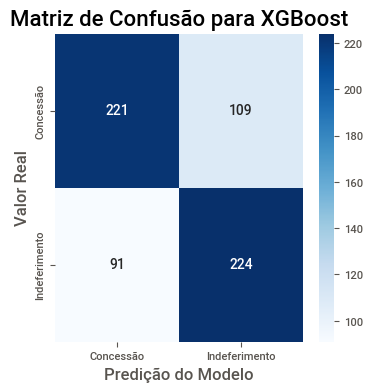

In [153]:
# Mostrar a Matriz de Confusão do modelo XGBoost

cm_xgb = confusion_matrix(y_test_encoded, xgb_y_pred)

# Exibir a Matriz de Confusão para o XGBoost
print("Matriz de Confusão para XGBoost:")
print(cm_xgb)

# Plotar a Matriz de Confusão para o XGBoost
plt.figure(figsize=(4, 4))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Concessão', 'Indeferimento'],
            yticklabels=['Concessão', 'Indeferimento'])
plt.title('Matriz de Confusão para XGBoost', fontsize=16)
plt.xlabel('Predição do Modelo', fontsize=12)
plt.ylabel('Valor Real', fontsize=12)
plt.show()

### 3.5 - Interpretação do Modelo

In [154]:
# INTEPRETAÇÃO DA REGRESSÃO LOGÍSTICA

# Get coefficients
coefficients = grid_search.best_estimator_.coef_[0]

# Create a DataFrame for easy viewing
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Odds Ratio': np.exp(coefficients)
})

# Sort by absolute value of coefficients
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df.sort_values(by='Abs_Coefficient', ascending=False, inplace=True)

# Display the coefficients
coef_df[['Feature', 'Coefficient', 'Odds Ratio']]

,Feature,Coefficient,Odds Ratio
944,advogado_Luis Augusto Olivieri,-0.792302,0.452801
556,perito_PEDRO RODRIGUES SANCHES,0.765599,2.150282
550,perito_MAURO ABRAHAO ROZMAN,-0.754392,0.470296
557,perito_RENAN LOPES MONTEIRO,-0.742073,0.476126
585,advogado_Agamenon Martins de Oliveira,-0.720374,0.486570
800,advogado_Fernanda Pedroso Cintra de Souza,0.687555,1.988846
838,advogado_Gloria Mary D´agostino Sacchi,-0.686317,0.503427
559,perito_ROBERTO CHIMINAZZO,0.656624,1.928272
568,perito_VIVIAM PAULA LUCIANELLI SPINA,0.644507,1.905048
514,orgao_julgador_8 - São Bernardo do Campo,0.624840,1.867946


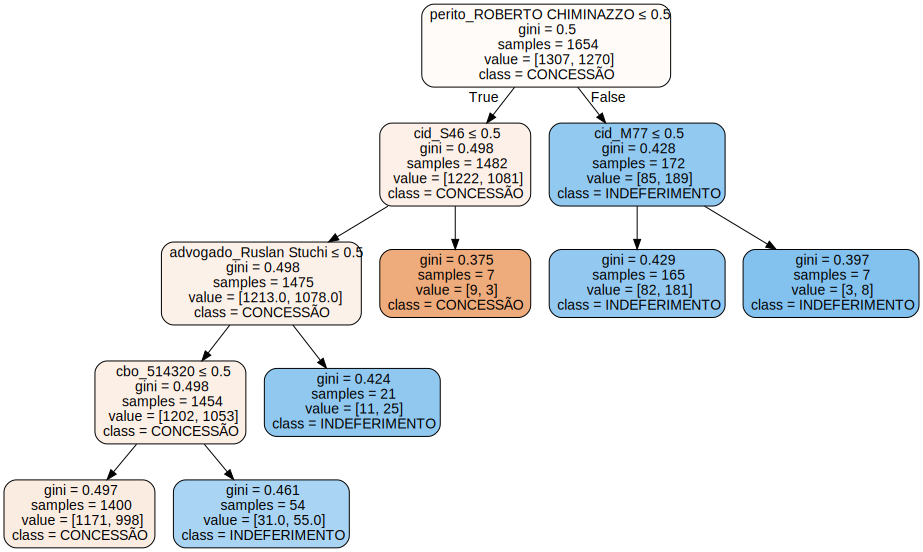

In [155]:
# INTERPRETAÇÃO DE DECISION TREE E RANDOM FOREST


from sklearn.tree import export_graphviz
import graphviz

# #Melhor árvore DecisionTree
# best_tree = grid_search_tree.best_estimator

# #Melhor árvore RandomForest
best_tree = grid_search_rf.best_estimator_.estimators_[0]

# Exporta a árvore para o formato .dot
dot_data = export_graphviz(
    best_tree,
    out_file=None,               # Deixe como None para gerar uma string
    feature_names = feature_names,  # Nomes das variáveis
    class_names = class_names,     # Nomes das classes
    filled=True,                # Adiciona cores aos nós
    rounded=True,               # Deixa os nós arredondados
    special_characters=True
)

# Renderiza a árvore com o Graphviz
graph = graphviz.Source(dot_data)
graph.view()  # Abre a árvore em um visualizador padrão
graph

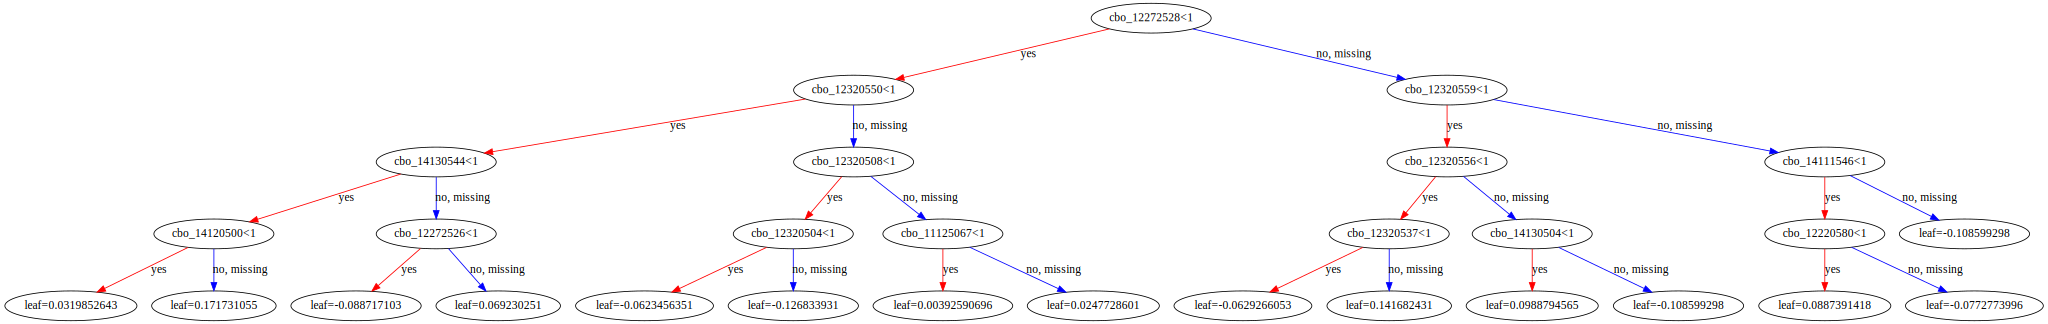

In [156]:
# Interpretação do modelo XGBoost usando graphviz
#!apt-get install graphviz -y
#!pip install graphviz

import graphviz
from xgboost import plot_tree, XGBClassifier
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder

# Obter uma árvore do modelo XGBoost (a primeira árvore, no índice 0)
best_xgb_tree = grid_search_xgb.best_estimator_.get_booster().get_dump()[0]
#print(best_xgb_tree)

# Criar um objeto graphviz a partir da string da árvore
xgb_dot_data = graphviz.Source(grid_search_xgb.best_estimator_.get_booster().get_dump(dump_format='dot')[0])

# Obtenha os nomes das features após o OneHotEncoding
#feature_names = encoder.get_feature_names_out(X.columns)

# Criar um dicionário para mapear índices de features para nomes
feature_name_map = {i: name for i, name in enumerate(feature_names)}

# Substituir os índices de features no código DOT pelo nome das features correspondentes.
# Primeiro, copie o conteúdo de xgb_dot_data.source para uma nova variável.
modified_dot_source = xgb_dot_data.source

# Execute um loop pelos índices numéricos no código DOT
for i in range(len(feature_names)):
  # Substitua todos os índices numéricos pelo nome da característica
  modified_dot_source = modified_dot_source.replace(f'f{i}', feature_name_map[i])

# Atualize o conteúdo do objeto graphviz com o código DOT modificado.
xgb_dot_data = graphviz.Source(modified_dot_source)

# Visualizar a árvore
xgb_dot_data.render("xgboost_tree", format="png", cleanup=True)  # Salva a árvore em um arquivo PNG
xgb_dot_data.view()  # Abre a imagem no navegador
xgb_dot_data

In [157]:
# EXPORTA O MODELO PARA REPOSITÓRIO PICKLE
import pickle

# Salvar o modelo
with open('modelo_RegLog.pkl', 'wb') as file:
    pickle.dump(grid_search.best_estimator_, file)

In [158]:
#EXPORTA O ENCODER PARA PREDIÇÃO
import pickle

# Salvando a lista em um arquivo pickle
with open('encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)
